In [ ]:
import os
import pandas as pd
#import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

#from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Eigene Module
from src.dataimport import list_files_with_extension_directory, load_text
from src.llmlib import num_tokens_from_string
from src.llmeval import transform_content_to_args, extract_response_info, calculate_bleu_score, get_confusion_matrix, apply_relations_confusion_matrix, plot_confusion_matrices

# Train-Test Split

In [3]:
TXT_FILES_PATH = 'data/original/brat-project-final/'
JSON_FILES_PATH = 'data/transformed/'

# Text- und JSON-Dateien laden und in Listen speichern
txt_files_directory_list = list_files_with_extension_directory(TXT_FILES_PATH, '.txt')
json_files_directory_list = list_files_with_extension_directory(JSON_FILES_PATH, '.json')

In [4]:
# Listen in DataFrame umwandeln und Text- und JSON-Inhalte laden
df = pd.DataFrame()
df['txt_path'] = txt_files_directory_list
df['json_path'] = json_files_directory_list
df['txt_file'] = df['txt_path'].apply(lambda x: os.path.basename(x))
df['json_file'] = df['json_path'].apply(lambda x: os.path.basename(x))
df['txt'] = df['txt_path'].apply(load_text)
df['json'] = df['json_path'].apply(load_text)

print(df.shape)
df.head()

(402, 6)


txt_path  \
0  data/original/brat-project-final/essay001.txt   
1  data/original/brat-project-final/essay002.txt   
2  data/original/brat-project-final/essay003.txt   
3  data/original/brat-project-final/essay004.txt   
4  data/original/brat-project-final/essay005.txt   

                        json_path      txt_file      json_file  \
0  data/transformed/essay001.json  essay001.txt  essay001.json   
1  data/transformed/essay002.json  essay002.txt  essay002.json   
2  data/transformed/essay003.json  essay003.txt  essay003.json   
3  data/transformed/essay004.json  essay004.txt  essay004.json   
4  data/transformed/essay005.json  essay005.txt  essay005.json   

                                                 txt  \
0  Should students be taught to compete or to coo...   
1  More people are migrating to other countries t...   
2  International tourism is now more common than ...   
3  International tourism is now more common than ...   
4  Living and studying overseas\n\nIt is every st...   

                                                json  
0  {\n  "MajorClaims": [\n    {\n      "ID": "MC1...  
1  {\n  "MajorClaims": [\n    {\n      "ID": "MC1...  
2  {\n  "MajorClaims": [\n    {\n      "ID": "MC1...  
3  {\n  "MajorClaims": [\n    {\n      "ID": "MC1...  
4  {\n  "MajorClaims": [\n    {\n      "ID": "MC1...

In [5]:
# Datensatz in Trainings- und Testdaten aufteilen
train_df, test_df = train_test_split(df, train_size=40, random_state=42)

print(f"Training DataFrame: {train_df.shape}")
print(f"\nTest DataFrame: {test_df.shape}")

Training DataFrame: (40, 6)

Test DataFrame: (362, 6)


In [6]:
duplicate_list = ['essay171.txt', 'essay209.txt', 'essay210.txt'] # aus dem 3. Notebook, siehe "Behandlung von Duplikaten"
# entfernen der Duplikate aus dem Testset
test_df = test_df[~test_df['txt_file'].isin(duplicate_list)] # ~ bedeutet "not in", siehe https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.isin.html
test_df.shape

(359, 6)

# Daten aufbereiten

## Grundwahrheit aufbereiten
aus Testdatensatz

In [7]:
# Dataframe mit Grundwahrheiten erstellen    
eval_df = test_df.loc[:, ['txt_file', 'json']] # Text und JSON-Objekt extrahieren
eval_df = transform_content_to_args(eval_df, 'json') # aus JSON-Objekt Argumentkomponenten und -beziehungen extrahieren
eval_df.head()

txt_file                                          relations  \
285  essay286.txt  [(These experiences taught me to change my lif...   
281  essay282.txt  [(I could enjoy listening music without thinki...   
33   essay034.txt  [(there are some advantages of leaving school ...   
211  essay212.txt  [(it will be easier for people to assimilate i...   
93   essay094.txt  [(reasonable attentions should be paid to trea...   

                                           majorclaims  \
285  [Many circumstances that I experienced change ...   
281  [reducing stress by listening to music, playin...   
33   [student have to be forced to study at school,...   
211  [I would follow the new customs, if I migrated...   
93   [It is a completely right and extremely wise p...   

                                                claims  \
285  [These experiences taught me to change my life...   
281  [listening to music is a great way to relax, a...   
33   [there are some advantages of leaving school t...   
211  [it will be easier for people to assimilate in...   
93   [reasonable attentions should be paid to treat...   

                                              premises  
285  [I could find a better way to solve problems, ...  
281  [I always listen music from my mp3 player, I c...  
33   [studying at school is always the best choice ...  
211  [When people migrate to a new country, they ar...  
93   [Preventative measures will help improve gener...

## Ausgaben des LLMs aufbereiten
aus den JSONL-Dateien von der Batch API

In [8]:
JSONL_PATH = "batch_api/output/"
jsonl_files_directory_list = list_files_with_extension_directory(JSONL_PATH, '.jsonl')
jsonl_files_directory_list

['batch_api/output/output-batch-1.jsonl',
 'batch_api/output/output-batch-2.jsonl',
 'batch_api/output/output-batch-3.jsonl',
 'batch_api/output/output-batch-4.jsonl',
 'batch_api/output/output-batch-5.jsonl',
 'batch_api/output/output-batch-6.jsonl',
 'batch_api/output/output-batch-7.jsonl',
 'batch_api/output/output-batch-8.jsonl',
 'batch_api/output/output-batch-9.jsonl']

In [9]:
# Für jede Datei in der Liste wird ein DataFrame erstellt und in einer Liste gespeichert
# Die einzelnen DataFrames werden dann mit pd.concat() zusammengeführt
batch_output_list = []
for file in jsonl_files_directory_list:
    batch_output_list.append(pd.read_json(file, lines=True))

batch_output = pd.concat(batch_output_list, ignore_index=True) # Dataframes der Batches zusammenfügen
print(batch_output.shape)
batch_output.sample(5, random_state=42)

(7240, 4)


id  \
509   batch_req_677f89139adc81908fd42c492e8111ee   
4359  batch_req_6780e1e6b1688190bbeb6e995d8c1ee0   
3753  batch_req_677f8a6e6a408190bec4d86bce1fb411   
2080  batch_req_677f89bdb988819093da2f68f80417ad   
3836  batch_req_6780e1bd52b88190a6054b95190713f3   

                           custom_id  \
509   zero-shot-persona_essay164.txt   
4359        few-shot-20_essay016.txt   
3753    few-shot-10-cot_essay147.txt   
2080   one-shot-persona_essay300.txt   
3836    few-shot-10-cot_essay241.txt   

                                               response  error  
509   {'status_code': 200, 'request_id': '17a71868ac...    NaN  
4359  {'status_code': 200, 'request_id': '74d634276b...    NaN  
3753  {'status_code': 200, 'request_id': 'ab8842c03a...    NaN  
2080  {'status_code': 200, 'request_id': 'd091b01dbf...    NaN  
3836  {'status_code': 200, 'request_id': 'c3bd4af6e4...    NaN

In [10]:
# relevanten Informationen aus der Response des LLMs extrahieren
batch_output[['model','system_fingerprint', 'content', 'input_tokens', 'output_tokens', 'total_tokens', 'prompt_token_details', 'completion_token_details']] = batch_output['response'].apply(extract_response_info)
batch_output.head()

id               custom_id  \
0  batch_req_677f88dcb8c881908e9275650fab34fa  zero-shot_essay001.txt   
1  batch_req_677f88dcd6008190a386937aa784034a  zero-shot_essay002.txt   
2  batch_req_677f88dcf5548190beb4d0c87ae04293  zero-shot_essay003.txt   
3  batch_req_677f88dd19048190b1888ef1142d1c07  zero-shot_essay004.txt   
4  batch_req_677f88dd2ed48190afda69e74136373a  zero-shot_essay005.txt   

                                            response  error  \
0  {'status_code': 200, 'request_id': '82330270e6...    NaN   
1  {'status_code': 200, 'request_id': '277978b8c4...    NaN   
2  {'status_code': 200, 'request_id': '0e7553c18b...    NaN   
3  {'status_code': 200, 'request_id': 'bcdc4e4808...    NaN   
4  {'status_code': 200, 'request_id': '4ff9c0eb74...    NaN   

                    model system_fingerprint  \
0  gpt-4o-mini-2024-07-18      fp_0aa8d3e20b   
1  gpt-4o-mini-2024-07-18      fp_0aa8d3e20b   
2  gpt-4o-mini-2024-07-18      fp_f2cd28694a   
3  gpt-4o-mini-2024-07-18      fp_d02d531b47   
4  gpt-4o-mini-2024-07-18      fp_f2cd28694a   

                                             content  input_tokens  \
0  {"MajorClaims":[{"ID":"MC1","Text":"We should ...           673   
1  {\n  "MajorClaims": [\n    {\n      "ID": "MC1...           628   
2  {\n  "MajorClaims": [\n    {\n      "ID": "MC1...           557   
3  {\n  "MajorClaims": [\n    {\n      "ID": "MC1...           582   
4  {\n  "MajorClaims": [\n    {\n      "ID": "MC1...           547   

   output_tokens  total_tokens                     prompt_token_details  \
0            336          1009  {'cached_tokens': 0, 'audio_tokens': 0}   
1            569          1197  {'cached_tokens': 0, 'audio_tokens': 0}   
2            631          1188  {'cached_tokens': 0, 'audio_tokens': 0}   
3            552          1134  {'cached_tokens': 0, 'audio_tokens': 0}   
4            534          1081  {'cached_tokens': 0, 'audio_tokens': 0}   

                            completion_token_details  
0  {'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...  
1  {'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...  
2  {'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...  
3  {'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...  
4  {'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...

In [11]:
# einzigartige Werte für Model und System Fingerprint aus der Response extrahieren
print(f"Verwendete Modelle: {batch_output['model'].unique()}")
print(f"\nVerwendete System Fingerprints: {batch_output['system_fingerprint'].unique()}")

# Der system_fingerprint kann bisher nicht and das LLM bei der Abfrage mit übergeben werden, sondern ist lediglich eine Metainformation
# Quelle: https://cookbook.openai.com/examples/reproducible_outputs_with_the_seed_parameter

Verwendete Modelle: ['gpt-4o-mini-2024-07-18']

Verwendete System Fingerprints: ['fp_0aa8d3e20b' 'fp_f2cd28694a' 'fp_d02d531b47' 'fp_01aeff40ea'
 'fp_72ed7ab54c' 'fp_bd83329f63']


Wie im 3.Notebook erläutert sind drei Texte Duplikate, die entfernt werden müssen. Bei 20 Anfragen (Prompts) pro Text werden somit 60 Anfragen nachträglich entfernt. Es können somit 7180 (= 7240 - 60) Anfragen für die Evaluation verwendet werden.  

In [12]:
# Inhalte aus "Content" extrahieren
batch_output = transform_content_to_args(batch_output, 'content')

# Extrahieren der Metainformationen zum Prompt und verwendeten Text aus der custom_id
batch_output["prompt"] = batch_output["custom_id"].apply(lambda x: x.split("_")[0])
batch_output["txt_file"] = batch_output["custom_id"].apply(lambda x: x.split("_")[1]) # gleiche Bezeichnung wie im DF für Grundwahrheit, zum mergen

# Entfernen der Duplikate anhand der duplicate_list
batch_output = batch_output[~batch_output['txt_file'].isin(duplicate_list)] # ~ bedeutet "not in", Ansatz entnommen aus https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.isin.html

# entfernen von Spalten, die nicht mehr benötigt werden
batch_output = batch_output.drop(columns=["custom_id", 'id', 'response','error'])
print(batch_output.shape)
batch_output.head() 

(7180, 13)


model system_fingerprint  input_tokens  output_tokens  \
0  gpt-4o-mini-2024-07-18      fp_0aa8d3e20b           673            336   
1  gpt-4o-mini-2024-07-18      fp_0aa8d3e20b           628            569   
2  gpt-4o-mini-2024-07-18      fp_f2cd28694a           557            631   
3  gpt-4o-mini-2024-07-18      fp_d02d531b47           582            552   
4  gpt-4o-mini-2024-07-18      fp_f2cd28694a           547            534   

   total_tokens                     prompt_token_details  \
0          1009  {'cached_tokens': 0, 'audio_tokens': 0}   
1          1197  {'cached_tokens': 0, 'audio_tokens': 0}   
2          1188  {'cached_tokens': 0, 'audio_tokens': 0}   
3          1134  {'cached_tokens': 0, 'audio_tokens': 0}   
4          1081  {'cached_tokens': 0, 'audio_tokens': 0}   

                            completion_token_details  \
0  {'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...   
1  {'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...   
2  {'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...   
3  {'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...   
4  {'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...   

                                           relations  \
0  [(Competition can effectively promote the deve...   
1  [(The last 50 years have seen an increasing nu...   
2  [(The last decade has seen an increasing numbe...   
3  [(The last 50 years have seen a significant in...   
4  [(One who studies overseas will gain many skil...   

                                         majorclaims  \
0  [We should attach more importance to cooperati...   
1  [Sustaining cultural identities helps immigran...   
2  [International tourism has contributed to the ...   
3  [International tourism has affected the cultur...   
4  [One who studies overseas will gain many skill...   

                                              claims  \
0  [Competition can effectively promote the devel...   
1  [Maintaining one’s cultural identity is a key ...   
2  [International tourism promotes many aspects o...   
3  [Tourism can create negative impacts on the de...   
4  [Studying at an overseas university gives indi...   

                                            premises     prompt      txt_file  
0  [Companies improve their products and services...  zero-shot  essay001.txt  
1  [The last 50 years have seen an increasing num...  zero-shot  essay002.txt  
2  [The last decade has seen an increasing number...  zero-shot  essay003.txt  
3  [The last 50 years have seen a significant inc...  zero-shot  essay004.txt  
4  [Interacting and communicating with students f...  zero-shot  essay005.txt

In [13]:
# Anzahl der Anfragen pro Prompt
print(batch_output['prompt'].value_counts())

# Summe der Anfragen
print(f"\nSumme der Anfragen: {batch_output.shape[0]}")

prompt
zero-shot                  359
zero-shot-persona          359
few-shot-40-cot            359
few-shot-40-persona        359
few-shot-40                359
few-shot-20-persona-cot    359
few-shot-20-cot            359
few-shot-20-persona        359
few-shot-20                359
few-shot-10-persona-cot    359
few-shot-10-cot            359
few-shot-10-persona        359
few-shot-10                359
one-shot-persona-cot       359
one-shot-cot               359
one-shot-persona           359
one-shot                   359
zero-shot-persona-cot      359
zero-shot-cot              359
few-shot-40-persona-cot    359
Name: count, dtype: int64

Summe der Anfragen: 7180


## Verbinden von Grundwahrheit und LLM-Ausgaben

In [14]:
# Zusammenführen von Grundwahrheit und LLM Output
merged_eval_df = pd.merge(eval_df, batch_output, on='txt_file', suffixes=('_truth', '_llm'))
print(merged_eval_df.shape)
merged_eval_df.head()

(7180, 17)


txt_file                                    relations_truth  \
0  essay286.txt  [(These experiences taught me to change my lif...   
1  essay286.txt  [(These experiences taught me to change my lif...   
2  essay286.txt  [(These experiences taught me to change my lif...   
3  essay286.txt  [(These experiences taught me to change my lif...   
4  essay286.txt  [(These experiences taught me to change my lif...   

                                   majorclaims_truth  \
0  [Many circumstances that I experienced change ...   
1  [Many circumstances that I experienced change ...   
2  [Many circumstances that I experienced change ...   
3  [Many circumstances that I experienced change ...   
4  [Many circumstances that I experienced change ...   

                                        claims_truth  \
0  [These experiences taught me to change my life...   
1  [These experiences taught me to change my life...   
2  [These experiences taught me to change my life...   
3  [These experiences taught me to change my life...   
4  [These experiences taught me to change my life...   

                                      premises_truth                   model  \
0  [I could find a better way to solve problems, ...  gpt-4o-mini-2024-07-18   
1  [I could find a better way to solve problems, ...  gpt-4o-mini-2024-07-18   
2  [I could find a better way to solve problems, ...  gpt-4o-mini-2024-07-18   
3  [I could find a better way to solve problems, ...  gpt-4o-mini-2024-07-18   
4  [I could find a better way to solve problems, ...  gpt-4o-mini-2024-07-18   

  system_fingerprint  input_tokens  output_tokens  total_tokens  \
0      fp_0aa8d3e20b           663            376          1039   
1      fp_0aa8d3e20b           686            336          1022   
2      fp_d02d531b47          1062            477          1539   
3      fp_0aa8d3e20b          1085            492          1577   
4      fp_0aa8d3e20b          2361            772          3133   

                      prompt_token_details  \
0  {'cached_tokens': 0, 'audio_tokens': 0}   
1  {'cached_tokens': 0, 'audio_tokens': 0}   
2  {'cached_tokens': 0, 'audio_tokens': 0}   
3  {'cached_tokens': 0, 'audio_tokens': 0}   
4  {'cached_tokens': 0, 'audio_tokens': 0}   

                            completion_token_details  \
0  {'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...   
1  {'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...   
2  {'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...   
3  {'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...   
4  {'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...   

                                       relations_llm  \
0  [(Experiences shape my thinking and the way I ...   
1  [(Experiences improve my life in many ways., f...   
2  [(Studying in university taught me to be more ...   
3  [(Experiences improve the way I solve problems...   
4  [(there are many experiences that are improve ...   

                                     majorclaims_llm  \
0  [Experiences shape my thinking and the way I l...   
1  [Experiences that shape my thinking and the wa...   
2  [Experiences shape my thinking and the way I l...   
3  [Experiences that shape my thinking and the wa...   
4  [experiences that shape my thinking and the wa...   

                                          claims_llm  \
0  [Experiences improve the way I solve problems....   
1  [Experiences improve my life in many ways., St...   
2  [Studying in university taught me to be more p...   
3  [Experiences improve the way I solve problems....   
4  [there are many experiences that are improve m...   

                                        premises_llm                 prompt  
0  [Studying in university taught me to be more p...              zero-shot  
1  [I could improve the way that I solve problems...      zero-shot-persona  
2  [In math class, we learned to find answers ste...          zero-shot-cot  
3  [Studying in university taught me to be more p...  zero-shot-persona-cot  
4  [the way t

# Evaluation

## Änhlichkeitsmetrik BLEU-Score

In [15]:
# Beispiele 
text1 = "Das ist ein Beispieltext für die Berechnung des BLEU Scores."
text2 = "das ist ein Beispieltext für die Berechnung des BLEU Scores"
print(f"Mit Beachtung der Großschreibung: {round(calculate_bleu_score(text1, text2), 2)}")
print(f"Ohne Beachtung der Großschreibung: {round(calculate_bleu_score(text1.lower(), text2.lower()), 2)}")

Mit Beachtung der Großschreibung: 0.76
Ohne Beachtung der Großschreibung: 0.88


In [16]:
# Perfekte übereinstimmung zur Überprüfung der Glättungsfunktion
texta = "Das ist ein Beispieltext für die Berechnung des BLEU-Scores."
textb = "Das ist ein Beispieltext für die Berechnung des BLEU-Scores."
calculate_bleu_score(texta, textb)

1.0

## True Positives (TP), False Positives (FP), und False Negatives (FN) berechnen

### Für Argumentationskomponenten

In [ ]:
# Berechnung der Werte aus der Konfusionsmatrix für die einzelnen Argumentkomponenten anhand des BLEU Scores
cm_results = merged_eval_df.apply(get_confusion_matrix, axis=1, ground_truth_col=['majorclaims_truth', 'claims_truth', 'premises_truth'], prediction_col=['majorclaims_llm', 'claims_llm', 'premises_llm'])
merged_eval_df = pd.concat([merged_eval_df, cm_results], axis=1)
merged_eval_df.head()

txt_file                                    relations_truth  \
0  essay286.txt  [(These experiences taught me to change my lif...   
1  essay286.txt  [(These experiences taught me to change my lif...   
2  essay286.txt  [(These experiences taught me to change my lif...   
3  essay286.txt  [(These experiences taught me to change my lif...   
4  essay286.txt  [(These experiences taught me to change my lif...   

                                   majorclaims_truth  \
0  [Many circumstances that I experienced change ...   
1  [Many circumstances that I experienced change ...   
2  [Many circumstances that I experienced change ...   
3  [Many circumstances that I experienced change ...   
4  [Many circumstances that I experienced change ...   

                                        claims_truth  \
0  [These experiences taught me to change my life...   
1  [These experiences taught me to change my life...   
2  [These experiences taught me to change my life...   
3  [These experiences taught me to change my life...   
4  [These experiences taught me to change my life...   

                                      premises_truth                   model  \
0  [I could find a better way to solve problems, ...  gpt-4o-mini-2024-07-18   
1  [I could find a better way to solve problems, ...  gpt-4o-mini-2024-07-18   
2  [I could find a better way to solve problems, ...  gpt-4o-mini-2024-07-18   
3  [I could find a better way to solve problems, ...  gpt-4o-mini-2024-07-18   
4  [I could find a better way to solve problems, ...  gpt-4o-mini-2024-07-18   

  system_fingerprint  input_tokens  output_tokens  total_tokens  ...  \
0      fp_0aa8d3e20b           663            376          1039  ...   
1      fp_0aa8d3e20b           686            336          1022  ...   
2      fp_d02d531b47          1062            477          1539  ...   
3      fp_0aa8d3e20b          1085            492          1577  ...   
4      fp_0aa8d3e20b          2361            772          3133  ...   

  Claims_TP Claims_FN Claims_FP Claims_TN  \
0         0         5         3         0   
1         0         5         4         0   
2         0         5         3         0   
3         0         5         3         0   
4         4         1         0         0   

                          Claims_Similarity Premises_TP Premises_FN  \
0  [0.2494, 0.2692, 0.0192, 0.0314, 0.0314]           0          17   
1   [0.6775, 0.2824, 0.301, 0.1236, 0.6163]           0          17   
2  [0.2906, 0.2824, 0.0173, 0.0922, 0.5642]           0          17   
3  [0.6221, 0.2824, 0.0192, 0.0186, 0.0186]           0          17   
4           [1.0, 1.0, 0.9036, 0.1012, 1.0]           8           9   

   Premises_FP  Premises_TN                                Premises_Similarity  
0            7            0  [0.0737, 0.0278, 0.0525, 0.3865, 0.0469, 0.041...  
1            4            0  [0.3884, 0, 0.0895, 0.0192, 0.5425, 0.0651, 0....  
2            6            0  [0.0737, 0.0189, 0.0525, 0.3816, 0.0519, 0.041...  
3            6            0  [0.3566, 0.0364, 0.0203, 0.3146, 0.2931, 0.041...  
4            0            0  [1.0, 0.7598, 0.0743, 1.0, 1.0, 1.0, 0.8071, 0...  

[5 rows x 32 columns]

In [ ]:
# Beispiel für die Werte der Konfusionsmatrix
merged_eval_df[['MajorClaims_TP', 'MajorClaims_FN', 'MajorClaims_FP', 'MajorClaims_TN', 'Claims_TP', 'Claims_FN', 'Claims_FP', 'Claims_TN', 'Premises_TP', 'Premises_FN', 'Premises_FP', 'Premises_TN']].sample(5, random_state=42)

MajorClaims_TP  MajorClaims_FN  MajorClaims_FP  MajorClaims_TN  \
1554               1               1               1               0   
2876               1               1               1               0   
1755               2               0               0               0   
2505               0               1               1               0   
1335               2               0               0               0   

      Claims_TP  Claims_FN  Claims_FP  Claims_TN  Premises_TP  Premises_FN  \
1554          1          3          6          0            5            9   
2876          1          7          3          0            3            3   
1755          2          1          4          0            1            5   
2505          2          2          5          0            3            4   
1335          2          1          5          0            5           12   

      Premises_FP  Premises_TN  
1554            3            0  
2876            1            0  
1755            3            0  
2505            0            0  
1335            2            0

### Beziehungen

In [ ]:
# Berechnung der Werte aus der Konfusionsmatrix für die argumentativen Beziehungen anhand des BLEU Scores
merged_eval_df[['Relations_TP', 'Relations_FN', 'Relations_FP', 'Relations_TN', 'Relations_Similarity']] = merged_eval_df.apply(apply_relations_confusion_matrix, axis=1, ground_truth_col='relations_truth', prediction_col='relations_llm')

### Argumentationskomponenten und Beziehungen gruppiert nach Prompt

In [ ]:
# Gruppierung der Werte aus der Konfusionsmatrix nach Prompt
grouped_df = merged_eval_df[['MajorClaims_TP', 'MajorClaims_FN', 'MajorClaims_FP', 'MajorClaims_TN', 'Claims_TP', 'Claims_FN', 'Claims_FP', 'Claims_TN', 'Premises_TP', 'Premises_FN', 'Premises_FP', 'Premises_TN', 'Relations_TP', 'Relations_FN', 'Relations_FP', 'Relations_TN']].groupby(merged_eval_df['prompt']).sum()
grouped_df

MajorClaims_TP  MajorClaims_FN  MajorClaims_FP  \
prompt                                                                    
few-shot-10                         356             309             369   
few-shot-10-cot                     349             316             349   
few-shot-10-persona                 360             305             343   
few-shot-10-persona-cot             361             304             337   
few-shot-20                         373             292             348   
few-shot-20-cot                     372             293             354   
few-shot-20-persona                 375             290             333   
few-shot-20-persona-cot             389             276             343   
few-shot-40                         365             300             309   
few-shot-40-cot                     360             305             324   
few-shot-40-persona                 368             297             327   
few-shot-40-persona-cot             379             286             325   
one-shot                            295             370             416   
one-shot-cot                        294             371             403   
one-shot-persona                    279             386             355   
one-shot-persona-cot                312             353             396   
zero-shot                            84             581             337   
zero-shot-cot                        73             592             339   
zero-shot-persona                    91             574             343   
zero-shot-persona-cot                88             577             338   

                         MajorClaims_TN  Claims_TP  Claims_FN  Claims_FP  \
prompt                                                                     
few-shot-10                           0        504        833       1455   
few-shot-10-cot                       0        488        849       1461   
few-shot-10-persona                   0        530        807       1568   
few-shot-10-persona-cot               0        514        823       1472   
few-shot-20                           0        483        854       1294   
few-shot-20-cot                       0        490        847       1387   
few-shot-20-persona                   0        535        802       1426   
few-shot-20-persona-cot               0        519        818       1397   
few-shot-40                           0        497        840       1192   
few-shot-40-cot                       0        466        871       1268   
few-shot-40-persona                   0        497        840       1318   
few-shot-40-persona-cot               0        500        837       1359   
one-shot                              0        532        805       2063   
one-shot-cot                          0        501        836       1948   
one-shot-persona                      0        582        755       2170   
one-shot-persona-cot                  0        540        797       2074   
zero-shot                             0        142       1195       1177   
zero-shot-cot                         0         70       1267        969   
zero-shot-persona                     0        213       1124       1378   
zero-shot-persona-cot                 0        110       1227        941   

                         Claims_TN  Premises_TP  Premises_FN  Premises_FP  \
prompt                                                                      
few-shot-10                      0         1033         2385         1070   
few-shot-10-cot                  0         1049         2369         1104   
few-shot-10-persona              0         1070         2348          959   
few-shot-10-persona-cot          0         1103         2315         1043   
few-shot-20                      0         1090         2328         1066   
few-shot-20-cot                  0         1072         2346         1055   
few-shot-20-persona              0         1118         2300          989   
few-shot

## Konfusionsmatrix plotten

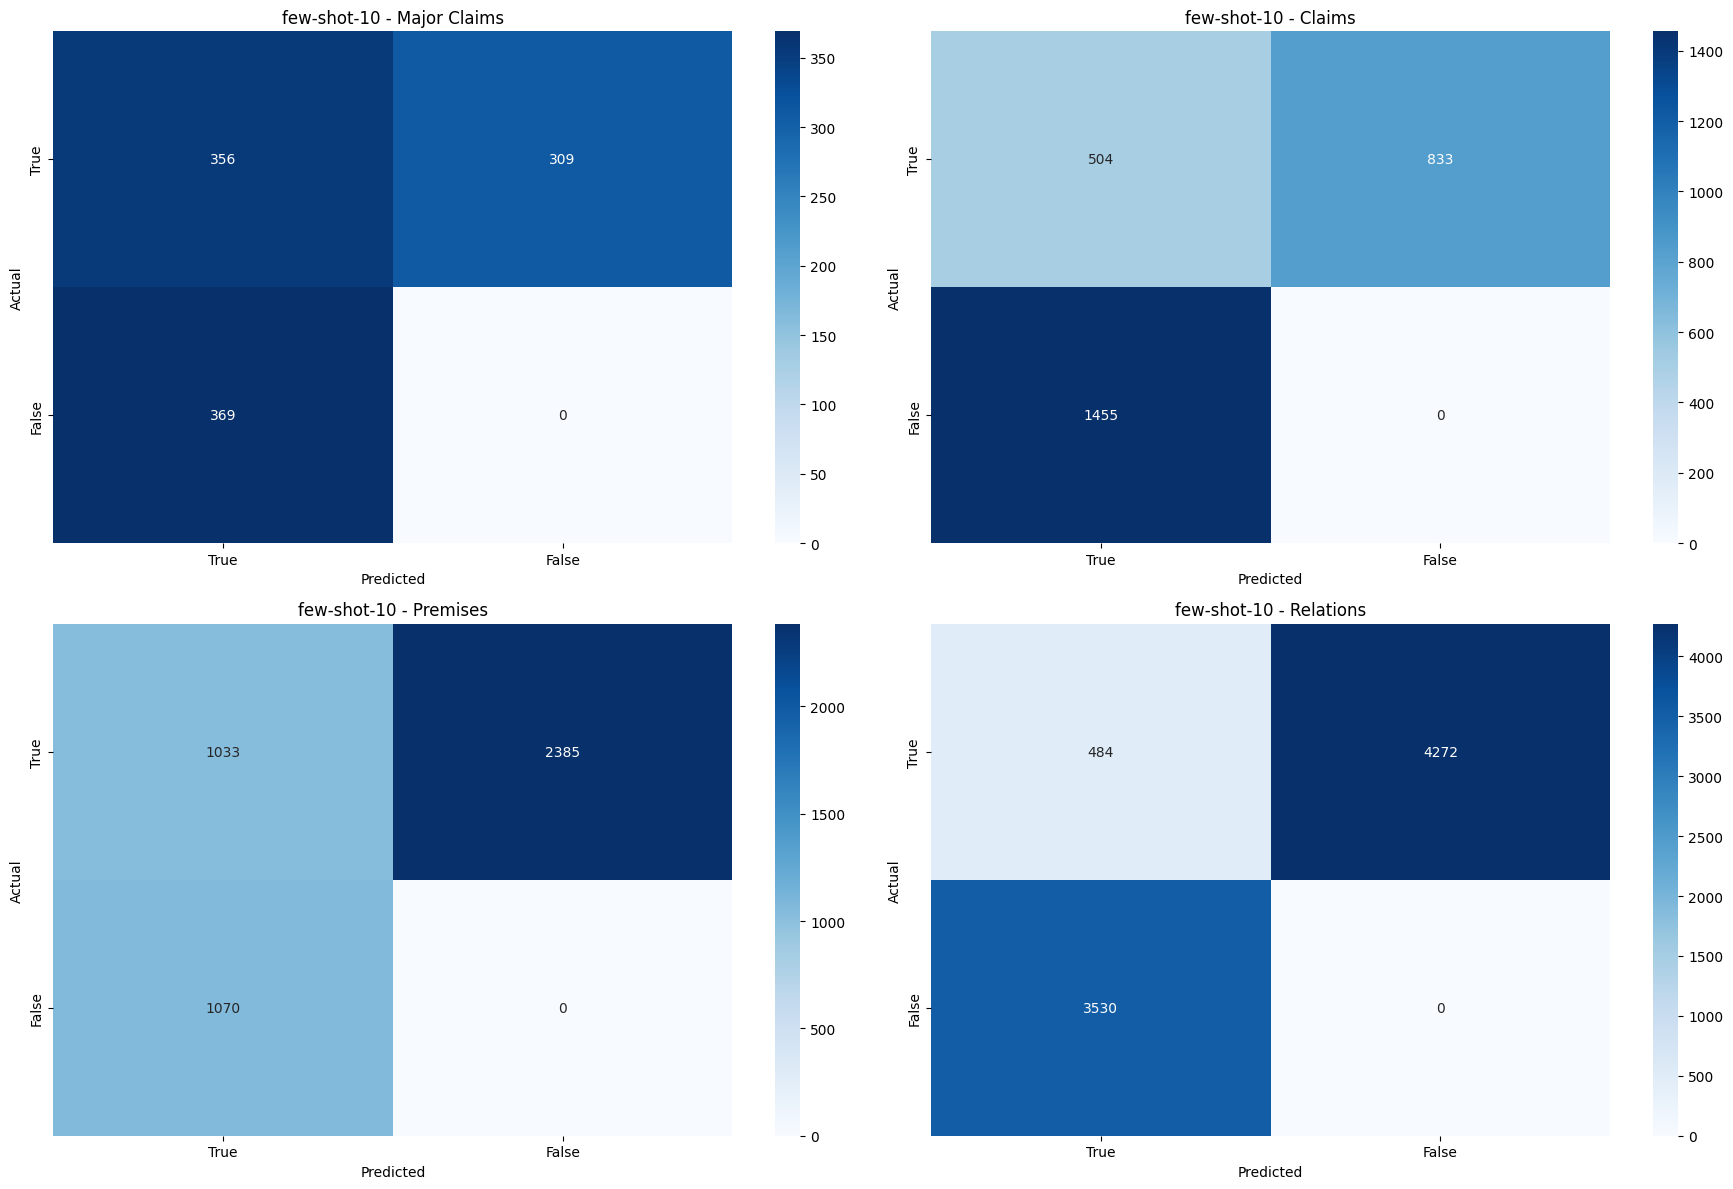

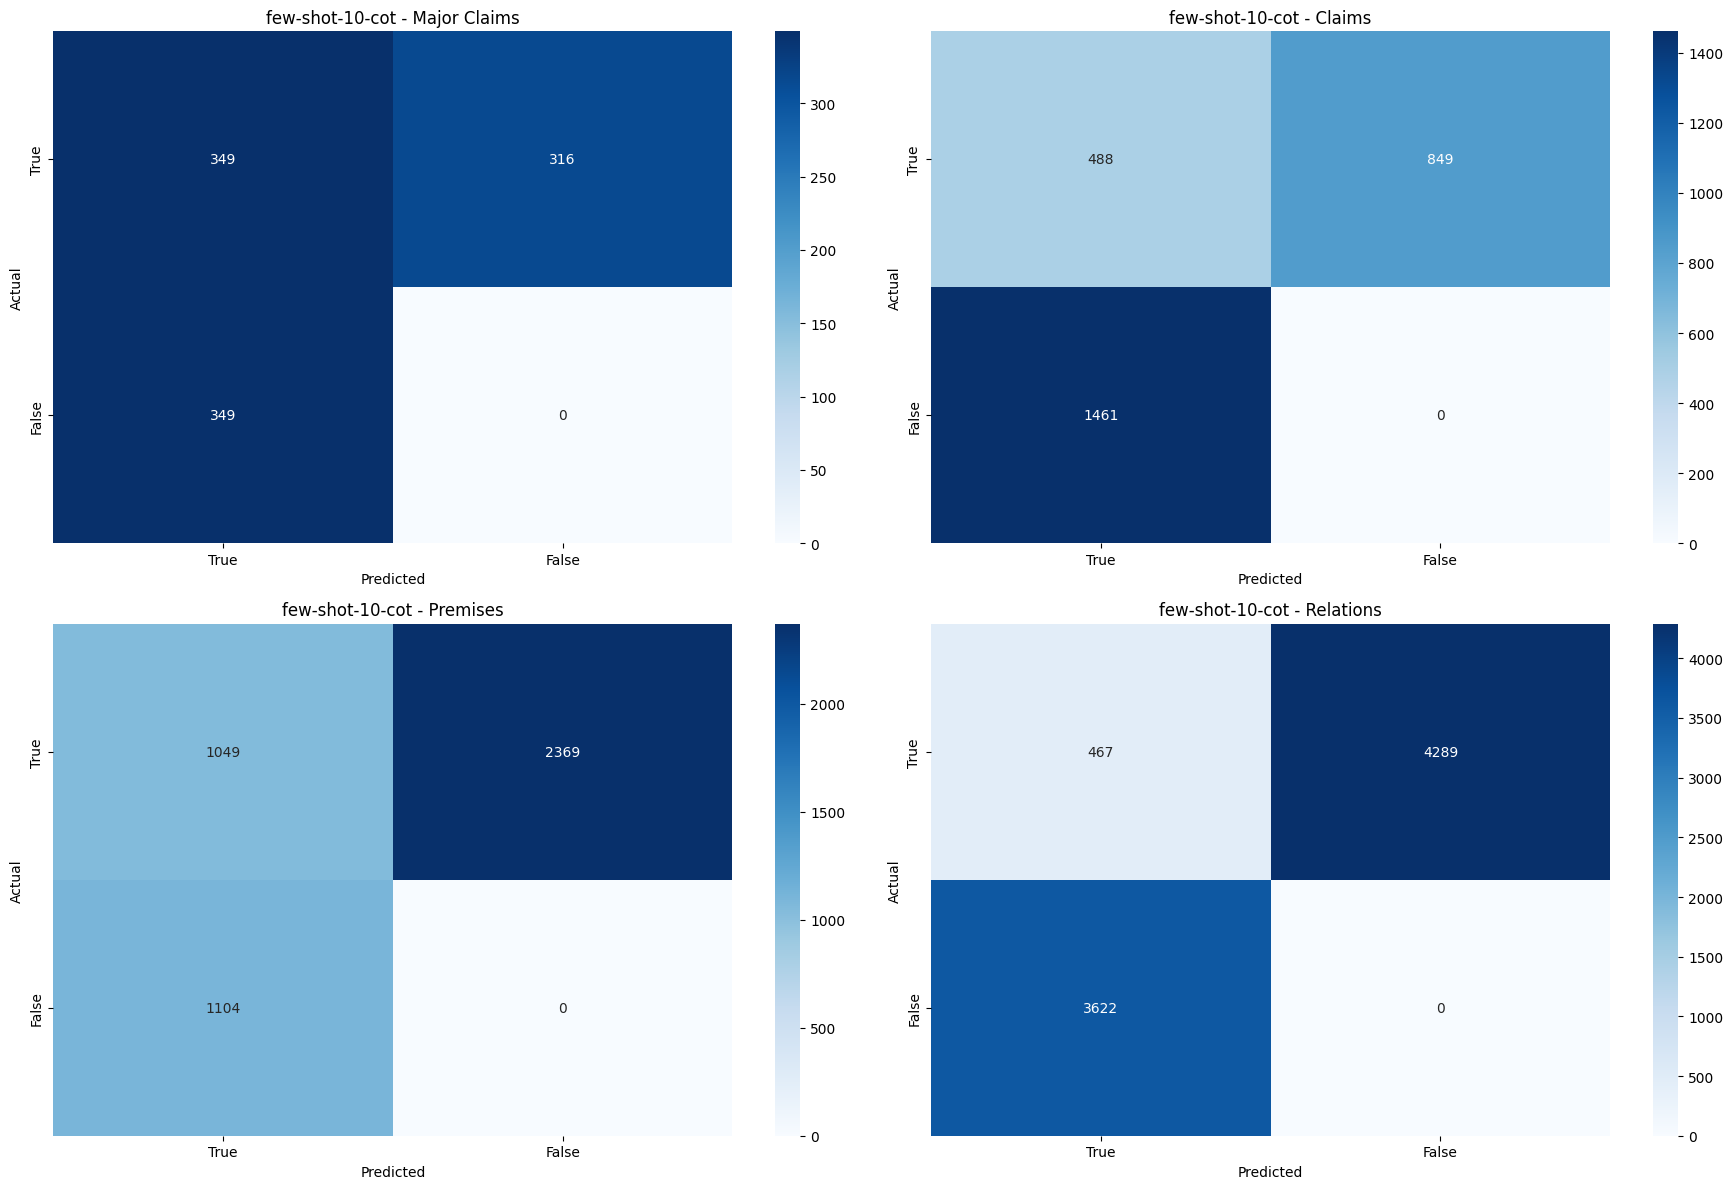

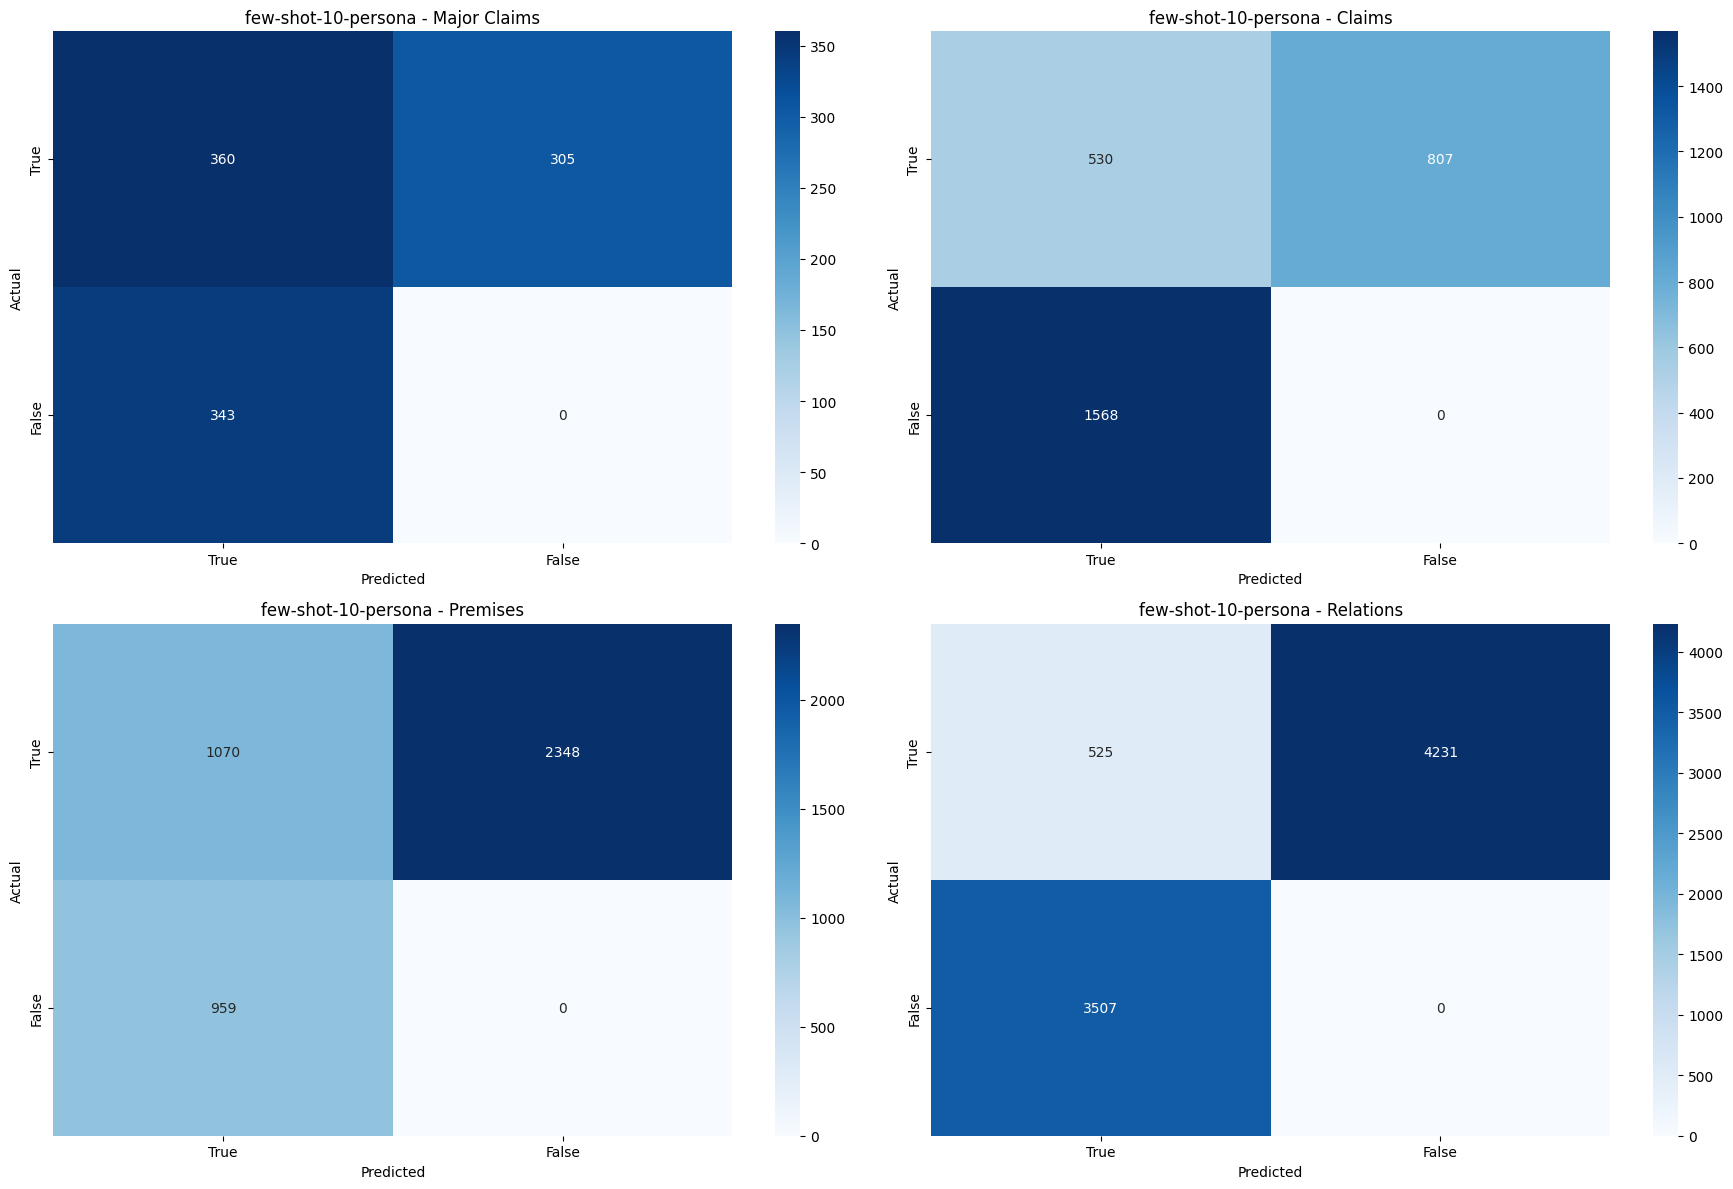

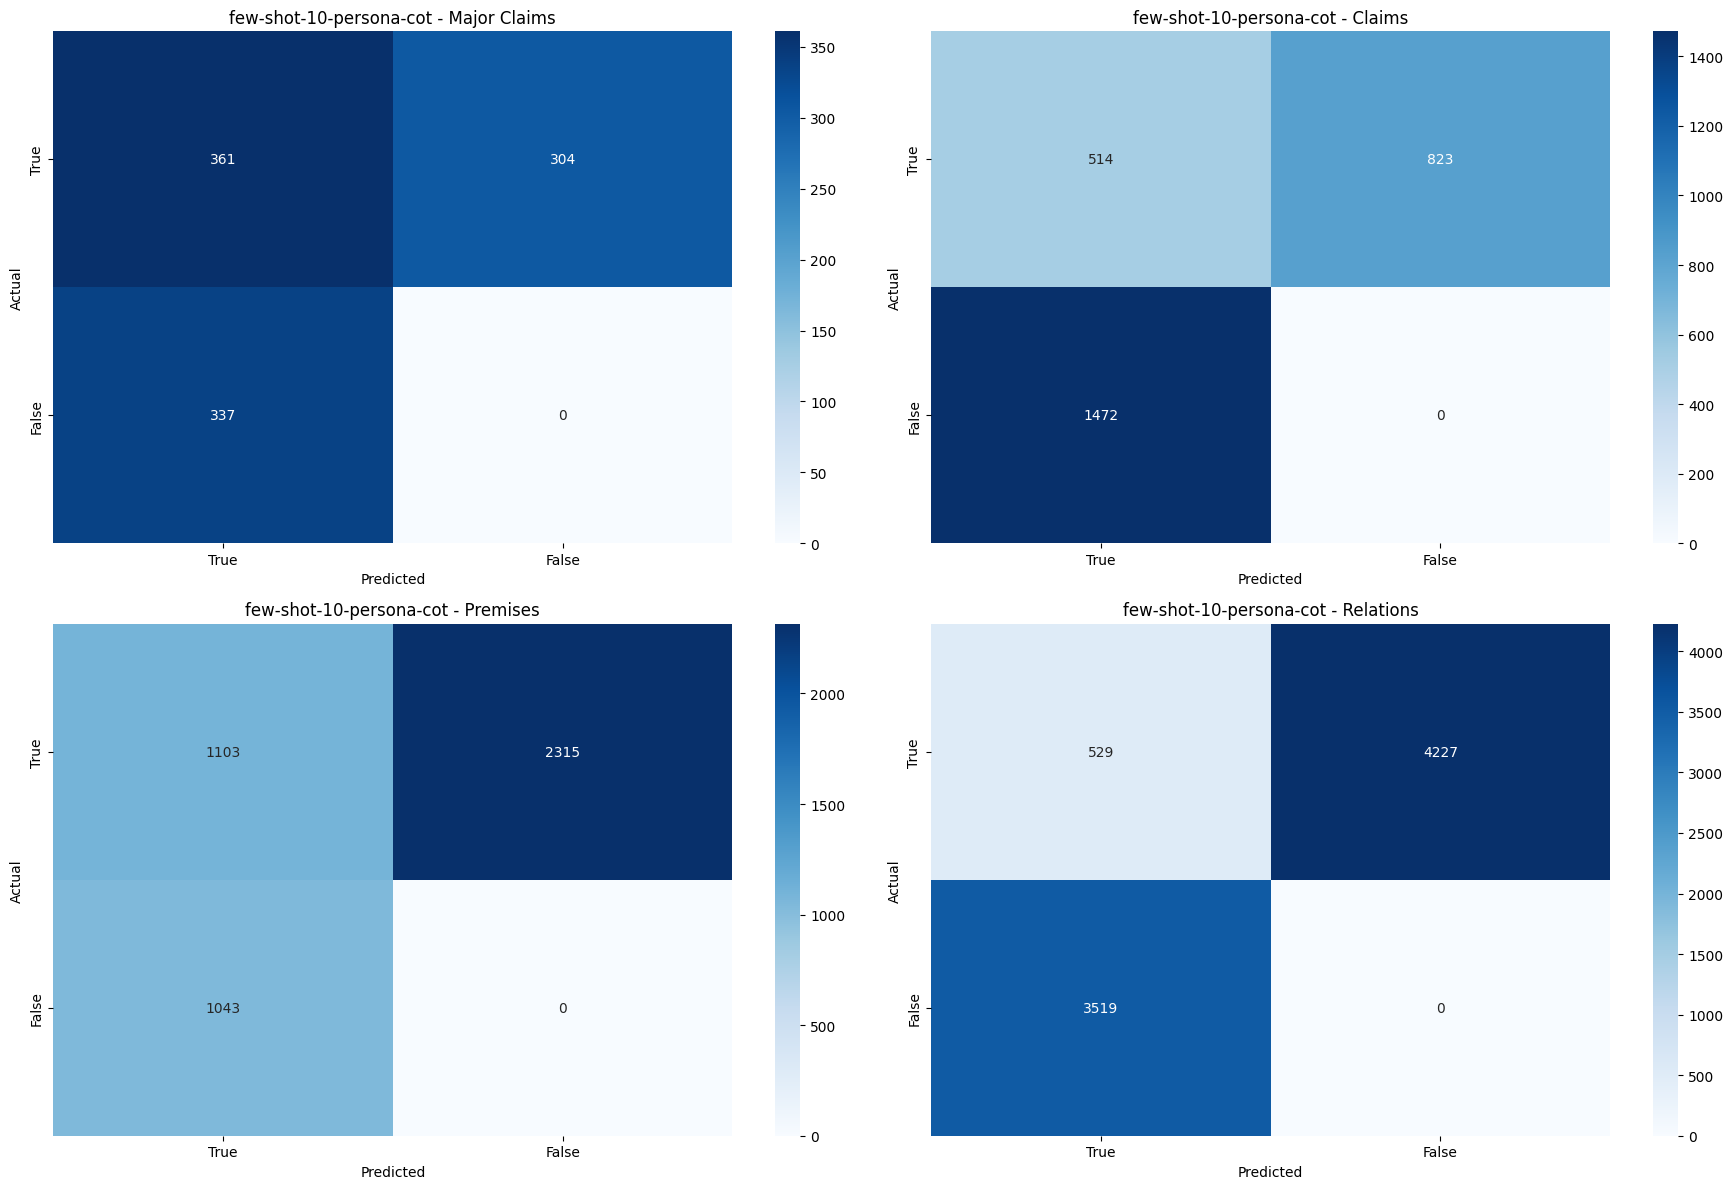

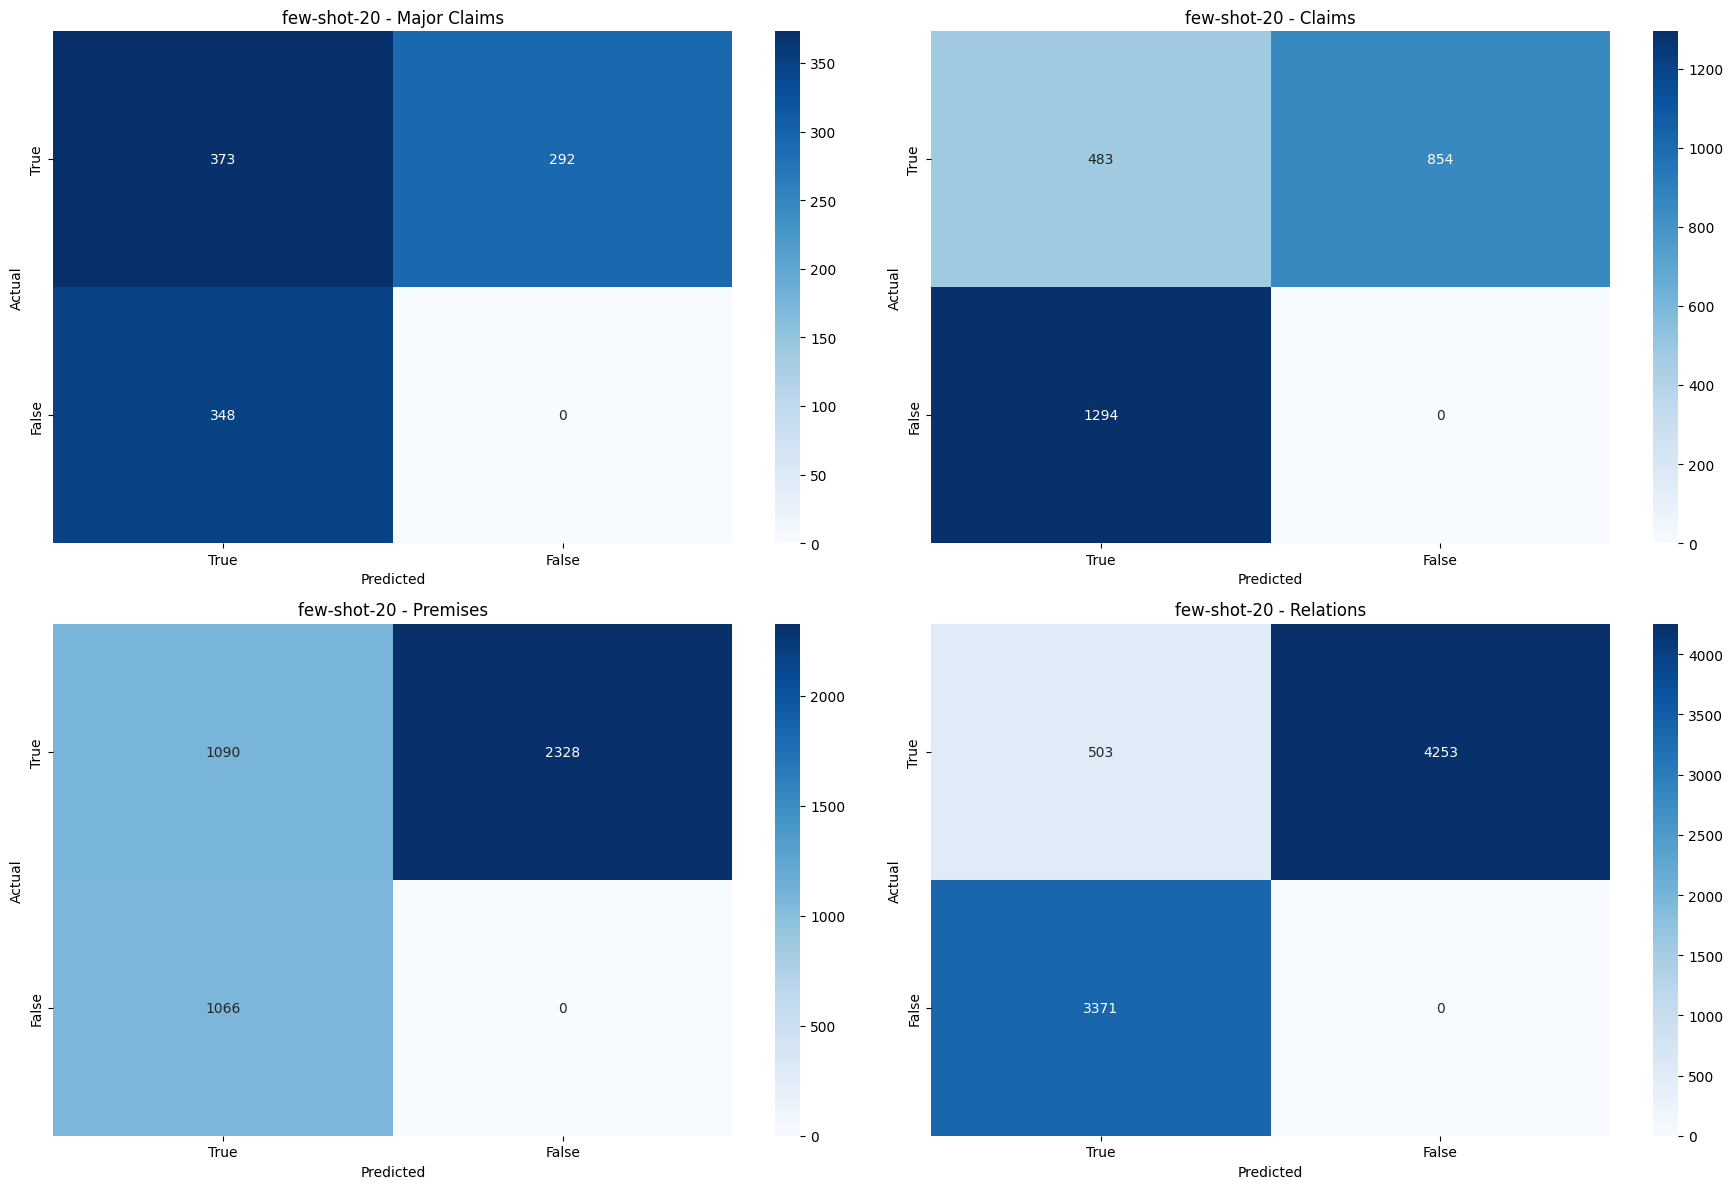

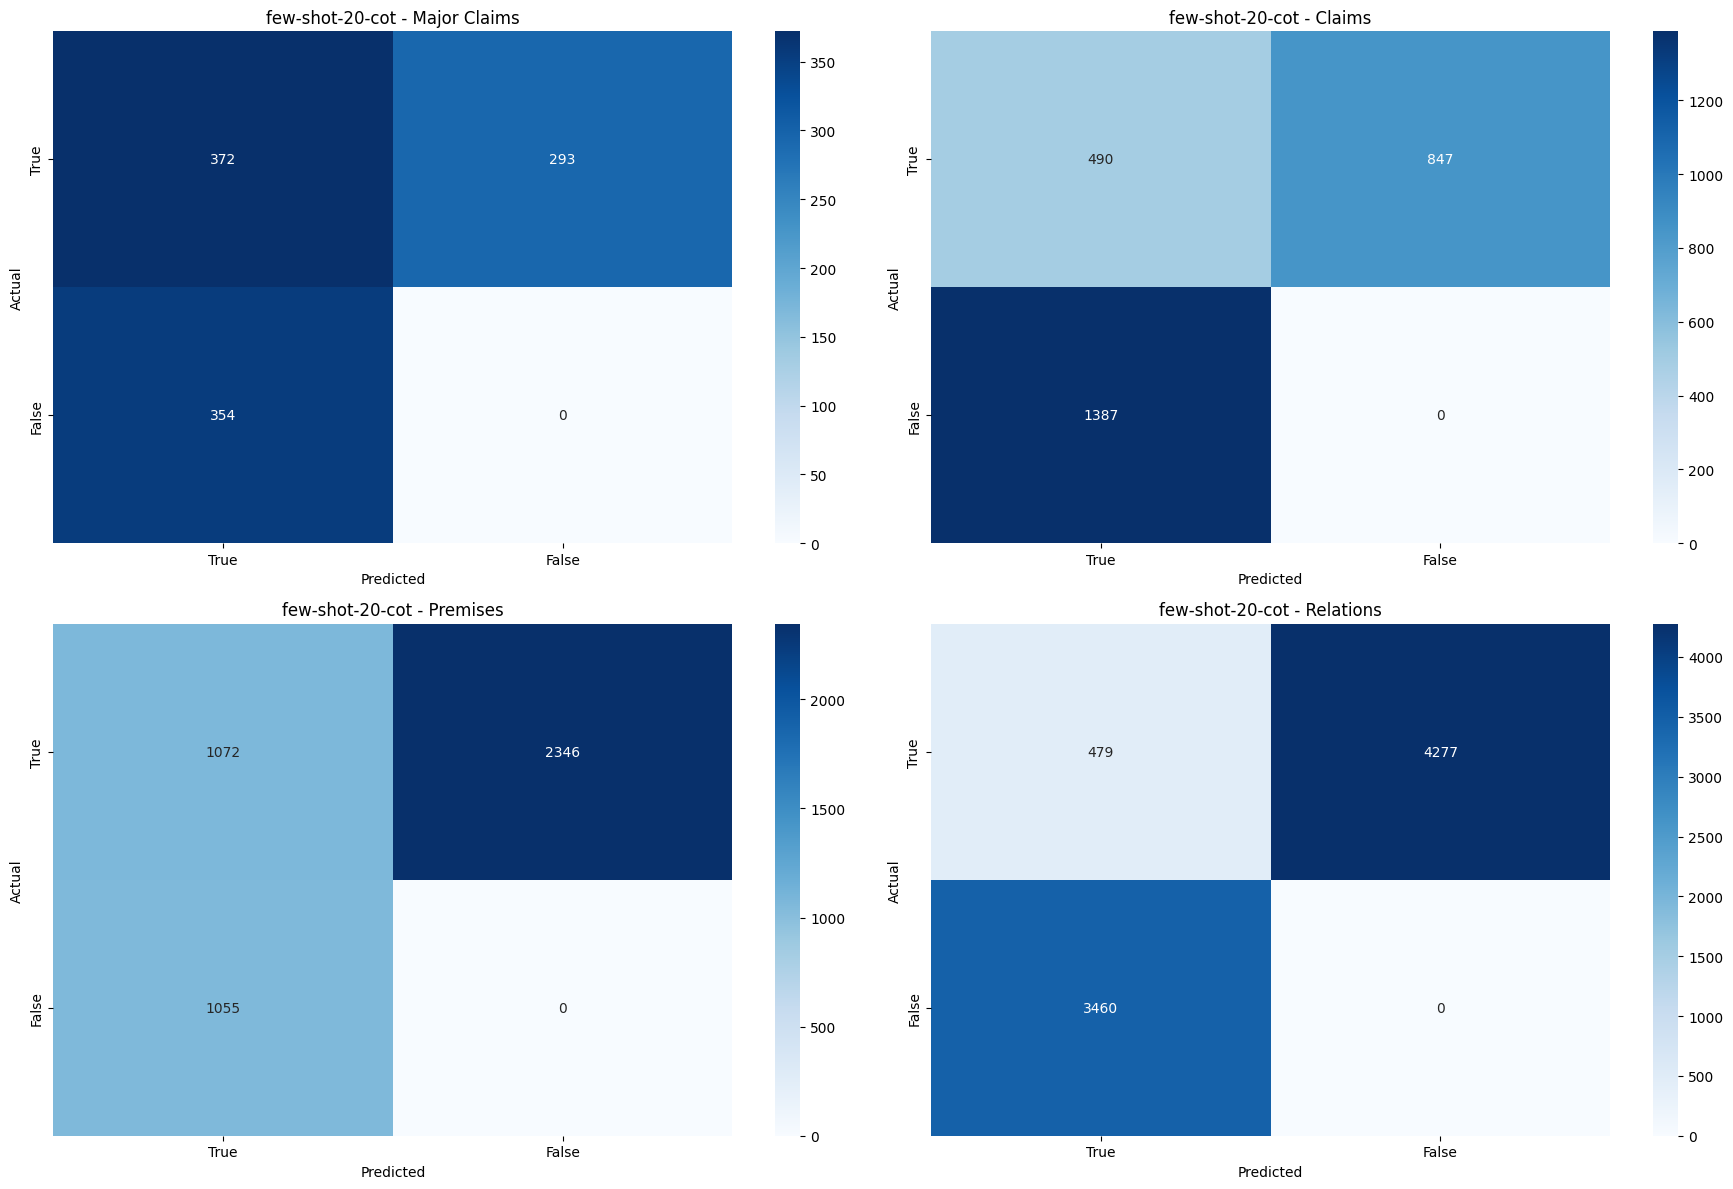

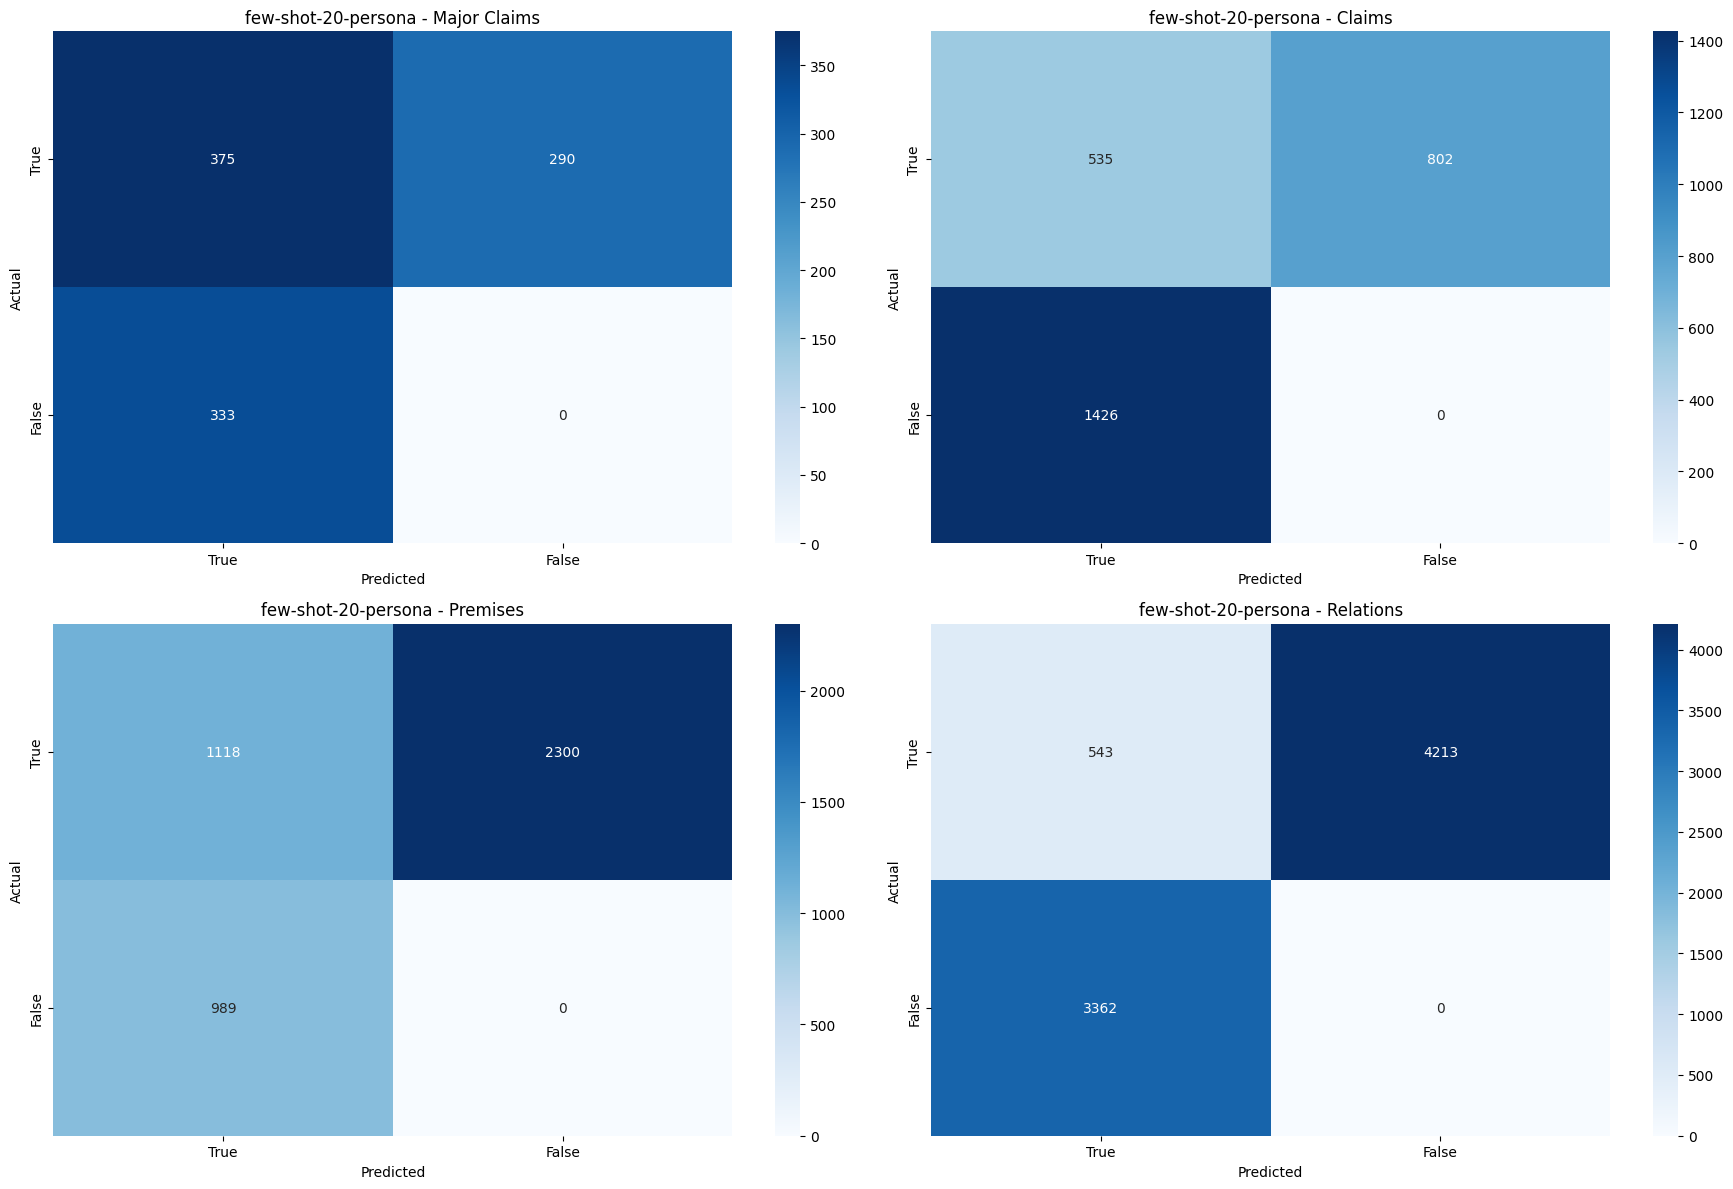

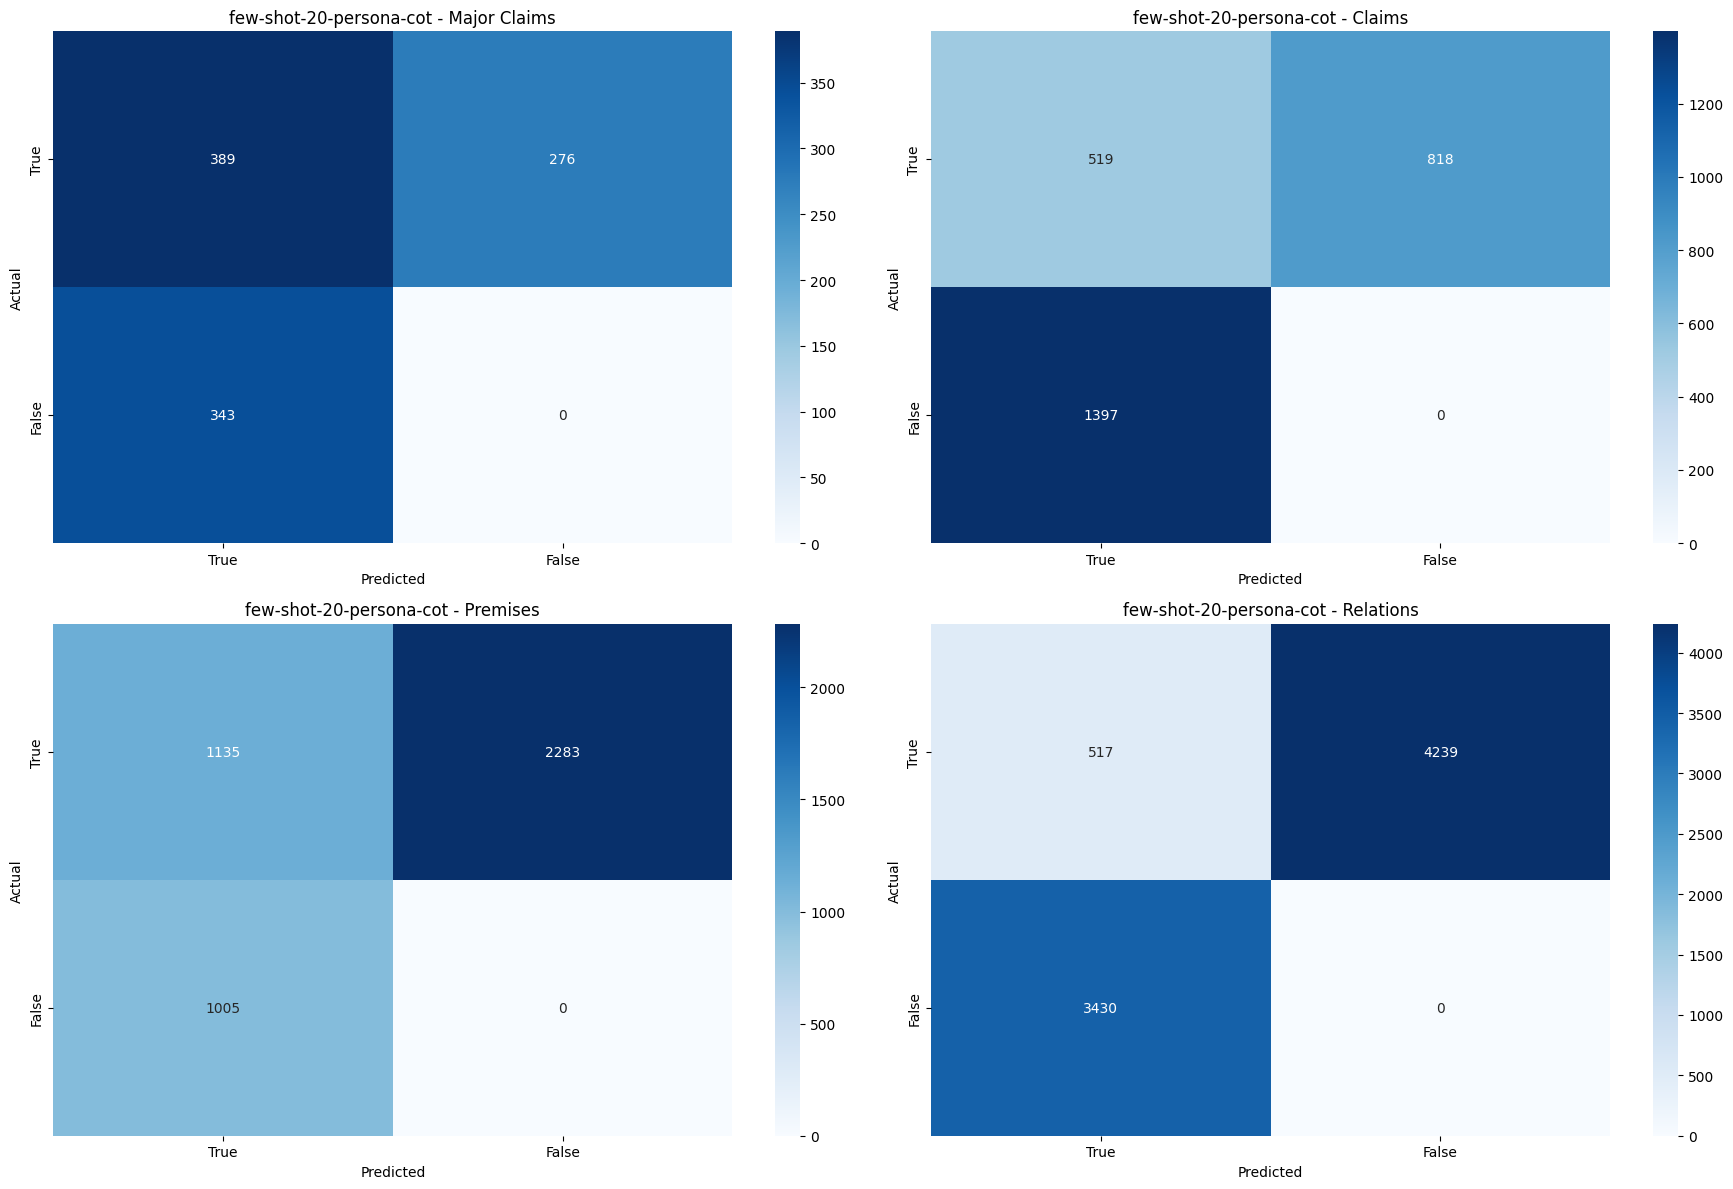

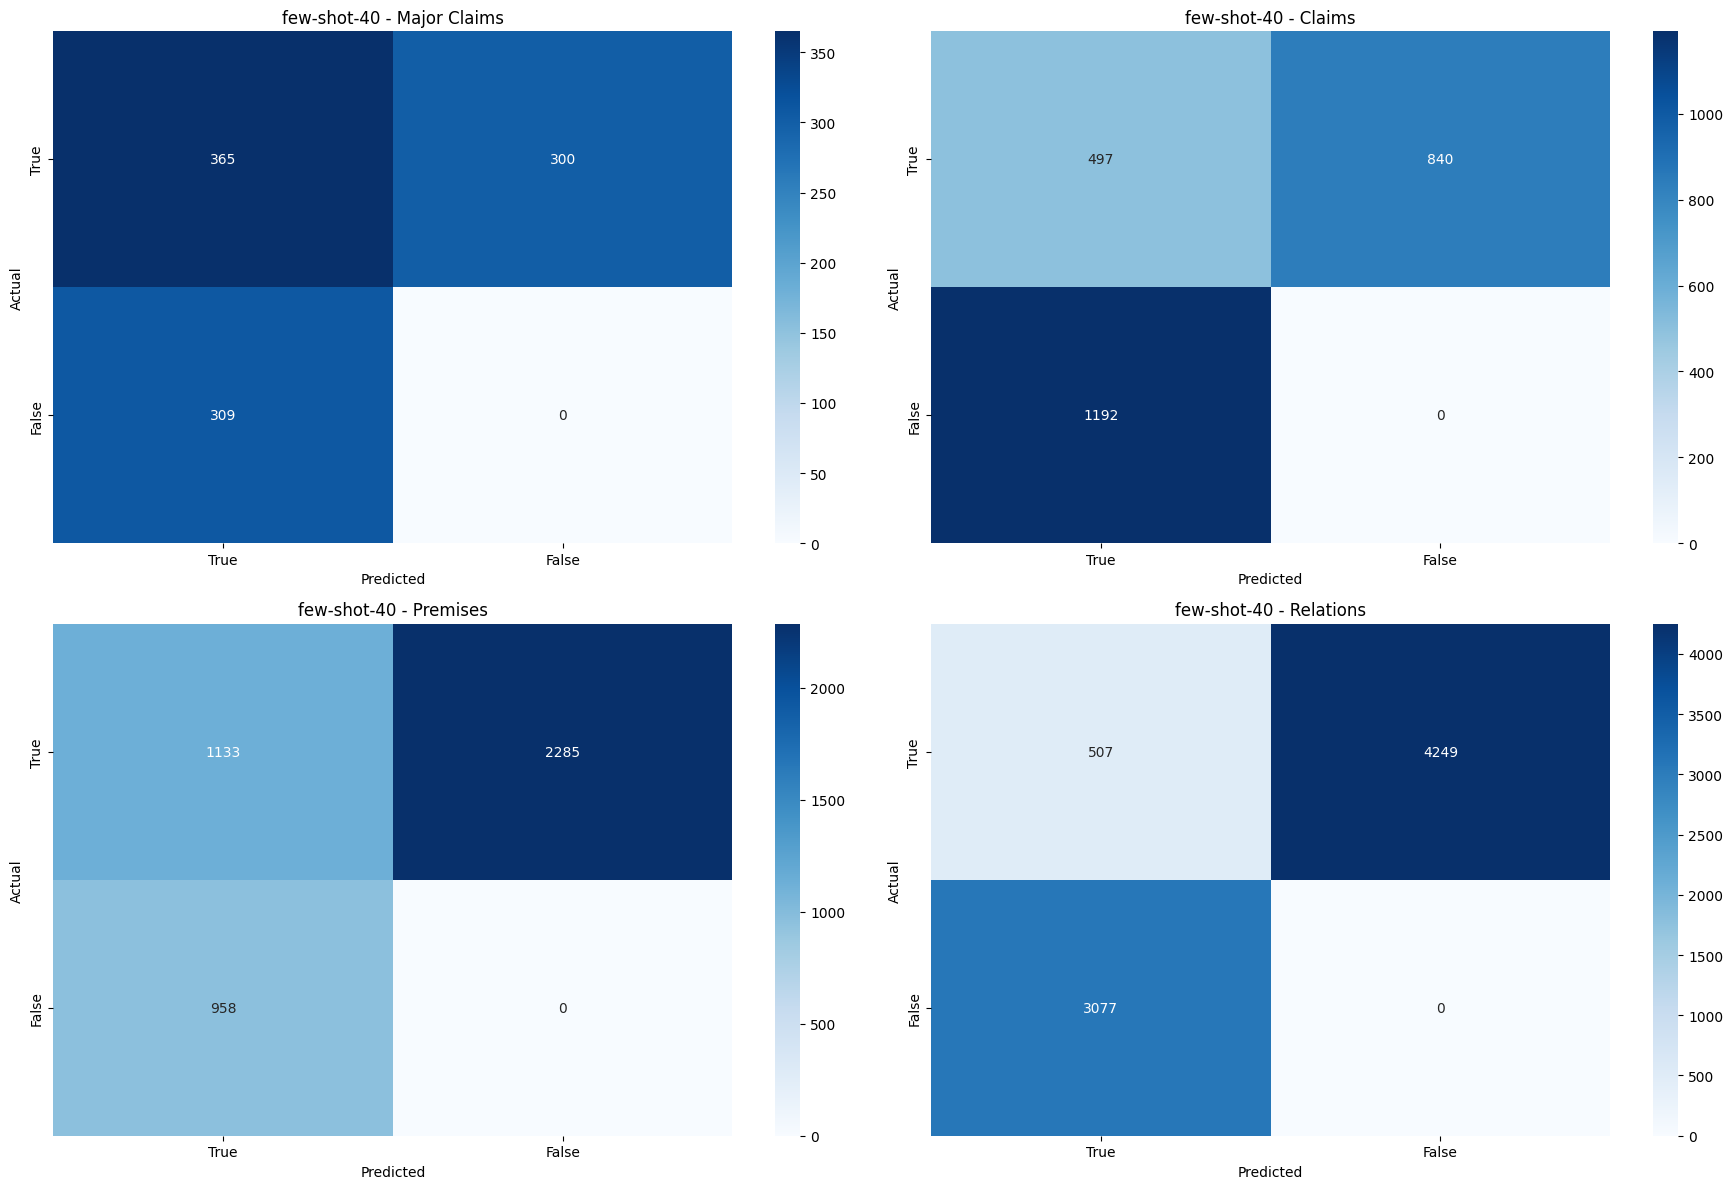

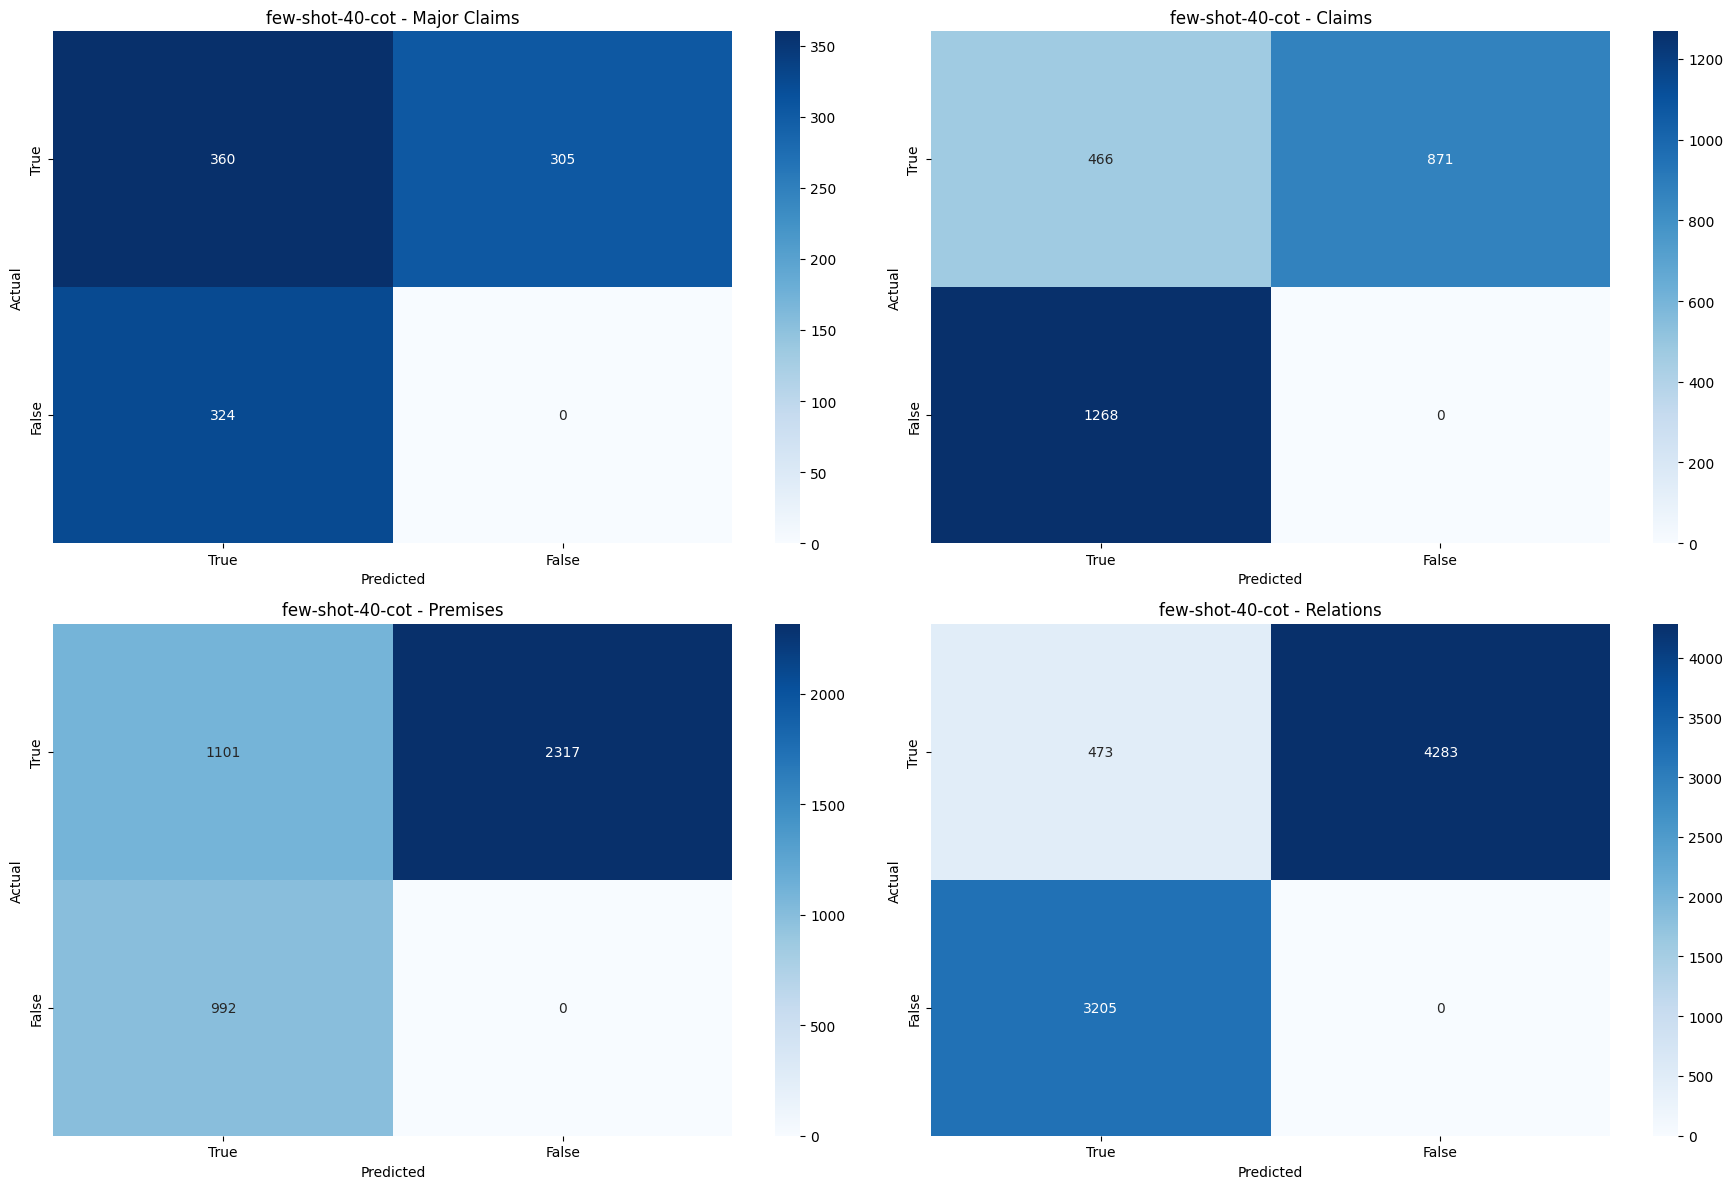

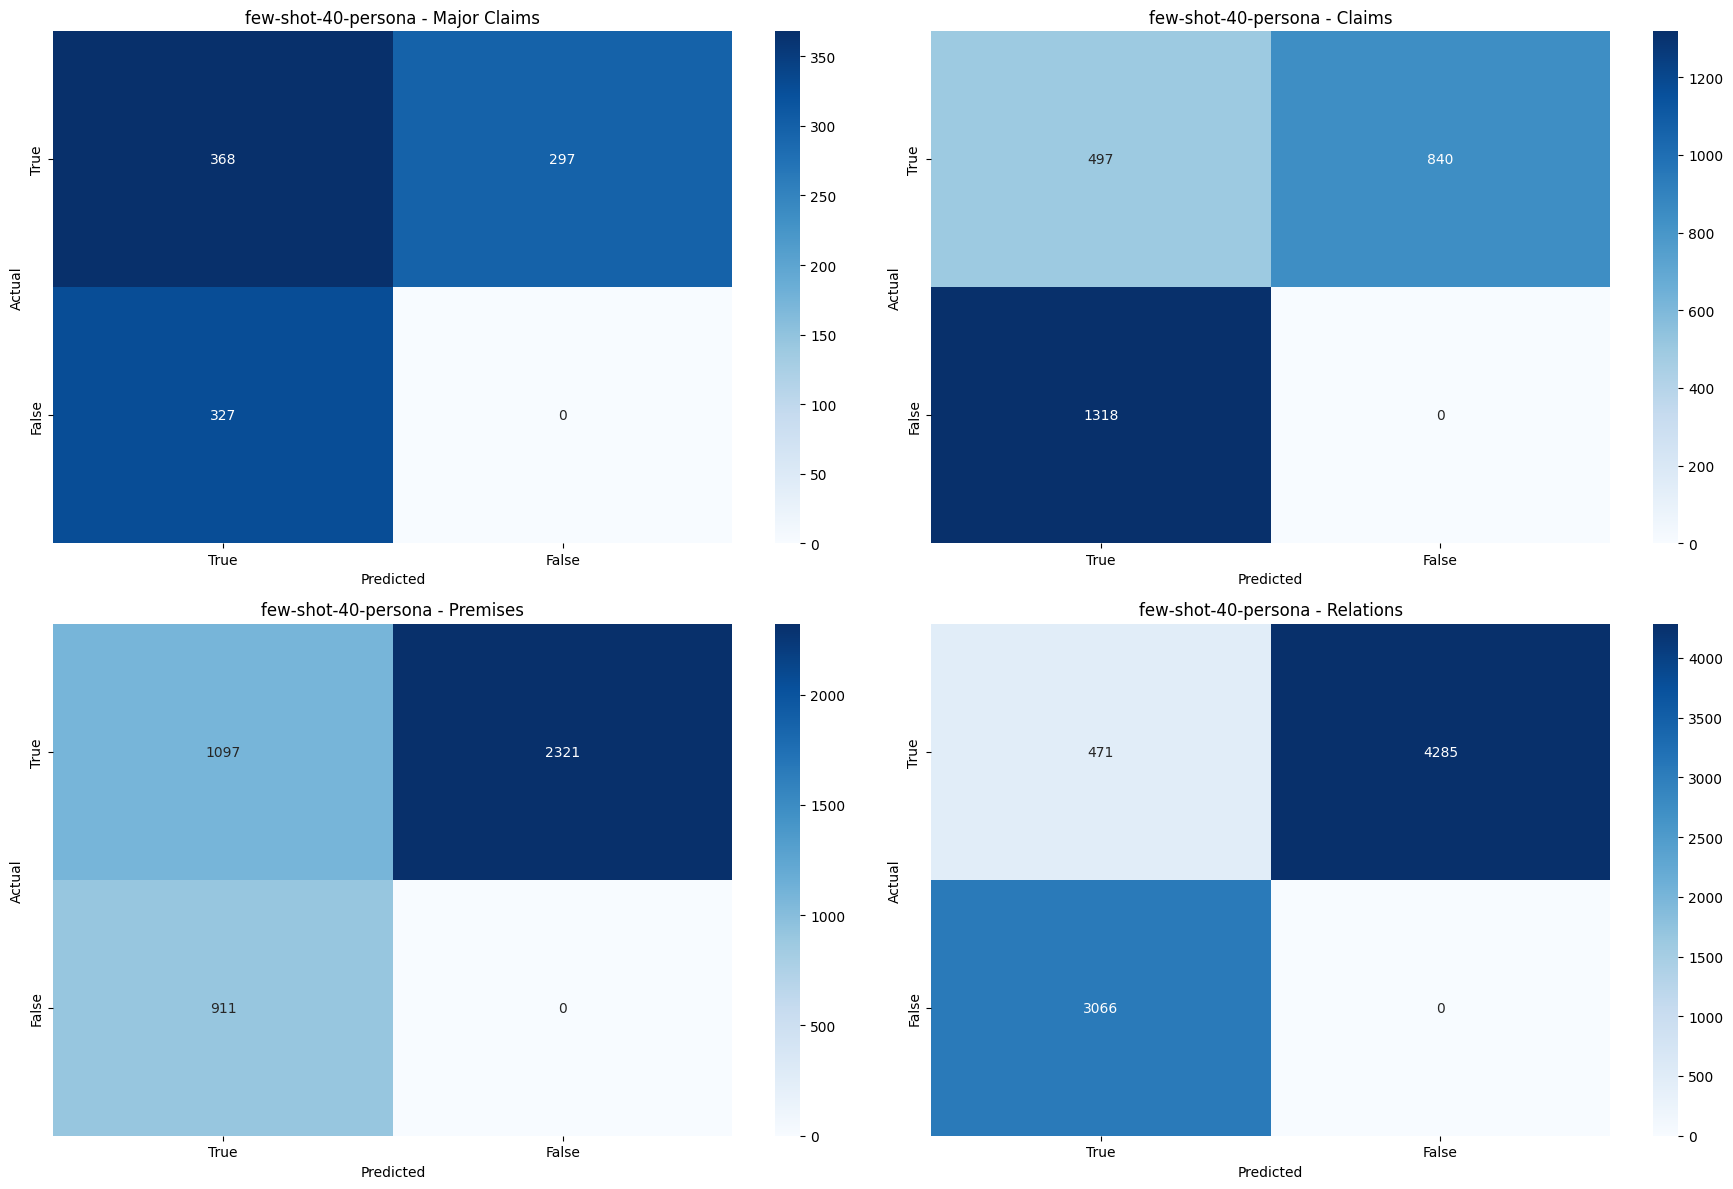

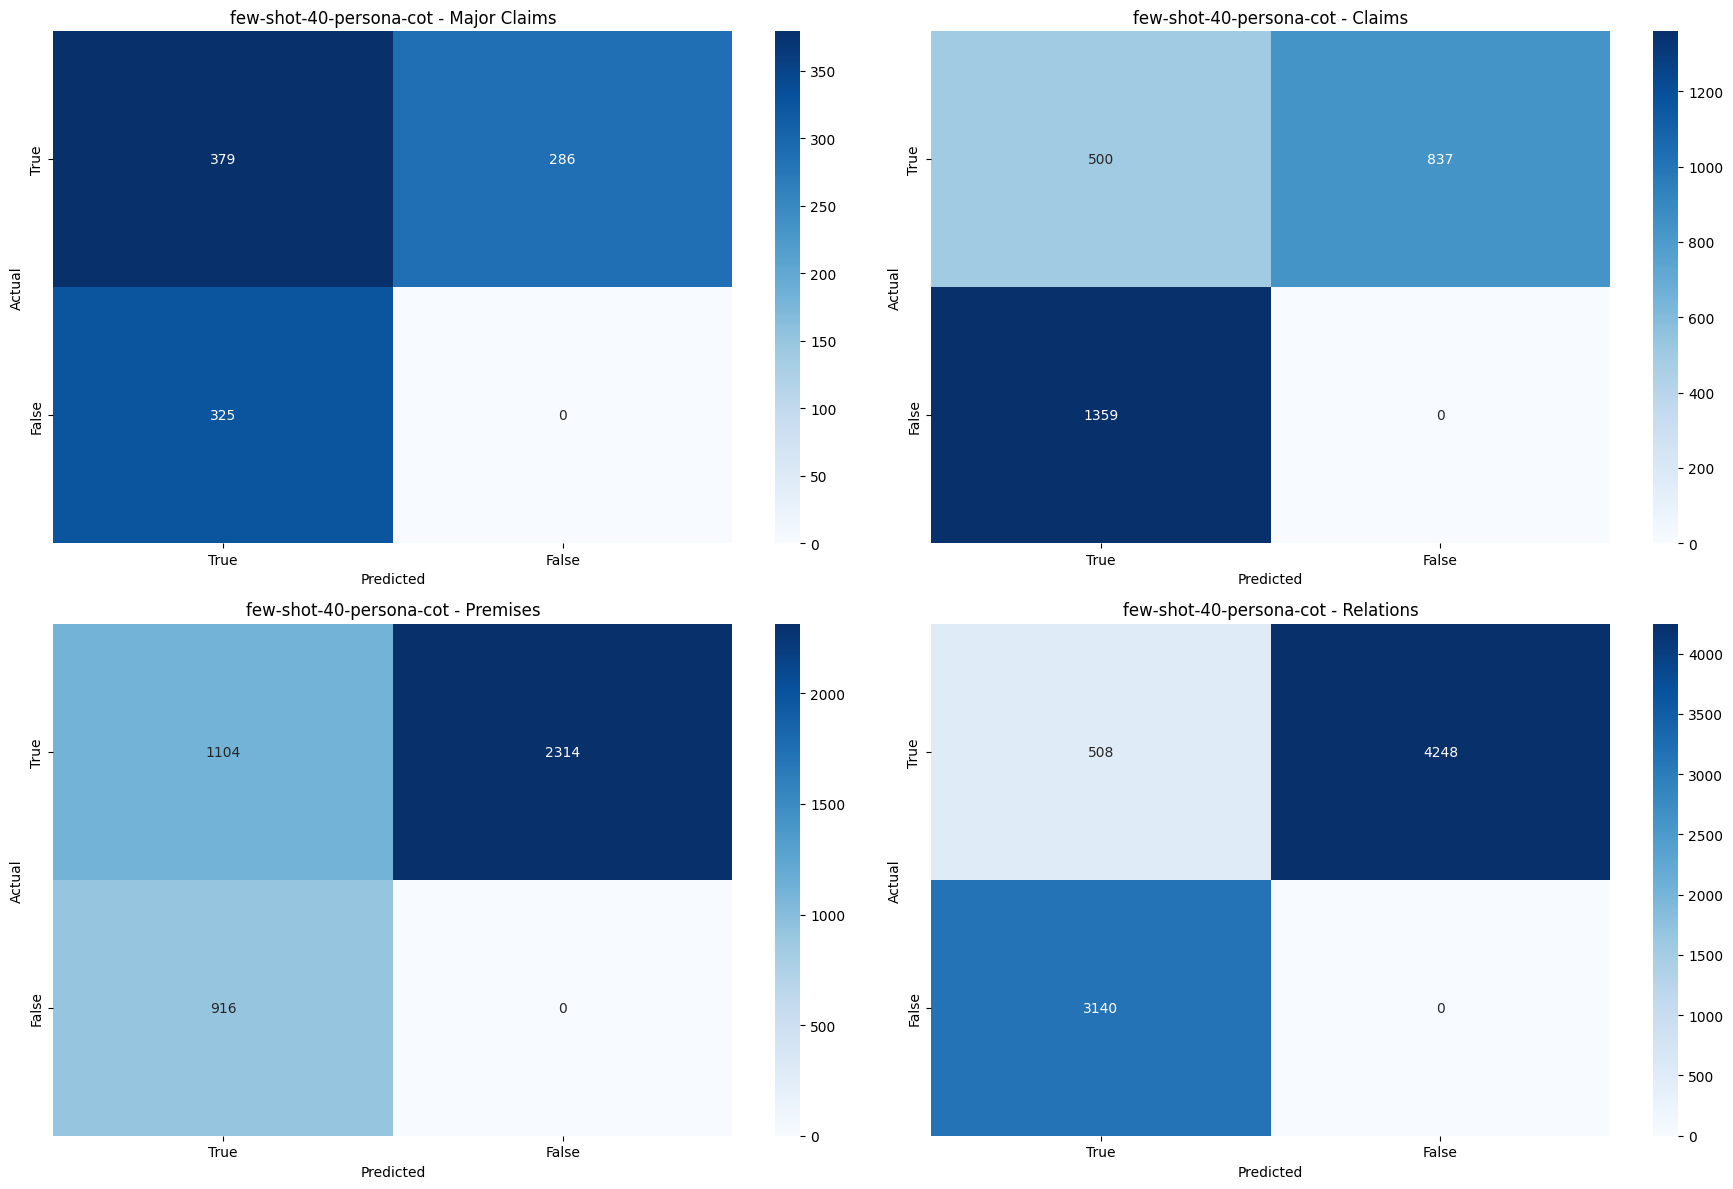

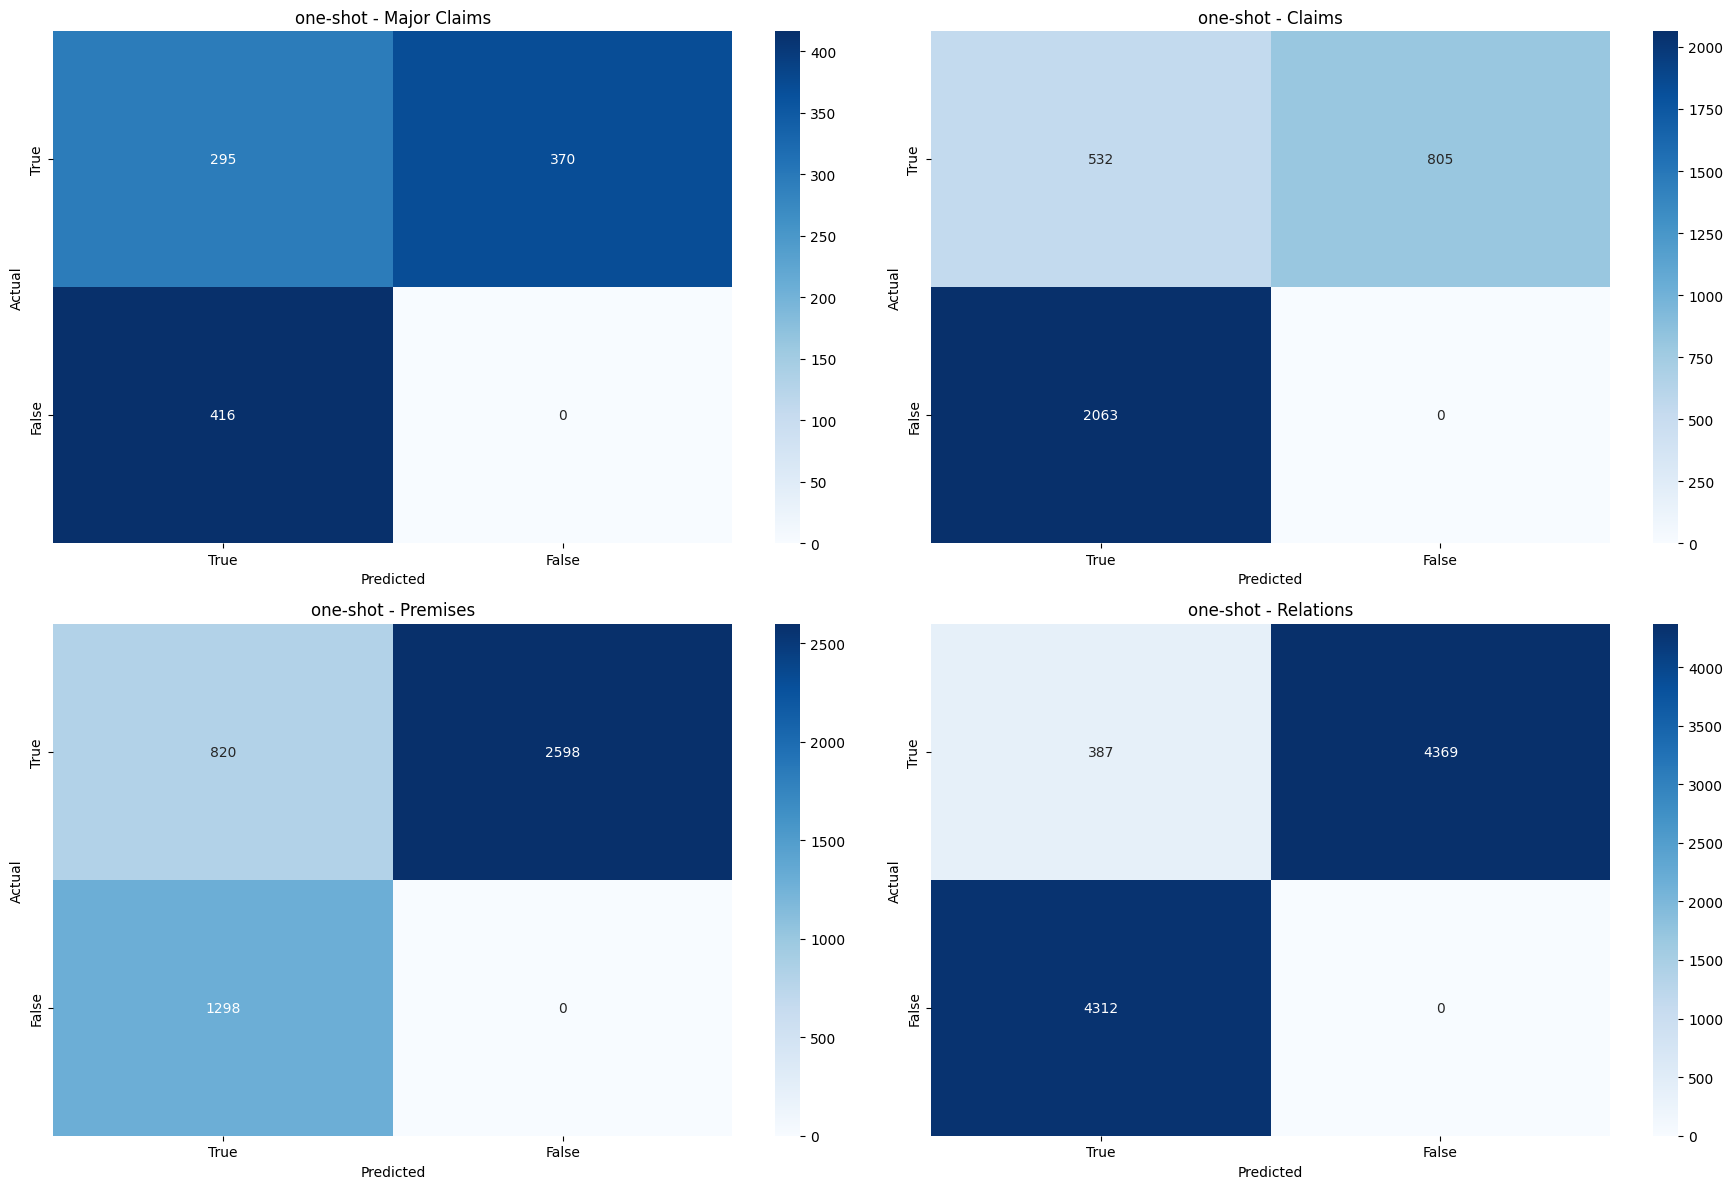

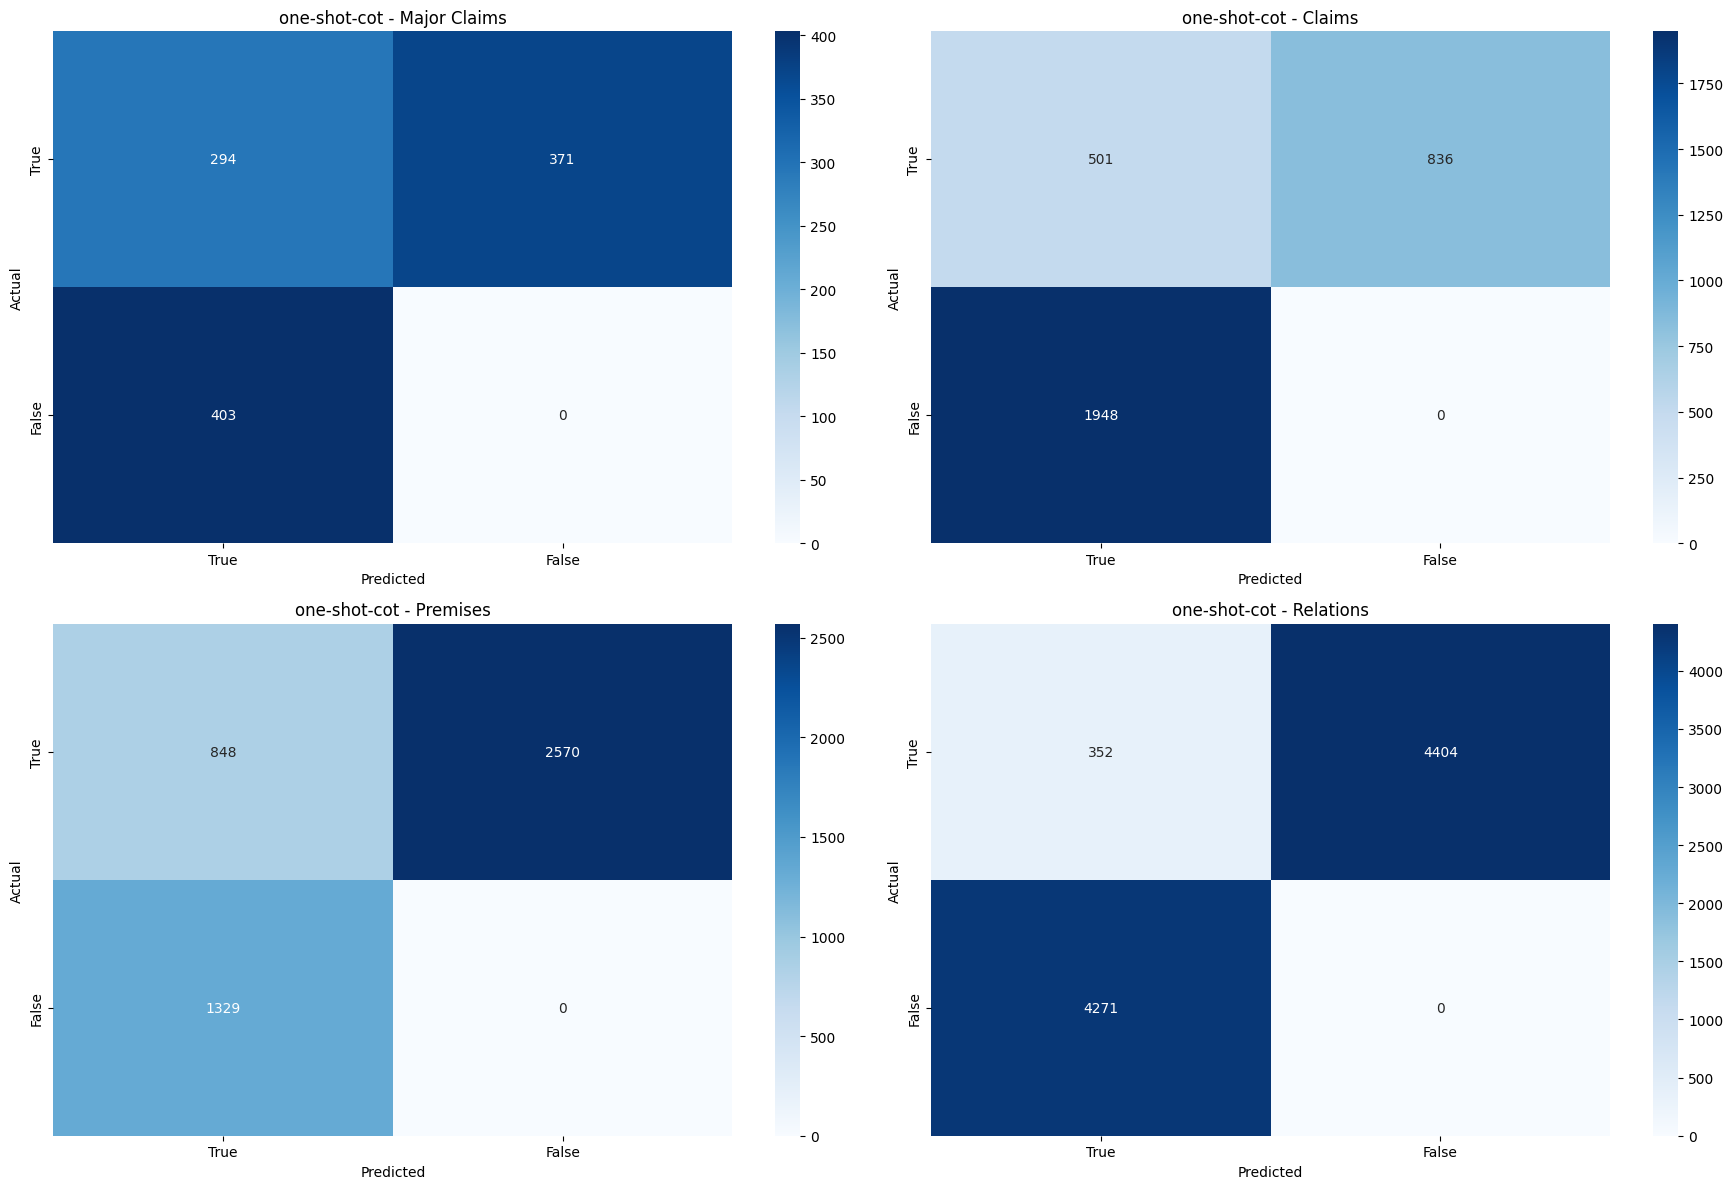

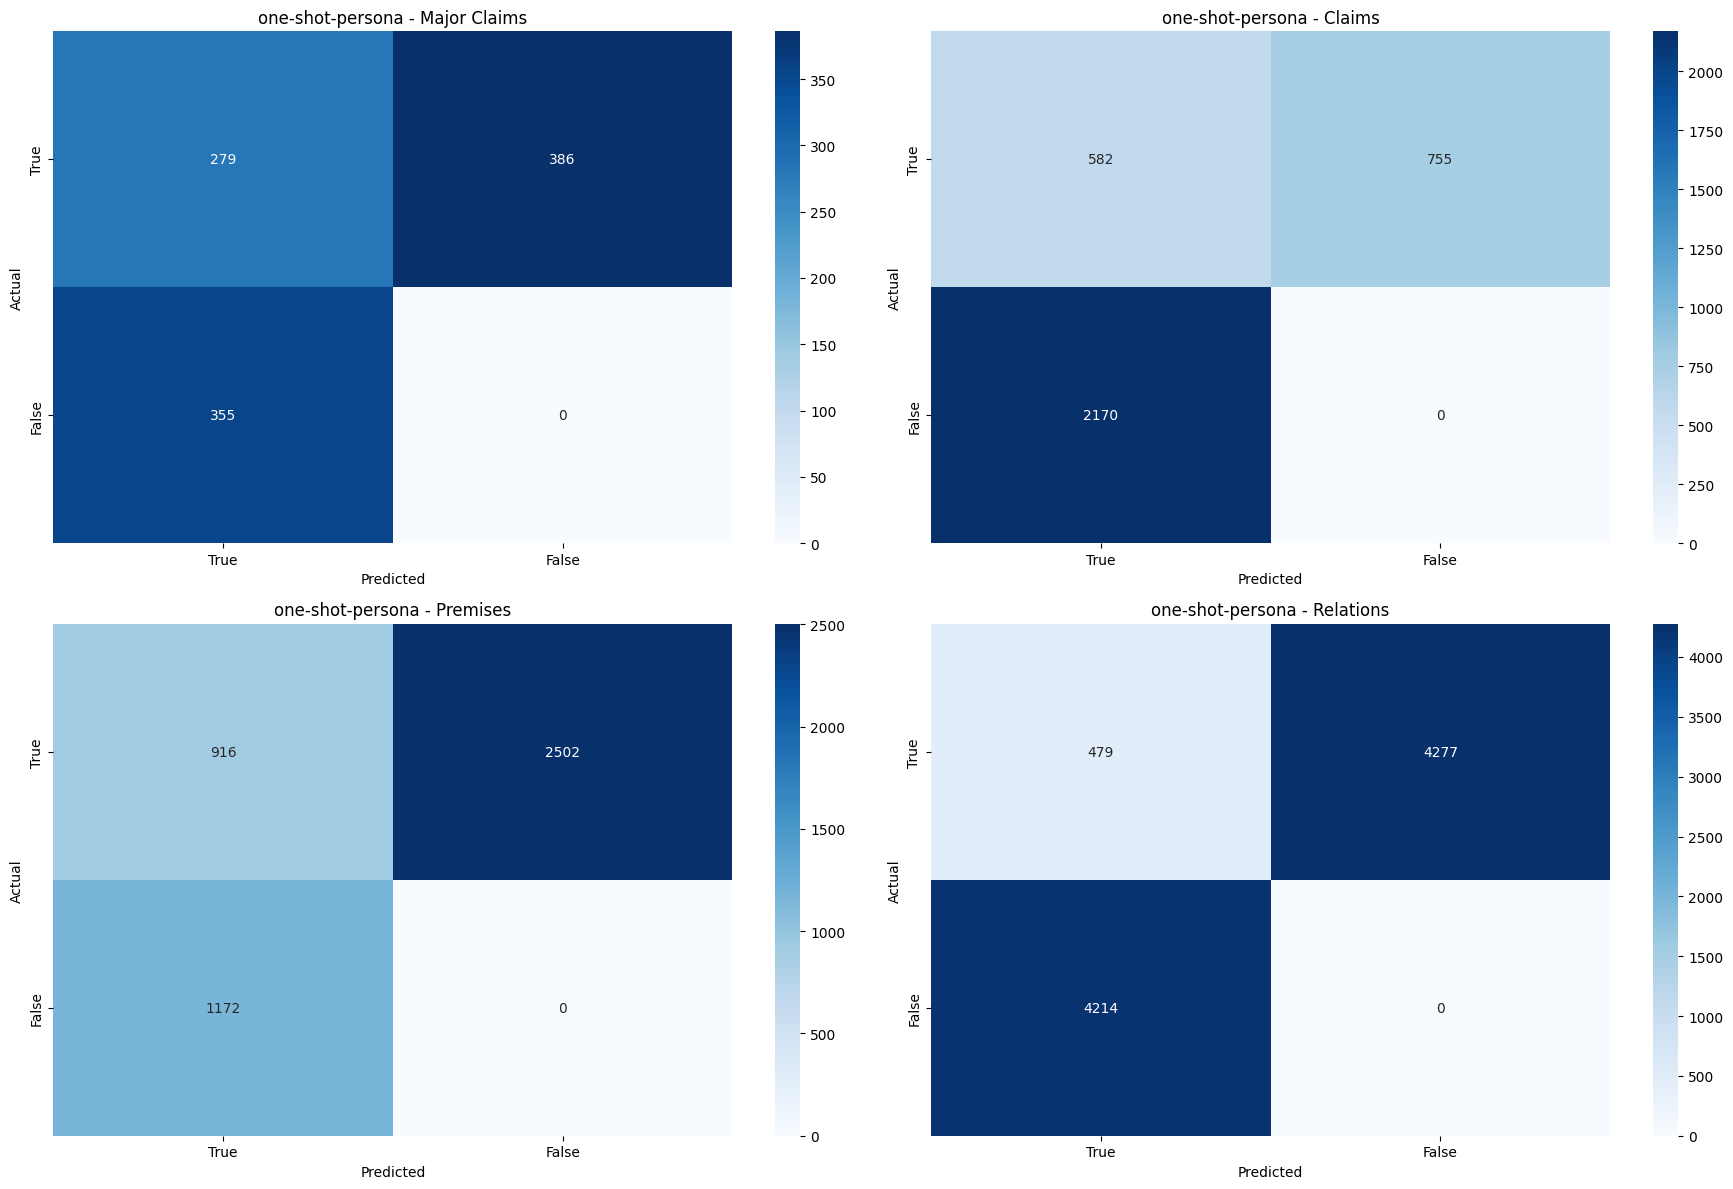

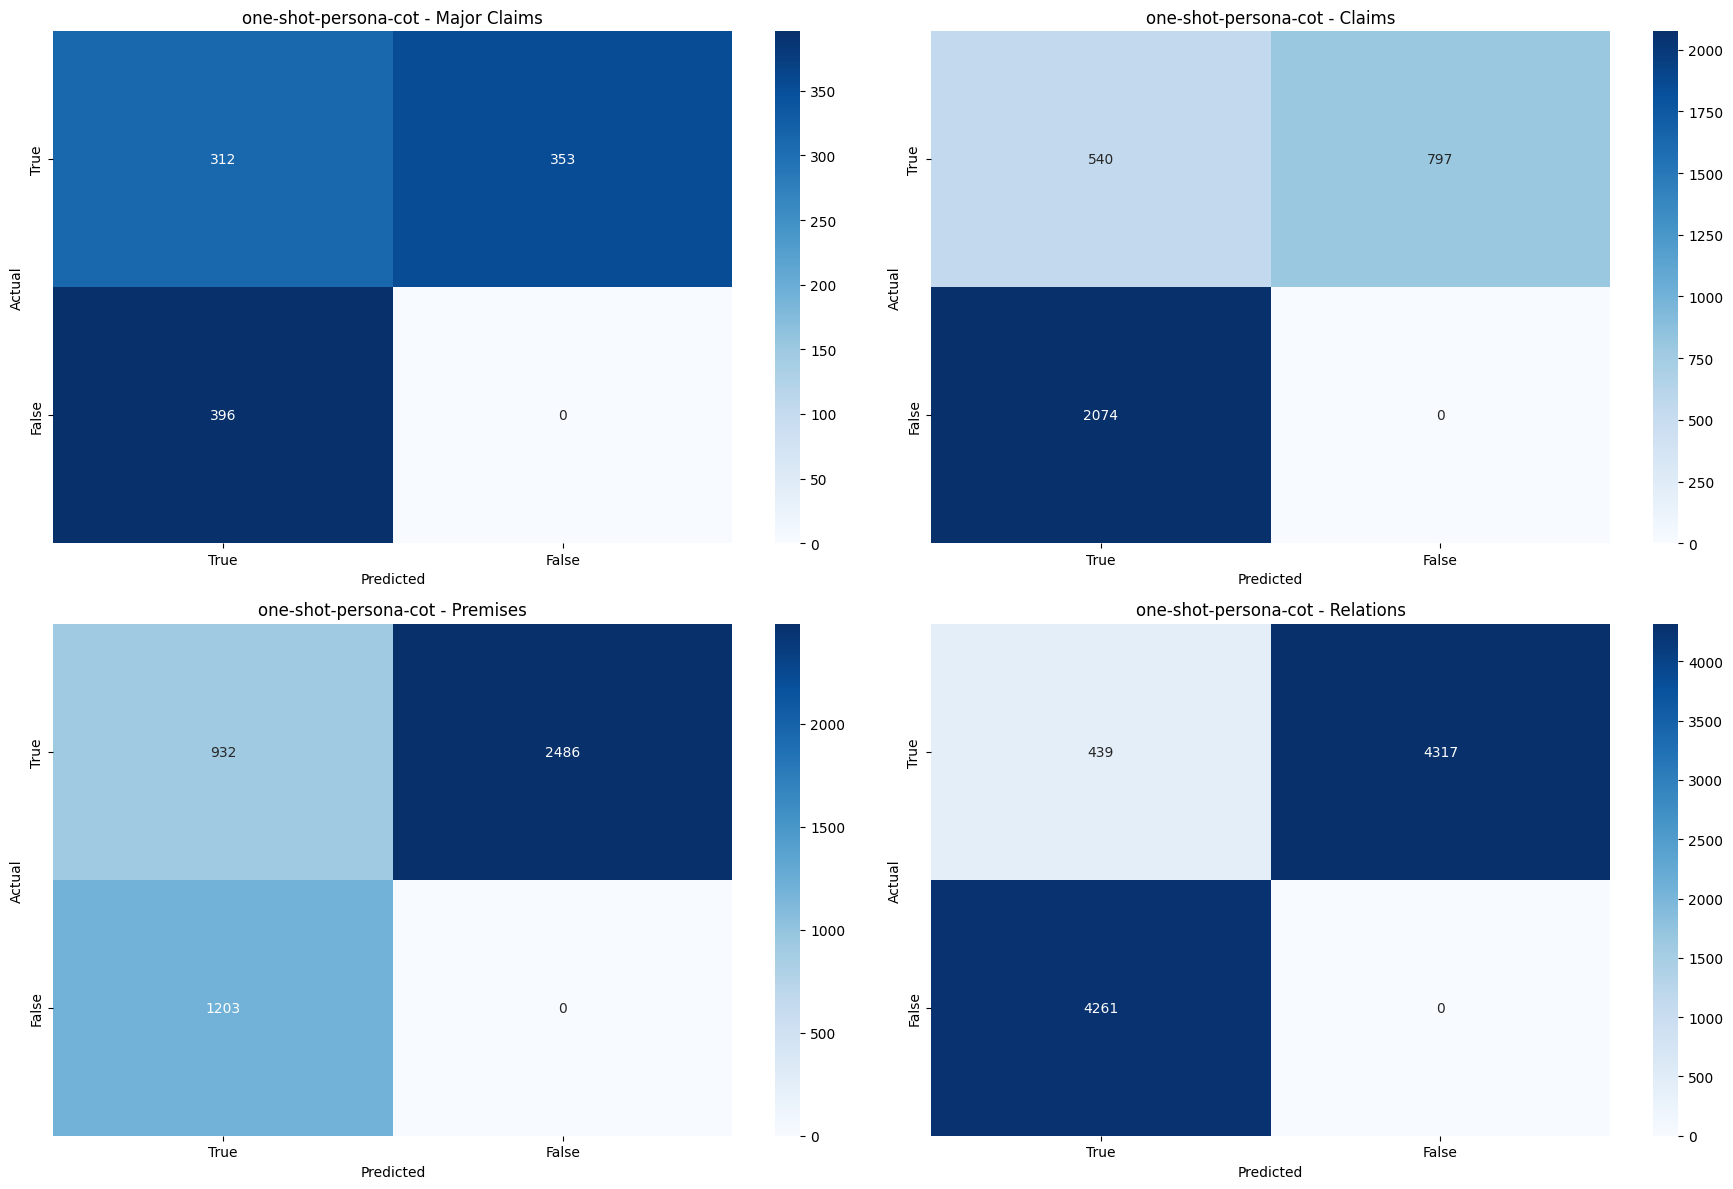

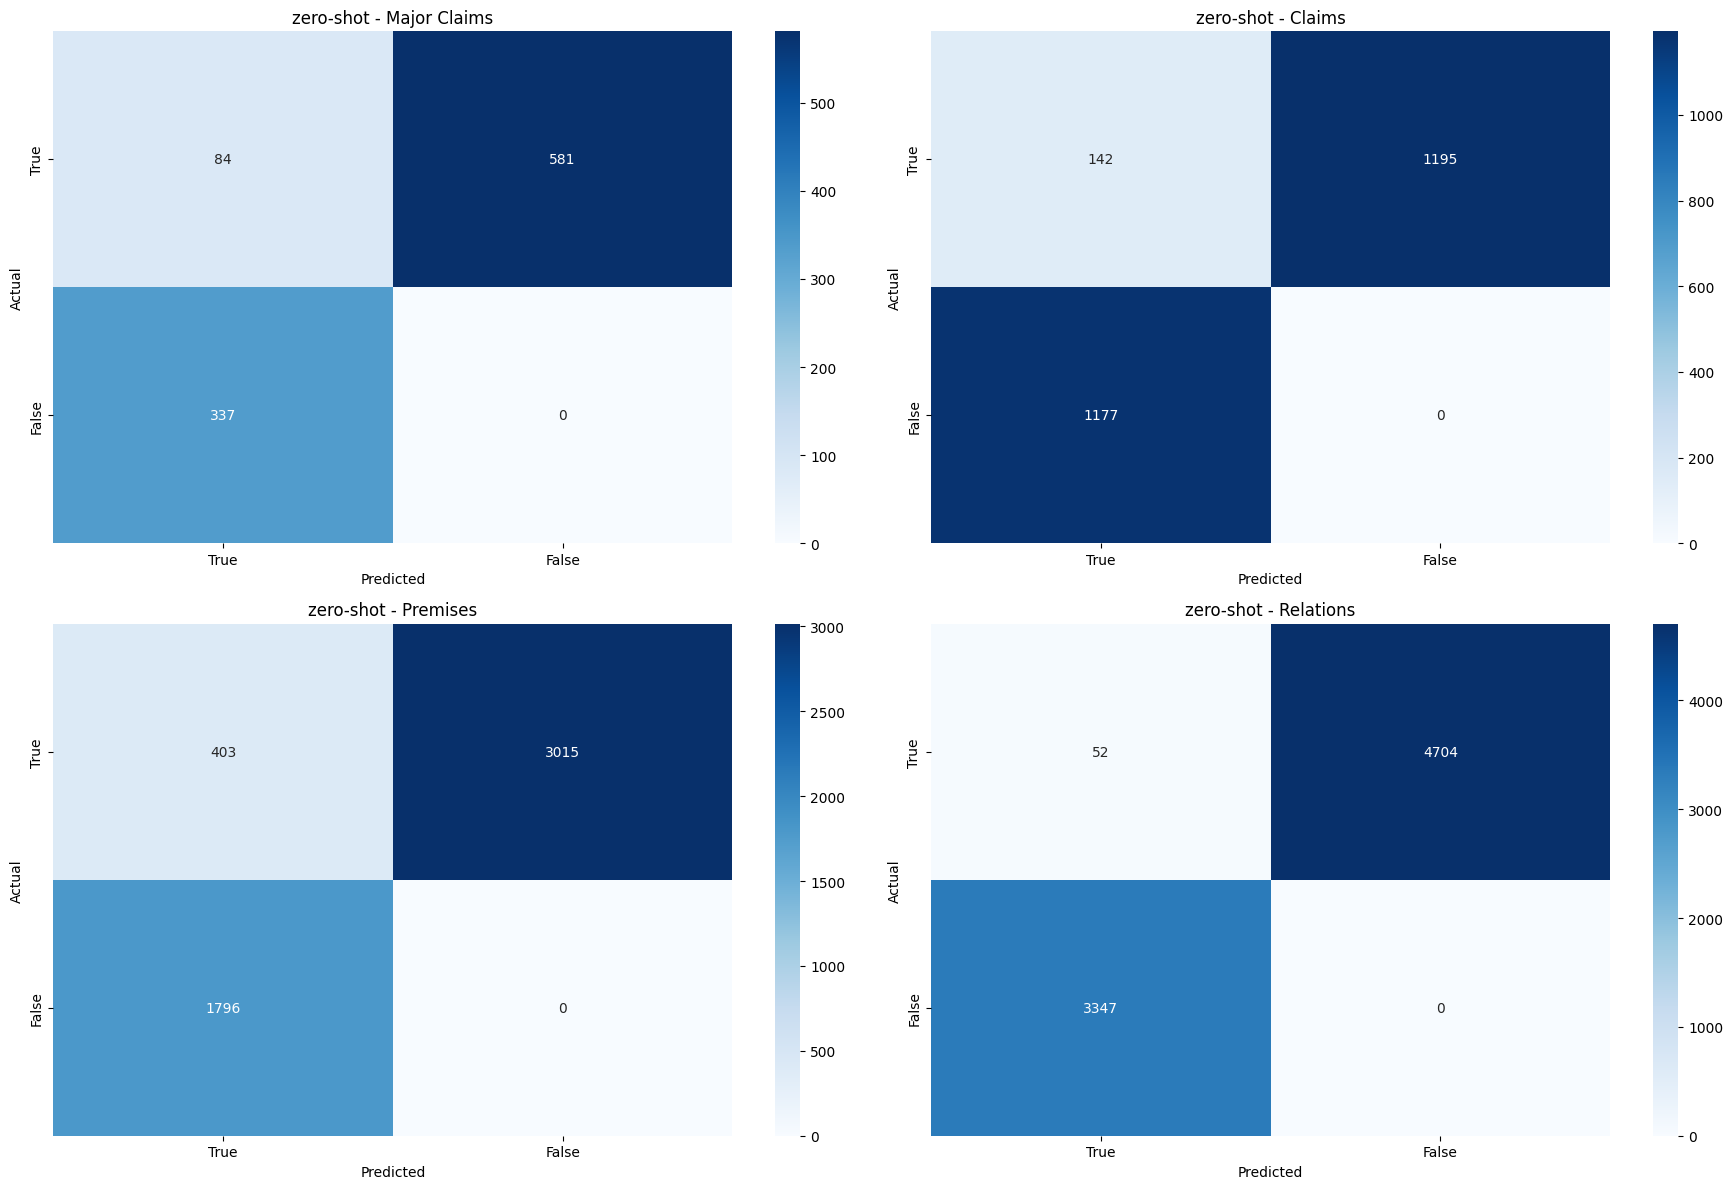

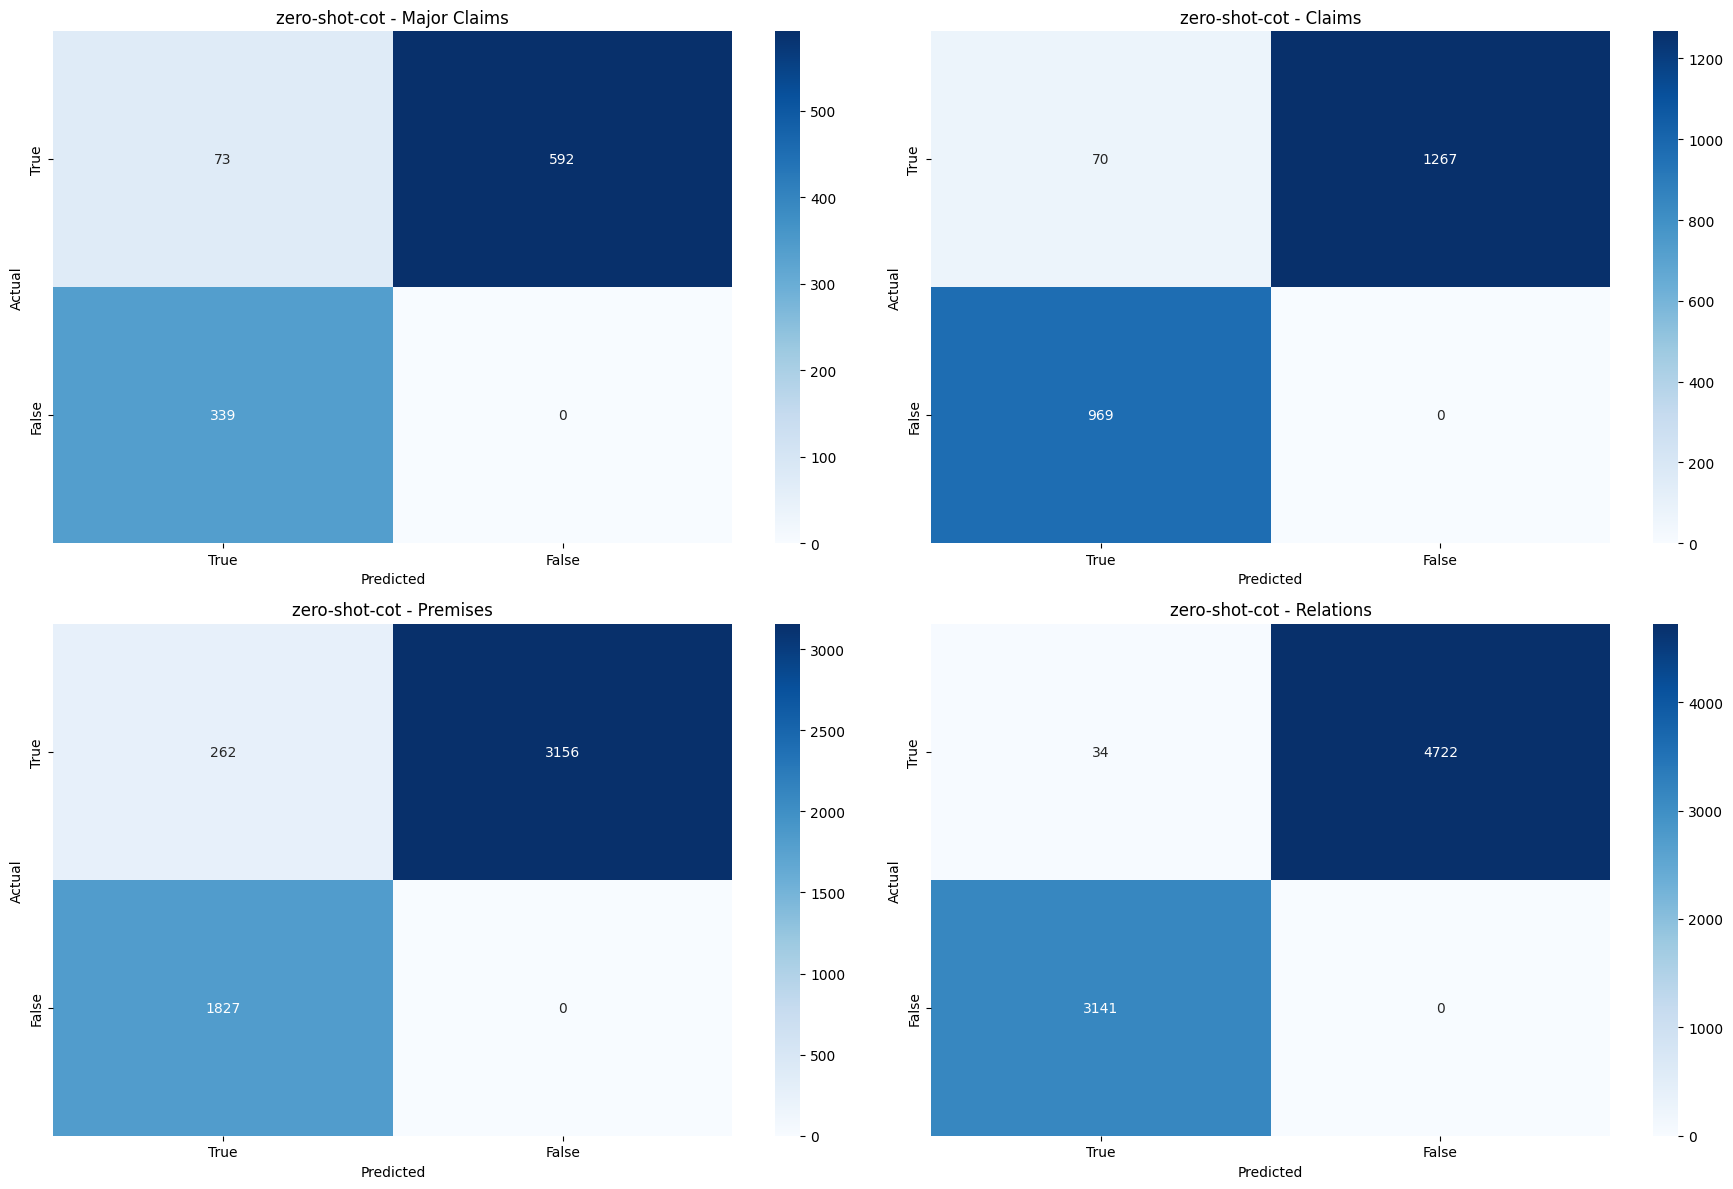

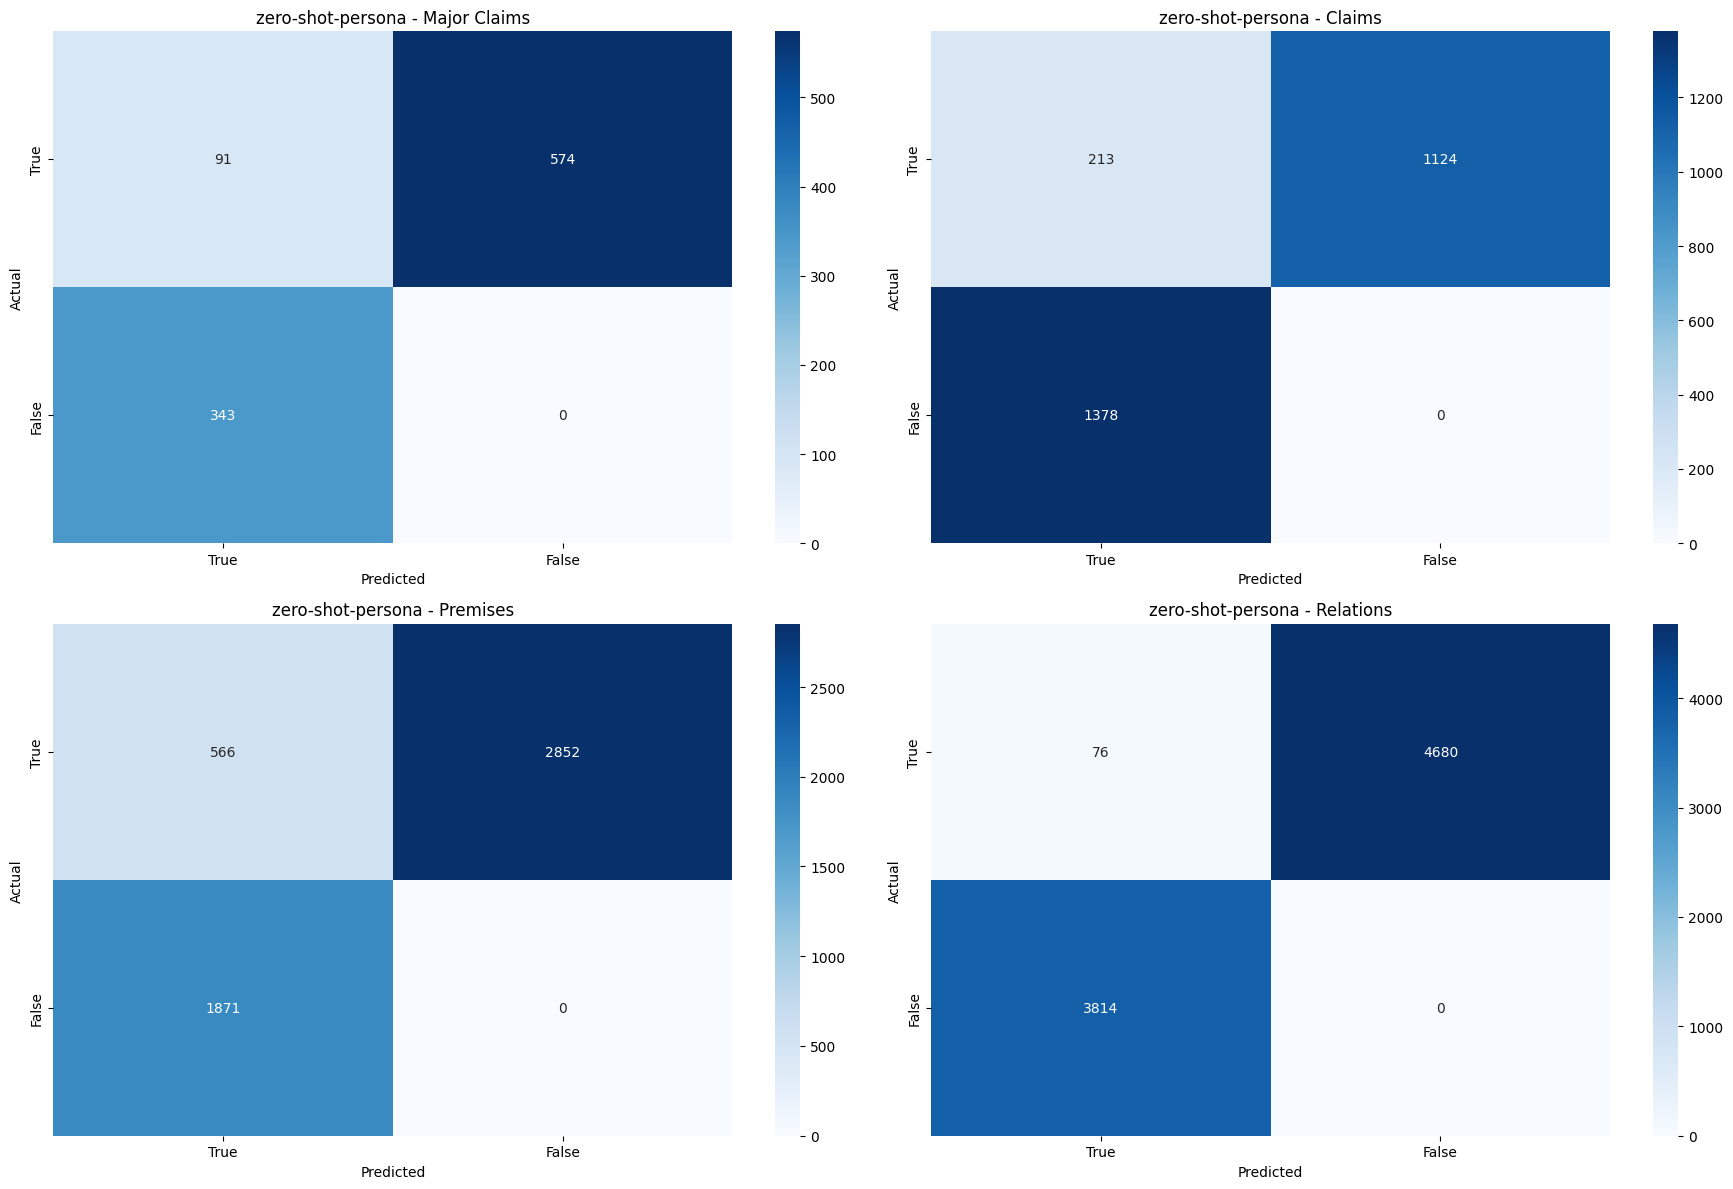

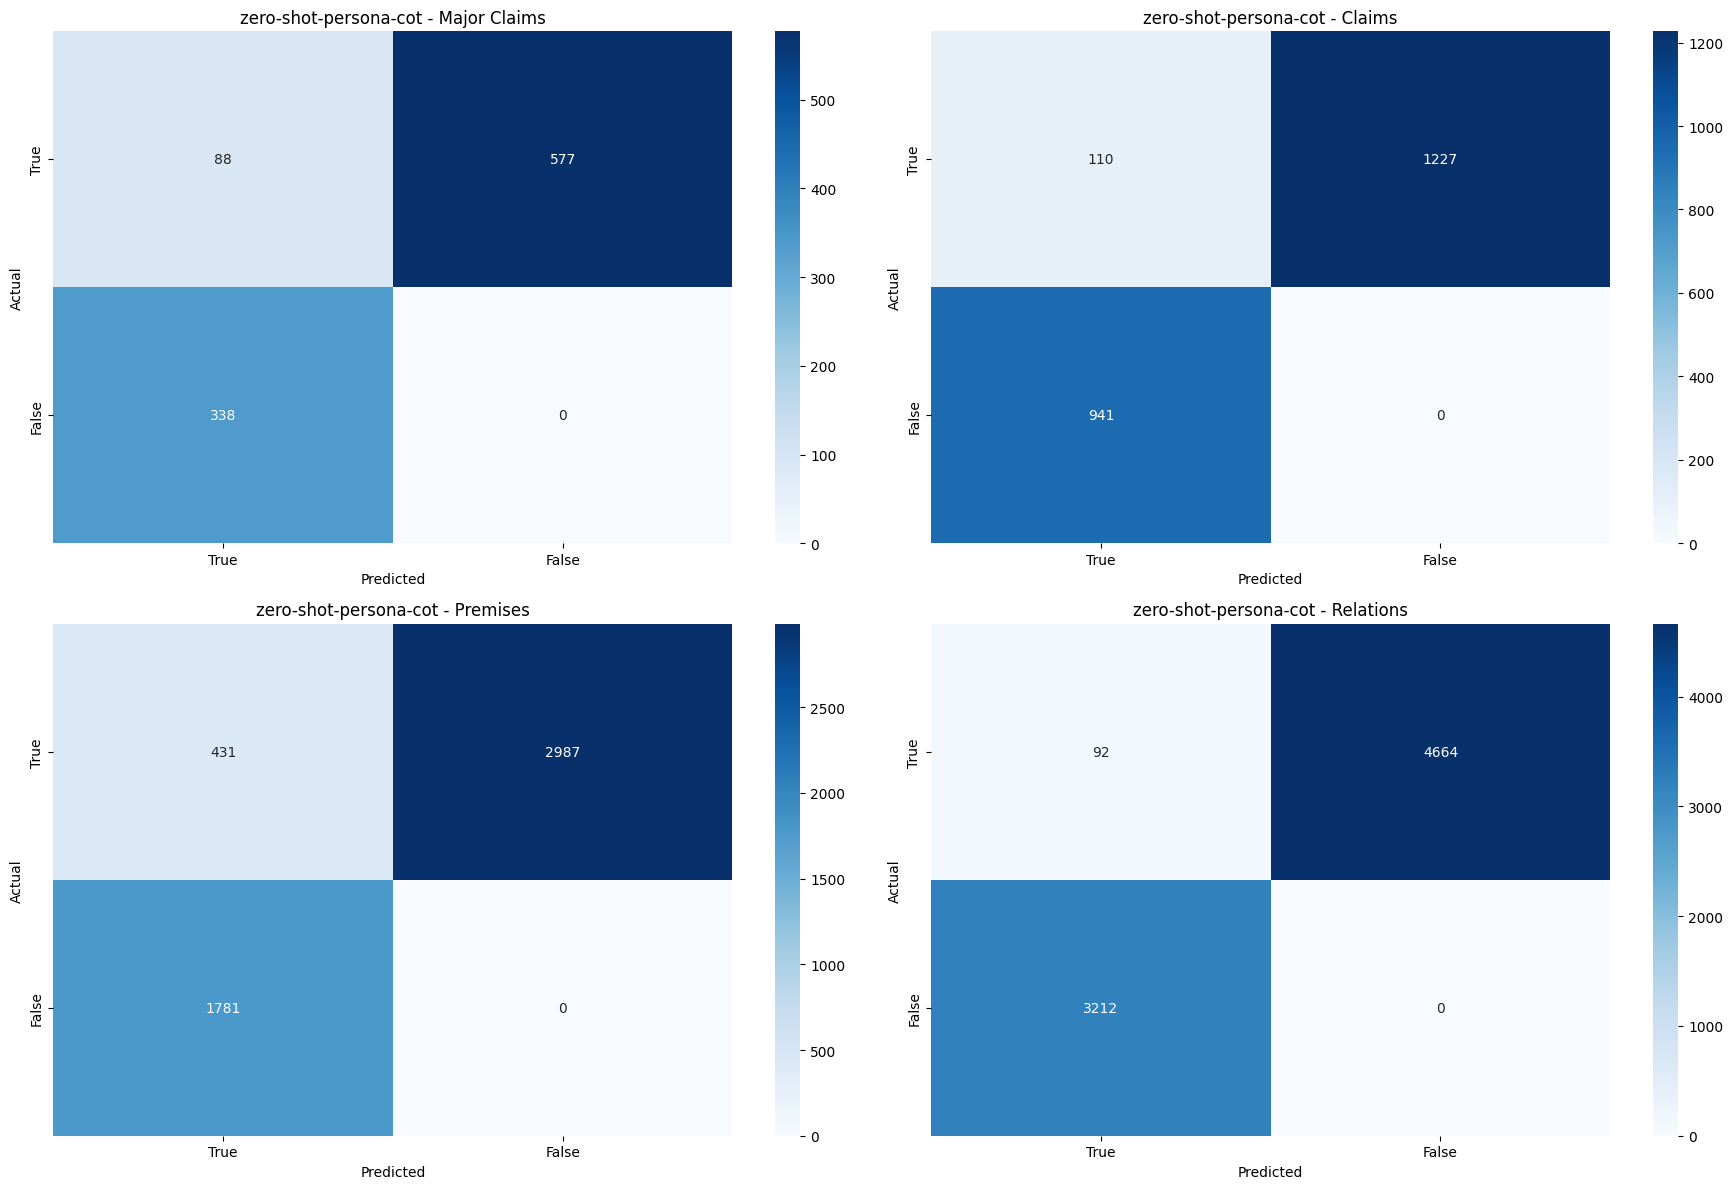

In [ ]:
# Für jeden Prompt werden 4 Konfusionsmatrizen als Subplots für die Argumentationskomponenten und deren Beziehungen erstellt.
# Bei 20 Prompts ergibt das 80 Subplots, welche sehr viel Platz einnehmen. Die Ausgabe wurde daher zusammengeklappt und kann bei Bedarf eingesehen werden.  
plot_confusion_matrices(grouped_df)

# Evaluationsmetriken

In [28]:
def calc_mertics(grouped_df):
    eval_metrics = []

    for index, row in grouped_df.iterrows():
        total_tp_mc = row['MajorClaims_TP']
        total_fn_mc = row['MajorClaims_FN']
        total_fp_mc = row['MajorClaims_FP']
        #total_tn_mc = row['MajorClaims_TN']

        total_tp_c = row['Claims_TP']
        total_fn_c = row['Claims_FN']
        total_fp_c = row['Claims_FP']
        #total_tn_c = row['Claims_TN']

        total_tp_p = row['Premises_TP']
        total_fn_p = row['Premises_FN']
        total_fp_p = row['Premises_FP']
        #total_tn_p = row['Premises_TN']

        total_tp_r = row['Relations_TP']
        total_fn_r = row['Relations_FN']
        total_fp_r = row['Relations_FP']
        #total_tn_r = row['Relations_TN']

        # Calculate Precision, Recall, and F1-Score for Major Claims
        precision_mc = total_tp_mc / (total_tp_mc + total_fp_mc) if (total_tp_mc + total_fp_mc) != 0 else 0
        recall_mc = total_tp_mc / (total_tp_mc + total_fn_mc) if (total_tp_mc + total_fn_mc) != 0 else 0
        f1_score_mc = 2 * (precision_mc * recall_mc) / (precision_mc + recall_mc) if (precision_mc + recall_mc) != 0 else 0

        # Calculate Precision, Recall, and F1-Score for Claims
        precision_c = total_tp_c / (total_tp_c + total_fp_c) if (total_tp_c + total_fp_c) != 0 else 0
        recall_c = total_tp_c / (total_tp_c + total_fn_c) if (total_tp_c + total_fn_c) != 0 else 0
        f1_score_c = 2 * (precision_c * recall_c) / (precision_c + recall_c) if (precision_c + recall_c) != 0 else 0
        
        # Calculate Precision, Recall, and F1-Score for Premises
        precision_p = total_tp_p / (total_tp_p + total_fp_p) if (total_tp_p + total_fp_p) != 0 else 0
        recall_p = total_tp_p / (total_tp_p + total_fn_p) if (total_tp_p + total_fn_p) != 0 else 0
        f1_score_p = 2 * (precision_p * recall_p) / (precision_p + recall_p) if (precision_p + recall_p) != 0 else 0

        # Calculate Precision, Recall, and F1-Score for Relations
        precision_r = total_tp_r / (total_tp_r + total_fp_r) if (total_tp_r + total_fp_r) != 0 else 0
        recall_r = total_tp_r / (total_tp_r + total_fn_r) if (total_tp_r + total_fn_r) != 0 else 0
        f1_score_r = 2 * (precision_r * recall_r) / (precision_r + recall_r) if (precision_r + recall_r) != 0 else 0


        eval_metrics.append({
            'Prompt': index,
            'Precision_MC': round(precision_mc, 2),
            'Recall_MC': round(recall_mc, 2),
            'F1_Score_MC': round(f1_score_mc, 2),
            'Precision_C': round(precision_c, 2),
            'Recall_C': round(recall_c, 2),
            'F1_Score_C': round(f1_score_c, 2),
            'Precision_P': round(precision_p, 2),
            'Recall_P': round(recall_p, 2),
            'F1_Score_P': round(f1_score_p, 2),
            'Precision_R': round(precision_r, 2),
            'Recall_R': round(recall_r, 2),
            'F1_Score_R': round(f1_score_r, 2)
        })
    
    df = pd.DataFrame(eval_metrics)

    return df

In [29]:
def calc_mertics2(input_df):
    eval_metrics = []

    for index, row in input_df.iterrows():
        total_tp_mc = row['MajorClaims_TP']
        total_fn_mc = row['MajorClaims_FN']
        total_fp_mc = row['MajorClaims_FP']
        #total_tn_mc = row['MajorClaims_TN']

        total_tp_c = row['Claims_TP']
        total_fn_c = row['Claims_FN']
        total_fp_c = row['Claims_FP']
        #total_tn_c = row['Claims_TN']

        total_tp_p = row['Premises_TP']
        total_fn_p = row['Premises_FN']
        total_fp_p = row['Premises_FP']
        #total_tn_p = row['Premises_TN']

        total_tp_r = row['Relations_TP']
        total_fn_r = row['Relations_FN']
        total_fp_r = row['Relations_FP']
        #total_tn_r = row['Relations_TN']

        # Calculate Precision, Recall, and F1-Score for Major Claims
        precision_mc = total_tp_mc / (total_tp_mc + total_fp_mc) if (total_tp_mc + total_fp_mc) != 0 else 0
        recall_mc = total_tp_mc / (total_tp_mc + total_fn_mc) if (total_tp_mc + total_fn_mc) != 0 else 0
        f1_score_mc = 2 * (precision_mc * recall_mc) / (precision_mc + recall_mc) if (precision_mc + recall_mc) != 0 else 0

        # Calculate Precision, Recall, and F1-Score for Claims
        precision_c = total_tp_c / (total_tp_c + total_fp_c) if (total_tp_c + total_fp_c) != 0 else 0
        recall_c = total_tp_c / (total_tp_c + total_fn_c) if (total_tp_c + total_fn_c) != 0 else 0
        f1_score_c = 2 * (precision_c * recall_c) / (precision_c + recall_c) if (precision_c + recall_c) != 0 else 0
        
        # Calculate Precision, Recall, and F1-Score for Premises
        precision_p = total_tp_p / (total_tp_p + total_fp_p) if (total_tp_p + total_fp_p) != 0 else 0
        recall_p = total_tp_p / (total_tp_p + total_fn_p) if (total_tp_p + total_fn_p) != 0 else 0
        f1_score_p = 2 * (precision_p * recall_p) / (precision_p + recall_p) if (precision_p + recall_p) != 0 else 0

        # Calculate Precision, Recall, and F1-Score for Relations
        precision_r = total_tp_r / (total_tp_r + total_fp_r) if (total_tp_r + total_fp_r) != 0 else 0
        recall_r = total_tp_r / (total_tp_r + total_fn_r) if (total_tp_r + total_fn_r) != 0 else 0
        f1_score_r = 2 * (precision_r * recall_r) / (precision_r + recall_r) if (precision_r + recall_r) != 0 else 0


        eval_metrics.append({
            'Prompt': row['prompt'],
            'Precision_MC': round(precision_mc, 3),
            'Recall_MC': round(recall_mc, 3),
            'F1_Score_MC': round(f1_score_mc, 3),
            'Precision_C': round(precision_c, 3),
            'Recall_C': round(recall_c, 3),
            'F1_Score_C': round(f1_score_c, 3),
            'Precision_P': round(precision_p, 3),
            'Recall_P': round(recall_p, 3),
            'F1_Score_P': round(f1_score_p, 3),
            'Precision_R': round(precision_r, 3),
            'Recall_R': round(recall_r, 3),
            'F1_Score_R': round(f1_score_r, 3),
        })
    
    df = pd.DataFrame(eval_metrics)

    return df


In [30]:
PROMPTS_PATH = 'prompts/final-prompts/'

prompt_files_directory_list = list_files_with_extension_directory(PROMPTS_PATH, '.txt')
prompt_files_directory_list
prompt_files_list = [os.path.basename(x) for x in prompt_files_directory_list]
# remove the .txt extension
prompt_names = [x.split('.')[0] for x in prompt_files_list]

token_df = pd.DataFrame()
# get the file name without the extension from prompt_files, 'str' object has no attribute 'path'
token_df['Prompt'] = prompt_names
token_df['prompt_txt'] = prompt_files_directory_list
token_df['prompt_txt'] = token_df['prompt_txt'].apply(load_text)
token_df['tokens'] = token_df['prompt_txt'].apply(num_tokens_from_string, model_name='gpt-4o-mini')
token_df = token_df.drop(columns=['prompt_txt'])
token_df = token_df.sort_values(by='tokens')
token_df

Prompt  tokens
19                zero-shot      82
18        zero-shot-persona     105
16            zero-shot-cot     480
17    zero-shot-persona-cot     503
15                 one-shot    1780
14         one-shot-persona    1790
12             one-shot-cot    2166
13     one-shot-persona-cot    2189
3               few-shot-10   13848
2       few-shot-10-persona   13871
0           few-shot-10-cot   14247
1   few-shot-10-persona-cot   14270
7               few-shot-20   27681
6       few-shot-20-persona   27704
4           few-shot-20-cot   28080
5   few-shot-20-persona-cot   28103
11              few-shot-40   54048
10      few-shot-40-persona   54071
8           few-shot-40-cot   54447
9   few-shot-40-persona-cot   54470

## textweise

In [32]:
eval_metric_df = calc_mertics2(merged_eval_df)
eval_metric_df.columns

Index(['Prompt', 'Precision_MC', 'Recall_MC', 'F1_Score_MC', 'Precision_C',
       'Recall_C', 'F1_Score_C', 'Precision_P', 'Recall_P', 'F1_Score_P',
       'Precision_R', 'Recall_R', 'F1_Score_R'],
      dtype='object')

In [33]:
#use merge to add the token count to the eval_metric_df
eval_metric_df = pd.merge(eval_metric_df, token_df, on='Prompt')
print(eval_metric_df.shape)

(7180, 14)


In [34]:
eval_metric_df.sample(5, random_state=42)

Prompt  Precision_MC  Recall_MC  F1_Score_MC  \
1554          few-shot-20-cot           0.5        0.5          0.5   
2876              few-shot-40           0.5        0.5          0.5   
1755  few-shot-20-persona-cot           1.0        1.0          1.0   
2505         one-shot-persona           0.0        0.0          0.0   
1335  few-shot-20-persona-cot           1.0        1.0          1.0   

      Precision_C  Recall_C  F1_Score_C  Precision_P  Recall_P  F1_Score_P  \
1554        0.143     0.250       0.182        0.625     0.357       0.455   
2876        0.250     0.125       0.167        0.750     0.500       0.600   
1755        0.333     0.667       0.444        0.250     0.167       0.200   
2505        0.286     0.500       0.364        1.000     0.429       0.600   
1335        0.286     0.667       0.400        0.714     0.294       0.417   

      Precision_R  Recall_R  F1_Score_R  tokens  
1554        0.133     0.111       0.121   28080  
2876        0.125     0.071       0.091   54048  
1755        0.000     0.000       0.000   28103  
2505        0.100     0.091       0.095    1790  
1335        0.286     0.200       0.235   28103

In [35]:
# F1-Score für die Argumentationskomponenten und Beziehungen
eval_metric_df[['F1_Score_MC', 'F1_Score_C', 'F1_Score_P', 'F1_Score_R']].describe().round(2)

F1_Score_MC  F1_Score_C  F1_Score_P  F1_Score_R
count      7180.00     7180.00     7180.00     7180.00
mean          0.44        0.27        0.32        0.09
std           0.37        0.22        0.22        0.12
min           0.00        0.00        0.00        0.00
25%           0.00        0.00        0.14        0.00
50%           0.50        0.25        0.31        0.06
75%           0.67        0.44        0.48        0.15
max           1.00        1.00        1.00        0.76

In [36]:
# Metriken für Hauptaussagen
eval_metric_df[['Precision_MC', 'Recall_MC', 'F1_Score_MC']].describe().round(2)

Precision_MC  Recall_MC  F1_Score_MC
count       7180.00    7180.00      7180.00
mean           0.46       0.46         0.44
std            0.40       0.39         0.37
min            0.00       0.00         0.00
25%            0.00       0.00         0.00
50%            0.50       0.50         0.50
75%            1.00       1.00         0.67
max            1.00       1.00         1.00

In [37]:
# Metriken für Behauptungen
eval_metric_df[['Precision_C', 'Recall_C', 'F1_Score_C']].describe().round(2)

Precision_C  Recall_C  F1_Score_C
count      7180.00   7180.00     7180.00
mean          0.24      0.34        0.27
std           0.22      0.29        0.22
min           0.00      0.00        0.00
25%           0.00      0.00        0.00
50%           0.20      0.33        0.25
75%           0.38      0.50        0.44
max           1.00      1.00        1.00

In [38]:
# Metriken für Prämissen
eval_metric_df[['Precision_P', 'Recall_P', 'F1_Score_P']].describe().round(2)

Precision_P  Recall_P  F1_Score_P
count      7180.00   7180.00     7180.00
mean          0.43      0.26        0.32
std           0.30      0.19        0.22
min           0.00      0.00        0.00
25%           0.20      0.12        0.14
50%           0.40      0.25        0.31
75%           0.67      0.40        0.48
max           1.00      1.00        1.00

In [39]:
# Metriken für Beziehungen
eval_metric_df[['Precision_R', 'Recall_R', 'F1_Score_R']].describe().round(2)

Precision_R  Recall_R  F1_Score_R
count      7180.00   7180.00     7180.00
mean          0.10      0.08        0.09
std           0.13      0.11        0.12
min           0.00      0.00        0.00
25%           0.00      0.00        0.00
50%           0.06      0.05        0.06
75%           0.17      0.14        0.15
max           0.80      0.73        0.76

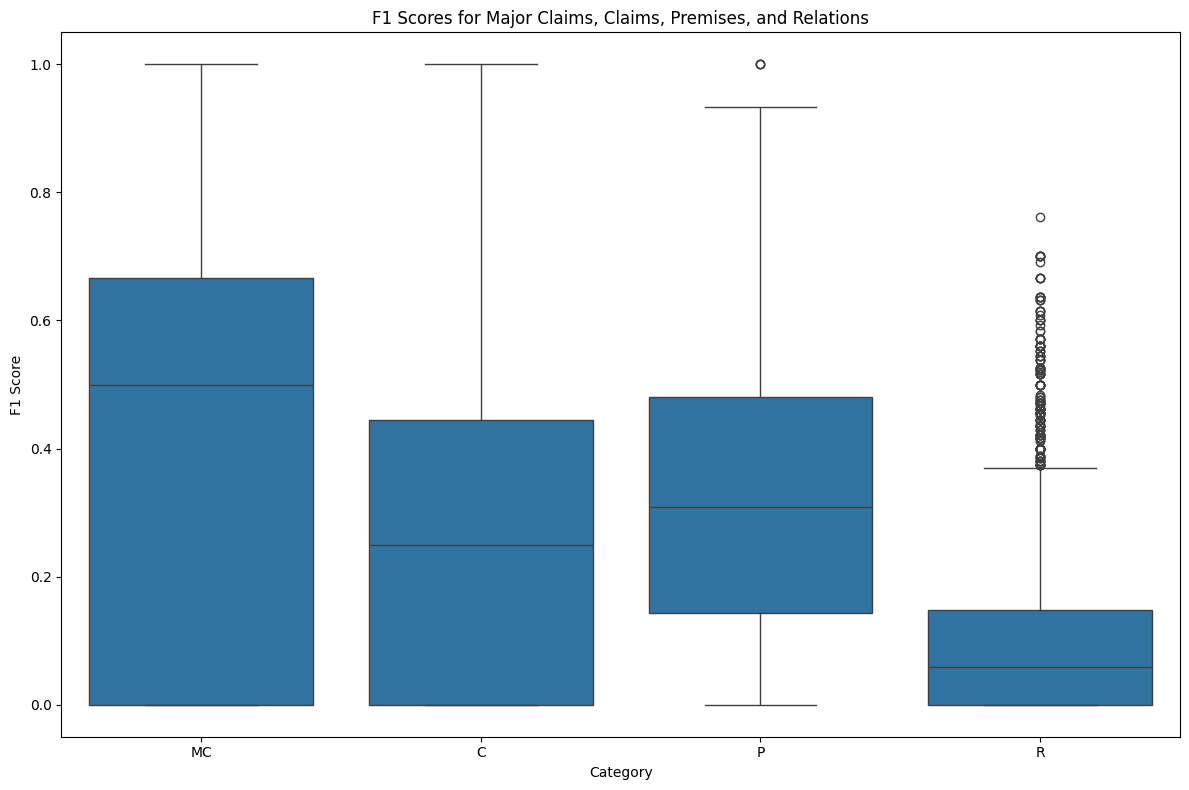

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Category': ['MC'] * len(eval_metric_df) + ['C'] * len(eval_metric_df) + ['P'] * len(eval_metric_df) + ['R'] * len(eval_metric_df),
    'F1_Score': list(eval_metric_df['F1_Score_MC']) + list(eval_metric_df['F1_Score_C']) + list(eval_metric_df['F1_Score_P']) + list(eval_metric_df['F1_Score_R']),
    'Prompt': list(eval_metric_df['Prompt']) * 4
})

# Create a boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=plot_data, x='Category', y='F1_Score')

# Set titles and labels
plt.title('F1 Scores for Major Claims, Claims, Premises, and Relations')
plt.xlabel('Category')
plt.ylabel('F1 Score')
plt.tight_layout()
plt.show()


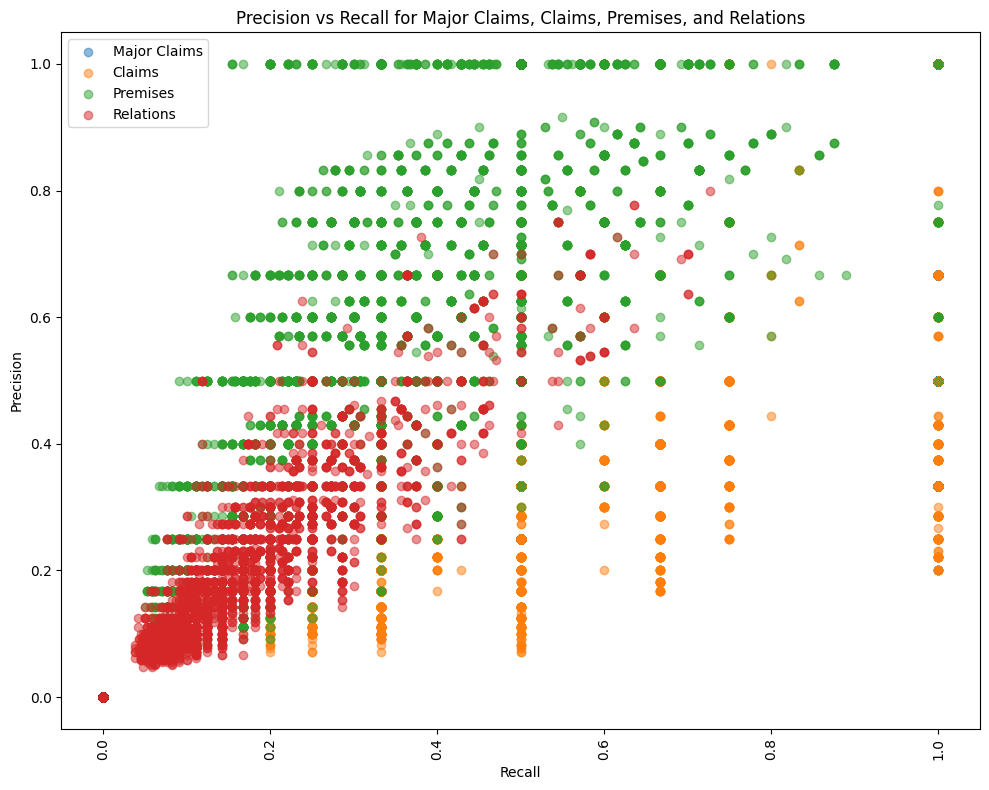

In [41]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot for Major Claims
ax.scatter(eval_metric_df['Recall_MC'], eval_metric_df['Precision_MC'], label='Major Claims', alpha=0.5)

# Scatter plot for Claims
ax.scatter(eval_metric_df['Recall_C'], eval_metric_df['Precision_C'], label='Claims', alpha=0.5)

# Scatter plot for Premises
ax.scatter(eval_metric_df['Recall_P'], eval_metric_df['Precision_P'], label='Premises', alpha=0.5)

# Scatter plot for Relations
ax.scatter(eval_metric_df['Recall_R'], eval_metric_df['Precision_R'], label='Relations', alpha=0.5)

# Set titles and labels
ax.set_title('Precision vs Recall for Major Claims, Claims, Premises, and Relations')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.tick_params(axis='x', rotation=90)

# Add legend
ax.legend()

plt.tight_layout()
plt.show()

## gruppiert nach prompt-art

In [42]:
grouped_eval_metric_df = calc_mertics(grouped_df)
# merge the eval_metric_df with token_df
grouped_eval_metric_df = pd.merge(grouped_eval_metric_df, token_df, on='Prompt')
grouped_eval_metric_df[['Prompt', 'F1_Score_MC', 'F1_Score_C', 'F1_Score_P', 'F1_Score_R', 'tokens']].sort_values(by='tokens', ascending=False)

Prompt  F1_Score_MC  F1_Score_C  F1_Score_P  F1_Score_R  \
11  few-shot-40-persona-cot         0.55        0.31        0.41        0.12   
9           few-shot-40-cot         0.53        0.30        0.40        0.11   
10      few-shot-40-persona         0.54        0.32        0.40        0.11   
8               few-shot-40         0.55        0.33        0.41        0.12   
7   few-shot-20-persona-cot         0.56        0.32        0.41        0.12   
5           few-shot-20-cot         0.53        0.30        0.39        0.11   
6       few-shot-20-persona         0.55        0.32        0.40        0.13   
4               few-shot-20         0.54        0.31        0.39        0.12   
3   few-shot-10-persona-cot         0.53        0.31        0.40        0.12   
1           few-shot-10-cot         0.51        0.30        0.38        0.11   
2       few-shot-10-persona         0.53        0.31        0.39        0.12   
0               few-shot-10         0.51        0.31        0.37        0.11   
15     one-shot-persona-cot         0.45        0.27        0.34        0.09   
13             one-shot-cot         0.43        0.26        0.30        0.08   
14         one-shot-persona         0.43        0.28        0.33        0.10   
12                 one-shot         0.43        0.27        0.30        0.08   
19    zero-shot-persona-cot         0.16        0.09        0.15        0.02   
17            zero-shot-cot         0.14        0.06        0.10        0.01   
18        zero-shot-persona         0.17        0.15        0.19        0.02   
16                zero-shot         0.15        0.11        0.14        0.01   

    tokens  
11   54470  
9    54447  
10   54071  
8    54048  
7    28103  
5    28080  
6    27704  
4    27681  
3    14270  
1    14247  
2    13871  
0    13848  
15    2189  
13    2166  
14    1790  
12    1780  
19     503  
17     480  
18     105  
16      82

In [43]:
zs_eval_metric_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].str.contains("zero-shot")]
os_eval_metric_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].str.contains("one-shot")]
fs10_eval_metric_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].str.contains("few-shot-10")]
fs20_eval_metric_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].str.contains("few-shot-20")]
fs40_eval_metric_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].str.contains("few-shot-40")]

print(zs_eval_metric_df['Prompt'].values)
zs_mean_tokens= round(zs_eval_metric_df['tokens'].mean(), 0)
os_mean_tokens= round(os_eval_metric_df['tokens'].mean(), 0)
fs10_mean_tokens= round(fs10_eval_metric_df['tokens'].mean(), 0)
fs20_mean_tokens= round(fs20_eval_metric_df['tokens'].mean(), 0)
fs40_mean_tokens= round(fs40_eval_metric_df['tokens'].mean(), 0)

print(f"Zero-Shot Mean Tokens: {zs_mean_tokens}")
print(f"One-Shot Mean Tokens: {os_mean_tokens}")
print(f"Few-Shot 10 Mean Tokens: {fs10_mean_tokens}")
print(f"Few-Shot 20 Mean Tokens: {fs20_mean_tokens}")
print(f"Few-Shot 40 Mean Tokens: {fs40_mean_tokens}")

['zero-shot' 'zero-shot-cot' 'zero-shot-persona' 'zero-shot-persona-cot']
Zero-Shot Mean Tokens: 292.0
One-Shot Mean Tokens: 1981.0
Few-Shot 10 Mean Tokens: 14059.0
Few-Shot 20 Mean Tokens: 27892.0
Few-Shot 40 Mean Tokens: 54259.0


In [44]:
mc_baseline = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'] == 'zero-shot']['F1_Score_MC'].values[0]
c_baseline = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'] == 'zero-shot']['F1_Score_C'].values[0]
p_baseline = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'] == 'zero-shot']['F1_Score_P'].values[0]
r_baseline = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'] == 'zero-shot']['F1_Score_R'].values[0]
print(f"Major Claims F1-Score Baseline: {mc_baseline}")
print(f"Claims F1-Score Baseline: {c_baseline}")
print(f"Premises F1-Score Baseline: {p_baseline}")
print(f"Relations F1-Score Baseline: {r_baseline}")

# Berechnung der Differenz zum Bezugswert (Baseline) absolut (F1-Score)
grouped_eval_metric_df['mc_diff_baseline'] = (grouped_eval_metric_df['F1_Score_MC'] - mc_baseline) 
grouped_eval_metric_df['c_diff_baseline'] = (grouped_eval_metric_df['F1_Score_C'] - c_baseline)
grouped_eval_metric_df['p_diff_baseline'] = (grouped_eval_metric_df['F1_Score_P'] - p_baseline)
grouped_eval_metric_df['r_diff_baseline'] = (grouped_eval_metric_df['F1_Score_R'] - r_baseline)
#Berechnung der Differenz zum Bezugswert (Baseline) in Prozent
grouped_eval_metric_df['mc_diff_baseline%'] = ((grouped_eval_metric_df['F1_Score_MC'] - mc_baseline) / mc_baseline * 100).round()
grouped_eval_metric_df['c_diff_baseline%'] = ((grouped_eval_metric_df['F1_Score_C'] - c_baseline) / c_baseline * 100).round()
grouped_eval_metric_df['p_diff_baseline%'] = ((grouped_eval_metric_df['F1_Score_P'] - p_baseline) / p_baseline * 100).round()
grouped_eval_metric_df['r_diff_baseline%'] = ((grouped_eval_metric_df['F1_Score_R'] - r_baseline) / r_baseline * 100).round()

grouped_eval_metric_df[['Prompt', 'F1_Score_MC', 'mc_diff_baseline', 'mc_diff_baseline%', 'F1_Score_C', 'c_diff_baseline', 'c_diff_baseline%', 'F1_Score_P', 'p_diff_baseline', 'p_diff_baseline%', 'F1_Score_R', 'r_diff_baseline', 'r_diff_baseline%', 'tokens']].sort_values(by='tokens', ascending=False)


Major Claims F1-Score Baseline: 0.15
Claims F1-Score Baseline: 0.11
Premises F1-Score Baseline: 0.14
Relations F1-Score Baseline: 0.01


Prompt  F1_Score_MC  mc_diff_baseline  mc_diff_baseline%  \
11  few-shot-40-persona-cot         0.55              0.40              267.0   
9           few-shot-40-cot         0.53              0.38              253.0   
10      few-shot-40-persona         0.54              0.39              260.0   
8               few-shot-40         0.55              0.40              267.0   
7   few-shot-20-persona-cot         0.56              0.41              273.0   
5           few-shot-20-cot         0.53              0.38              253.0   
6       few-shot-20-persona         0.55              0.40              267.0   
4               few-shot-20         0.54              0.39              260.0   
3   few-shot-10-persona-cot         0.53              0.38              253.0   
1           few-shot-10-cot         0.51              0.36              240.0   
2       few-shot-10-persona         0.53              0.38              253.0   
0               few-shot-10         0.51              0.36              240.0   
15     one-shot-persona-cot         0.45              0.30              200.0   
13             one-shot-cot         0.43              0.28              187.0   
14         one-shot-persona         0.43              0.28              187.0   
12                 one-shot         0.43              0.28              187.0   
19    zero-shot-persona-cot         0.16              0.01                7.0   
17            zero-shot-cot         0.14             -0.01               -7.0   
18        zero-shot-persona         0.17              0.02               13.0   
16                zero-shot         0.15              0.00                0.0   

    F1_Score_C  c_diff_baseline  c_diff_baseline%  F1_Score_P  \
11        0.31             0.20             182.0        0.41   
9         0.30             0.19             173.0        0.40   
10        0.32             0.21             191.0        0.40   
8         0.33             0.22             200.0        0.41   
7         0.32             0.21             191.0        0.41   
5         0.30             0.19             173.0        0.39   
6         0.32             0.21             191.0        0.40   
4         0.31             0.20             182.0        0.39   
3         0.31             0.20             182.0        0.40   
1         0.30             0.19             173.0        0.38   
2         0.31             0.20             182.0        0.39   
0         0.31             0.20             182.0        0.37   
15        0.27             0.16             145.0        0.34   
13        0.26             0.15             136.0        0.30   
14        0.28             0.17             155.0        0.33   
12        0.27             0.16             145.0        0.30   
19        0.09            -0.02             -18.0        0.15   
17        0.06            -0.05             -45.0        0.10   
18        0.15             0.04              36.0        0.19   
16        0.11             0.00               0.0        0.14   

    p_diff_baseline  p_diff_baseline%  F1_Score_R  r_diff_baseline  \
11             0.27             193.0        0.12             0.11   
9              0.26             186.0        0.11             0.10   
10             0.26             186.0        0.11             0.10   
8              0.27             193.0        0.12             0.11   
7              0.27             193.0        0.12             0.11   
5              0.25             179.0        0.11             0.10   
6              0.26             186.0        0.13             0.12   
4              0.25             179.0        0.12             0.11   
3              0.26             186.0        0.12             0.11   
1              0.24             171.0        0.11             0.10   
2              0.25             179.0        0.12             0.11   
0              0.23             164.0        0.11             0.10   
15             0.20             143.0      

In [45]:
# Ausgabe der maximalen F1-Scores für die Argumentationskomponenten und -beziehungen
print(f"Maximaler F1-Score für Major Claims: {grouped_eval_metric_df['F1_Score_MC'].max()}")
print(f"Maximaler F1-Score für Claims: {grouped_eval_metric_df['F1_Score_C'].max()}")
print(f"Maximaler F1-Score für Premises: {grouped_eval_metric_df['F1_Score_P'].max()}")
print(f"Maximaler F1-Score für Relations: {grouped_eval_metric_df['F1_Score_R'].max()}")

Maximaler F1-Score für Major Claims: 0.56
Maximaler F1-Score für Claims: 0.33
Maximaler F1-Score für Premises: 0.41
Maximaler F1-Score für Relations: 0.13


In [46]:
# maximalen F1-Scores für jede Kategorie
max_f1_scores = grouped_eval_metric_df[['F1_Score_MC', 'F1_Score_C', 'F1_Score_P', 'F1_Score_R']].max()
max_f1_scores

F1_Score_MC    0.56
F1_Score_C     0.33
F1_Score_P     0.41
F1_Score_R     0.13
dtype: float64

In [47]:
basic_list = ['zero-shot', 'one-shot', 'few-shot-10', 'few-shot-20', 'few-shot-40']
persona_list = ['zero-shot-persona', 'one-shot-persona', 'few-shot-10-persona', 'few-shot-20-persona', 'few-shot-40-persona']
cot_list = ['zero-shot-cot', 'one-shot-cot', 'few-shot-10-cot', 'few-shot-20-cot', 'few-shot-40-cot']
persona_cot_list = ['zero-shot-persona-cot', 'one-shot-persona-cot', 'few-shot-10-persona-cot', 'few-shot-20-persona-cot', 'few-shot-40-persona-cot']

# Filtern der DataFrames nach den verschiedenen Prompt-Gruppen
eval_metric_basic_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].isin(basic_list)].sort_values(by='tokens', ascending=False)
eval_metric_persona_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].isin(persona_list)].sort_values(by='tokens', ascending=False)
eval_metric_cot_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].isin(cot_list)].sort_values(by='tokens', ascending=False)
eval_metric_persona_cot_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].isin(persona_cot_list)].sort_values(by='tokens', ascending=False)

print(len(eval_metric_basic_df))
print(len(eval_metric_persona_df))
print(len(eval_metric_cot_df))
print(len(eval_metric_persona_cot_df))

5
5
5
5


In [48]:
eval_metric_basic_df

Prompt  Precision_MC  Recall_MC  F1_Score_MC  Precision_C  Recall_C  \
8   few-shot-40          0.54       0.55         0.55         0.29      0.37   
4   few-shot-20          0.52       0.56         0.54         0.27      0.36   
0   few-shot-10          0.49       0.54         0.51         0.26      0.38   
12     one-shot          0.41       0.44         0.43         0.21      0.40   
16    zero-shot          0.20       0.13         0.15         0.11      0.11   

    F1_Score_C  Precision_P  Recall_P  F1_Score_P  ...  F1_Score_R  tokens  \
8         0.33         0.54      0.33        0.41  ...        0.12   54048   
4         0.31         0.51      0.32        0.39  ...        0.12   27681   
0         0.31         0.49      0.30        0.37  ...        0.11   13848   
12        0.27         0.39      0.24        0.30  ...        0.08    1780   
16        0.11         0.18      0.12        0.14  ...        0.01      82   

    mc_diff_baseline  c_diff_baseline  p_diff_baseline  r_diff_baseline  \
8               0.40             0.22             0.27             0.11   
4               0.39             0.20             0.25             0.11   
0               0.36             0.20             0.23             0.10   
12              0.28             0.16             0.16             0.07   
16              0.00             0.00             0.00             0.00   

    mc_diff_baseline%  c_diff_baseline%  p_diff_baseline%  r_diff_baseline%  
8               267.0             200.0             193.0            1100.0  
4               260.0             182.0             179.0            1100.0  
0               240.0             182.0             164.0            1000.0  
12              187.0             145.0             114.0             700.0  
16                0.0               0.0               0.0               0.0  

[5 rows x 22 columns]

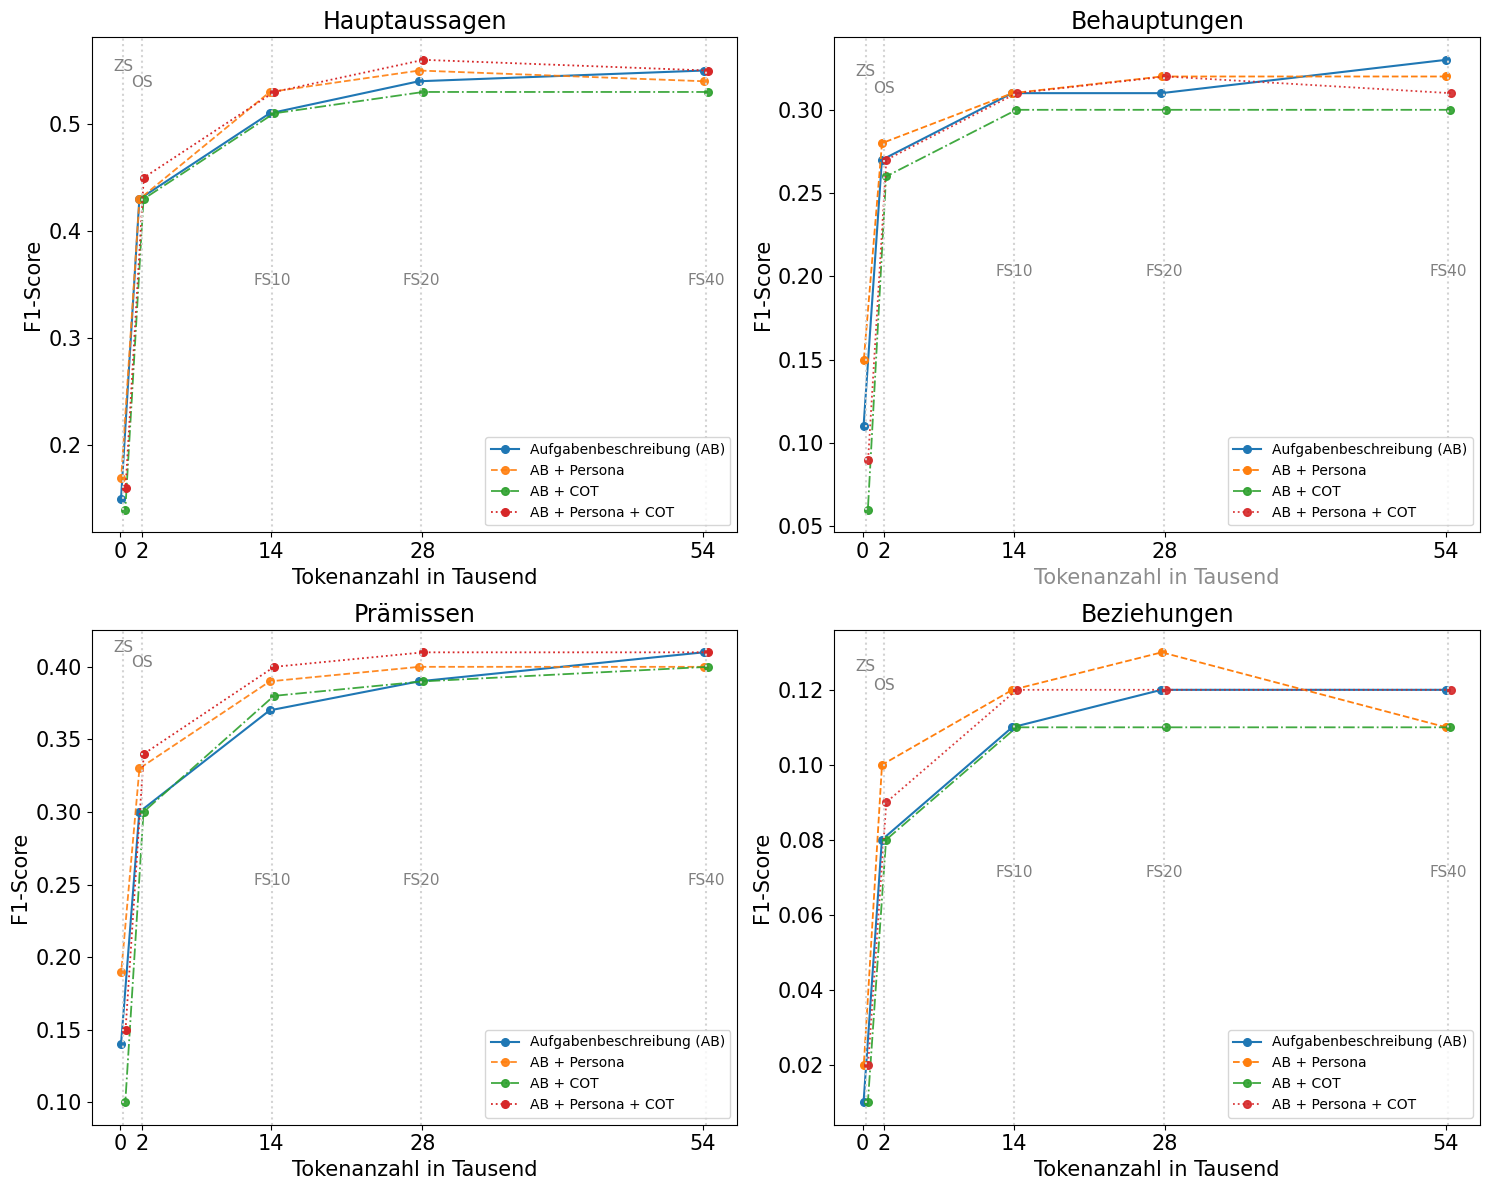

In [49]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Define a color cycle
colors = plt.cm.tab10.colors

# Format x-axis ticks to show per 1000 tokens and set specific ticks
for ax in axs.flat:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1000)}'))
    ax.set_xticks([round(zs_mean_tokens, -3), round(os_mean_tokens, -3), round(fs10_mean_tokens, -3), round(fs20_mean_tokens, -3), round(fs40_mean_tokens, -3)]) 

# Übergreifende Einstellungen
linecolor = 'grey'
ab_linecolor = 'black'
vertical_linecolor = 'lightgrey'
best_linecolor = 'blue'
basic_linestyle = 'solid'
persona_linestyle = 'dashed'
cot_linestyle = 'dashdot'
persona_cot_linestyle = 'dotted'
linewidth_basic = 1.5
linewidth_rest = 1.3
label_fontsize = 15
title_fontsize = 17
annotation_fontsize = 11
annotation_color = 'grey'
legend_loc = 'lower right'
marker = "."
markersize = 11
alpha = 0.9

# Plot für Hauptaussagen
axs[0, 0].plot(eval_metric_basic_df['tokens'], eval_metric_basic_df['F1_Score_MC'], label='Aufgabenbeschreibung (AB)',
               marker=marker, markersize=markersize,
               linestyle=basic_linestyle, linewidth=linewidth_basic,
               color=colors[0])
axs[0, 0].plot(eval_metric_persona_df['tokens'], eval_metric_persona_df['F1_Score_MC'], label='AB + Persona',
               marker=marker, markersize=markersize,
               linestyle=persona_linestyle, linewidth=linewidth_rest,
               color=colors[1],
               alpha=alpha)
axs[0, 0].plot(eval_metric_cot_df['tokens'], eval_metric_cot_df['F1_Score_MC'], label='AB + COT',
               marker=marker, markersize=markersize,
               linestyle=cot_linestyle, linewidth=linewidth_rest,
               color=colors[2],
               alpha=alpha)
axs[0, 0].plot(eval_metric_persona_cot_df['tokens'], eval_metric_persona_cot_df['F1_Score_MC'], label='AB + Persona + COT',
               marker=marker, markersize=markersize,
               linestyle=persona_cot_linestyle, linewidth=linewidth_rest,
               color=colors[3])
axs[0, 0].set_xlabel('Tokenanzahl in Tausend', fontsize=label_fontsize)
axs[0, 0].set_ylabel('F1-Score', fontsize=label_fontsize)
axs[0, 0].set_title('Hauptaussagen', fontsize=title_fontsize)
axs[0, 0].tick_params(axis='both', which='major', labelsize=label_fontsize)
axs[0, 0].legend(loc=legend_loc)
# Vertikale Linien
axs[0, 0].axvline(x=zs_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Zero-shot Mean Tokens')
axs[0, 0].axvline(x=os_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='One-shot Mean Tokens')
axs[0, 0].axvline(x=fs10_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-10 Mean Tokens')
axs[0, 0].axvline(x=fs20_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-20 Mean Tokens')
axs[0, 0].axvline(x=fs40_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-40 Mean Tokens')
axs[0, 0].annotate('ZS', xy=(zs_mean_tokens, 0.5), xytext=(zs_mean_tokens, 0.55), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 0].annotate('OS', xy=(os_mean_tokens, 0.5), xytext=(os_mean_tokens, 0.535), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 0].annotate('FS10', xy=(fs10_mean_tokens, 0.35), xytext=(fs10_mean_tokens, 0.35), xycoords='data', fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 0].annotate('FS20', xy=(fs20_mean_tokens, 0.35), xytext=(fs20_mean_tokens, 0.35), xycoords='data' , fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 0].annotate('FS40', xy=(fs40_mean_tokens, 0.35), xytext=(fs40_mean_tokens, 0.35), xycoords='data' , fontsize=annotation_fontsize, color=annotation_color, ha='center')

# Plot für Behauptungen
axs[0, 1].plot(eval_metric_basic_df['tokens'], eval_metric_basic_df['F1_Score_C'], label='Aufgabenbeschreibung (AB)',
               marker=marker, markersize=markersize,
               linestyle=basic_linestyle, linewidth=linewidth_basic,
               color=colors[0])
axs[0, 1].plot(eval_metric_persona_df['tokens'], eval_metric_persona_df['F1_Score_C'], label='AB + Persona',
               marker=marker, markersize=markersize,
               linestyle=persona_linestyle, linewidth=linewidth_rest,
               color=colors[1])
axs[0, 1].plot(eval_metric_cot_df['tokens'], eval_metric_cot_df['F1_Score_C'], label='AB + COT',
               marker=marker, markersize=markersize,
               linestyle=cot_linestyle, linewidth=linewidth_rest,
               color=colors[2], alpha=alpha)
axs[0, 1].plot(eval_metric_persona_cot_df['tokens'], eval_metric_persona_cot_df['F1_Score_C'], label='AB + Persona + COT',
               marker=marker, markersize=markersize,
               linestyle=persona_cot_linestyle, linewidth=linewidth_rest,
               color=colors[3], alpha=alpha)
axs[0, 1].set_xlabel('Tokenanzahl in Tausend', fontsize=label_fontsize,
               color=linecolor, alpha=alpha)
axs[0, 1].set_xlabel('Tokenanzahl in Tausend', fontsize=label_fontsize)
axs[0, 1].set_ylabel('F1-Score', fontsize=label_fontsize)
axs[0, 1].set_title('Behauptungen', fontsize=title_fontsize)
axs[0, 1].tick_params(axis='both', which='major', labelsize=label_fontsize)
axs[0, 1].legend(loc=legend_loc)
# Vertikale Linien
axs[0, 1].axvline(x=zs_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Zero-shot Mean Tokens')
axs[0, 1].axvline(x=os_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='One-shot Mean Tokens')
axs[0, 1].axvline(x=fs10_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-10 Mean Tokens')
axs[0, 1].axvline(x=fs20_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-20 Mean Tokens')
axs[0, 1].axvline(x=fs40_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-40 Mean Tokens')
axs[0, 1].annotate(text='ZS', xy=(zs_mean_tokens, 0.31), xytext=(zs_mean_tokens, 0.32), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 1].annotate(text='OS', xy=(os_mean_tokens, 0.31), xytext=(os_mean_tokens, 0.31), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 1].annotate(text='FS10', xy=(fs10_mean_tokens, 0.2), xytext=(fs10_mean_tokens, 0.2), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 1].annotate(text='FS20', xy=(fs20_mean_tokens, 0.2), xytext=(fs20_mean_tokens, 0.2), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 1].annotate(text='FS40', xy=(fs40_mean_tokens, 0.2), xytext=(fs40_mean_tokens, 0.2), fontsize=annotation_fontsize, color=annotation_color, ha='center')

# Plot for Premises
axs[1, 0].plot(eval_metric_basic_df['tokens'], eval_metric_basic_df['F1_Score_P'], label='Aufgabenbeschreibung (AB)',
               marker=marker, markersize=markersize,
               linestyle=basic_linestyle, linewidth=linewidth_basic,
               color=colors[0])
axs[1, 0].plot(eval_metric_persona_df['tokens'], eval_metric_persona_df['F1_Score_P'], label='AB + Persona',
               marker=marker, markersize=markersize,
               linestyle=persona_linestyle, linewidth=linewidth_rest,
               color=colors[1], alpha=alpha)
axs[1, 0].plot(eval_metric_cot_df['tokens'], eval_metric_cot_df['F1_Score_P'], label='AB + COT',
               marker=marker, markersize=markersize,
               linestyle=cot_linestyle,
               linewidth=linewidth_rest,
               color=colors[2], alpha=alpha)
axs[1, 0].plot(eval_metric_persona_cot_df['tokens'], eval_metric_persona_cot_df['F1_Score_P'], label='AB + Persona + COT',
               marker=marker, markersize=markersize,
               linestyle=persona_cot_linestyle, linewidth=linewidth_rest,
               color=colors[3])
axs[1, 0].set_xlabel('Tokenanzahl in Tausend', fontsize=label_fontsize)
axs[1, 0].set_ylabel('F1-Score', fontsize=label_fontsize)
axs[1, 0].set_title('Prämissen', fontsize=title_fontsize)
axs[1, 0].tick_params(axis='both', which='major', labelsize=label_fontsize)
axs[1, 0].legend(loc=legend_loc)
# Vertikale Linien
axs[1, 0].axvline(x=zs_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Zero-shot Mean Tokens')
axs[1, 0].axvline(x=os_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='One-shot Mean Tokens')
axs[1, 0].axvline(x=fs10_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-10 Mean Tokens')
axs[1, 0].axvline(x=fs20_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-20 Mean Tokens')
axs[1, 0].axvline(x=fs40_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-40 Mean Tokens')
axs[1, 0].annotate('ZS', xy=(zs_mean_tokens, 0.4), xytext=(zs_mean_tokens, 0.41), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 0].annotate('OS', xy=(os_mean_tokens, 0.4), xytext=(os_mean_tokens, 0.4), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 0].annotate('FS10', xy=(fs10_mean_tokens, 0.25), xytext=(fs10_mean_tokens, 0.25), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 0].annotate('FS20', xy=(fs20_mean_tokens, 0.25), xytext=(fs20_mean_tokens, 0.25), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 0].annotate('FS40', xy=(fs40_mean_tokens, 0.25), xytext=(fs40_mean_tokens, 0.25), fontsize=annotation_fontsize, color=annotation_color, ha='center')

# Plot for Relations
axs[1, 1].plot(eval_metric_basic_df['tokens'], eval_metric_basic_df['F1_Score_R'], label='Aufgabenbeschreibung (AB)',
               marker=marker, markersize=markersize,
               linestyle=basic_linestyle, linewidth=linewidth_basic,
               color=colors[0])
axs[1, 1].plot(eval_metric_persona_df['tokens'], eval_metric_persona_df['F1_Score_R'], label='AB + Persona',
               marker=marker, markersize=markersize,
               linestyle=persona_linestyle, linewidth=linewidth_rest,
               color=colors[1])
axs[1, 1].plot(eval_metric_cot_df['tokens'], eval_metric_cot_df['F1_Score_R'], label='AB + COT',
               marker=marker, markersize=markersize,
               linestyle=cot_linestyle, linewidth=linewidth_rest,
               color=colors[2], alpha=alpha)
axs[1, 1].plot(eval_metric_persona_cot_df['tokens'], eval_metric_persona_cot_df['F1_Score_R'], label='AB + Persona + COT',
               marker=marker, markersize=markersize,
               linestyle=persona_cot_linestyle, linewidth=linewidth_rest,
               color=colors[3], alpha=alpha)
axs[1, 1].set_xlabel('Tokenanzahl in Tausend', fontsize=label_fontsize)
axs[1, 1].set_ylabel('F1-Score', fontsize=label_fontsize)
axs[1, 1].set_title('Beziehungen', fontsize=title_fontsize)
axs[1, 1].tick_params(axis='both', which='major', labelsize=label_fontsize)
axs[1, 1].legend(loc=legend_loc)
# Vertikale Linien
axs[1, 1].axvline(x=zs_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Zero-shot Mean Tokens')
axs[1, 1].axvline(x=os_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='One-shot Mean Tokens')
axs[1, 1].axvline(x=fs10_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-10 Mean Tokens')
axs[1, 1].axvline(x=fs20_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-20 Mean Tokens')
axs[1, 1].axvline(x=fs40_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-40 Mean Tokens')
axs[1, 1].annotate('ZS', xy=(zs_mean_tokens, 0.12), xytext=(zs_mean_tokens, 0.125), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 1].annotate('OS', xy=(os_mean_tokens, 0.12), xytext=(os_mean_tokens, 0.12), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 1].annotate('FS10', xy=(fs10_mean_tokens, 0.07), xytext=(fs10_mean_tokens, 0.07), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 1].annotate('FS20', xy=(fs20_mean_tokens, 0.07), xytext=(fs20_mean_tokens, 0.07), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 1].annotate('FS40', xy=(fs40_mean_tokens, 0.07), xytext=(fs40_mean_tokens, 0.07), fontsize=annotation_fontsize, color=annotation_color, ha='center')

plt.tight_layout()
plt.show()

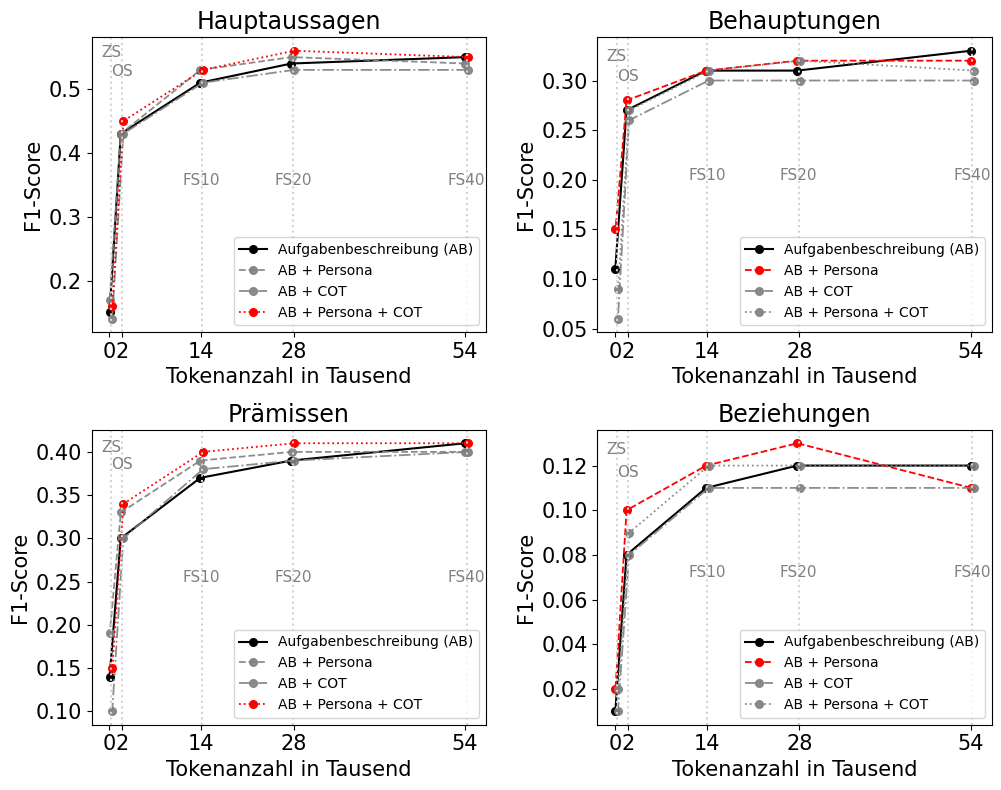

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Format x-axis ticks to show per 1000 tokens and set specific ticks
for ax in axs.flat:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1000)}'))
    # Verwendung der auf Tausend gerundeten Tokenanzahl als Beschreibung der x-Achse.
    # Stimmen absichtlich nicht mit den tatsächlichen Tokenanzahlen und den vertikalen Linien überein, um die Lesbarkeit zu verbessern bei gleichzeitiger korrekten Abbildung der Daten.
    ax.set_xticks([round(zs_mean_tokens, -3), round(os_mean_tokens, -3), round(fs10_mean_tokens, -3), round(fs20_mean_tokens, -3), round(fs40_mean_tokens, -3)]) 

# Übergreifende Einstellungen
linecolor = 'grey'
ab_linecolor = 'black'
vertical_linecolor = 'lightgrey'
best_linecolor = 'red'
basic_linestyle = 'solid'
persona_linestyle = 'dashed'
cot_linestyle = 'dashdot'
persona_cot_linestyle = 'dotted'
linewidth_basic = 1.5
linewidth_rest = 1.3
label_fontsize = 15
title_fontsize = 17
annotation_fontsize = 11
annotation_color = 'grey'
legend_loc = 'lower right'
marker = "."
markersize = 11
alpha = 0.9

# Plot für Hauptaussagen
axs[0, 0].plot(eval_metric_basic_df['tokens'], eval_metric_basic_df['F1_Score_MC'], label='Aufgabenbeschreibung (AB)',
               marker=marker, markersize=markersize,
               linestyle=basic_linestyle, linewidth=linewidth_basic,
               color=ab_linecolor)
axs[0, 0].plot(eval_metric_persona_df['tokens'], eval_metric_persona_df['F1_Score_MC'], label='AB + Persona',
               marker=marker, markersize=markersize,
               linestyle=persona_linestyle, linewidth=linewidth_rest,
               color=linecolor,
               alpha=alpha)
axs[0, 0].plot(eval_metric_cot_df['tokens'], eval_metric_cot_df['F1_Score_MC'], label='AB + COT',
               marker=marker, markersize=markersize,
               linestyle=cot_linestyle, linewidth=linewidth_rest,
               color=linecolor,
               alpha=alpha)
axs[0, 0].plot(eval_metric_persona_cot_df['tokens'], eval_metric_persona_cot_df['F1_Score_MC'], label='AB + Persona + COT',
               marker=marker, markersize=markersize,
               linestyle=persona_cot_linestyle, linewidth=linewidth_rest,
               color=best_linecolor)
axs[0, 0].set_xlabel('Tokenanzahl in Tausend', fontsize=label_fontsize)
axs[0, 0].set_ylabel('F1-Score', fontsize=label_fontsize)
axs[0, 0].set_title('Hauptaussagen', fontsize=title_fontsize)
axs[0, 0].tick_params(axis='both', which='major', labelsize=label_fontsize)
axs[0, 0].legend(loc=legend_loc)
# Vertikale Linien
axs[0, 0].axvline(x=zs_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Zero-shot Mean Tokens')
axs[0, 0].axvline(x=os_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='One-shot Mean Tokens')
axs[0, 0].axvline(x=fs10_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-10 Mean Tokens')
axs[0, 0].axvline(x=fs20_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-20 Mean Tokens')
axs[0, 0].axvline(x=fs40_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-40 Mean Tokens')
axs[0, 0].annotate('ZS', xy=(zs_mean_tokens, 0.5), xytext=(zs_mean_tokens, 0.55), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 0].annotate('OS', xy=(os_mean_tokens, 0.5), xytext=(os_mean_tokens, 0.52), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 0].annotate('FS10', xy=(fs10_mean_tokens, 0.35), xytext=(fs10_mean_tokens, 0.35), xycoords='data', fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 0].annotate('FS20', xy=(fs20_mean_tokens, 0.35), xytext=(fs20_mean_tokens, 0.35), xycoords='data' , fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 0].annotate('FS40', xy=(fs40_mean_tokens, 0.35), xytext=(fs40_mean_tokens, 0.35), xycoords='data' , fontsize=annotation_fontsize, color=annotation_color, ha='center')

# Plot für Behauptungen
axs[0, 1].plot(eval_metric_basic_df['tokens'], eval_metric_basic_df['F1_Score_C'], label='Aufgabenbeschreibung (AB)',
               marker=marker, markersize=markersize,
               linestyle=basic_linestyle, linewidth=linewidth_basic,
               color=ab_linecolor)
axs[0, 1].plot(eval_metric_persona_df['tokens'], eval_metric_persona_df['F1_Score_C'], label='AB + Persona',
               marker=marker, markersize=markersize,
               linestyle=persona_linestyle, linewidth=linewidth_rest,
               color=best_linecolor)
axs[0, 1].plot(eval_metric_cot_df['tokens'], eval_metric_cot_df['F1_Score_C'], label='AB + COT',
               marker=marker, markersize=markersize,
               linestyle=cot_linestyle, linewidth=linewidth_rest,
               color=linecolor, alpha=alpha)
axs[0, 1].plot(eval_metric_persona_cot_df['tokens'], eval_metric_persona_cot_df['F1_Score_C'], label='AB + Persona + COT',
               marker=marker, markersize=markersize,
               linestyle=persona_cot_linestyle, linewidth=linewidth_rest,
               color=linecolor, alpha=alpha)
axs[0, 1].set_xlabel('Tokenanzahl in Tausend', fontsize=label_fontsize)
axs[0, 1].set_ylabel('F1-Score', fontsize=label_fontsize)
axs[0, 1].set_title('Behauptungen', fontsize=title_fontsize)
axs[0, 1].tick_params(axis='both', which='major', labelsize=label_fontsize)
axs[0, 1].legend(loc=legend_loc)
# Vertikale Linien
axs[0, 1].axvline(x=zs_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Zero-shot Mean Tokens')
axs[0, 1].axvline(x=os_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='One-shot Mean Tokens')
axs[0, 1].axvline(x=fs10_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-10 Mean Tokens')
axs[0, 1].axvline(x=fs20_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-20 Mean Tokens')
axs[0, 1].axvline(x=fs40_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-40 Mean Tokens')
axs[0, 1].annotate(text='ZS', xy=(zs_mean_tokens, 0.31), xytext=(zs_mean_tokens, 0.32), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 1].annotate(text='OS', xy=(os_mean_tokens, 0.31), xytext=(os_mean_tokens, 0.3), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 1].annotate(text='FS10', xy=(fs10_mean_tokens, 0.2), xytext=(fs10_mean_tokens, 0.2), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 1].annotate(text='FS20', xy=(fs20_mean_tokens, 0.2), xytext=(fs20_mean_tokens, 0.2), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[0, 1].annotate(text='FS40', xy=(fs40_mean_tokens, 0.2), xytext=(fs40_mean_tokens, 0.2), fontsize=annotation_fontsize, color=annotation_color, ha='center')

# Plot for Premises
axs[1, 0].plot(eval_metric_basic_df['tokens'], eval_metric_basic_df['F1_Score_P'], label='Aufgabenbeschreibung (AB)',
               marker=marker, markersize=markersize,
               linestyle=basic_linestyle, linewidth=linewidth_basic,
               color=ab_linecolor)
axs[1, 0].plot(eval_metric_persona_df['tokens'], eval_metric_persona_df['F1_Score_P'], label='AB + Persona',
               marker=marker, markersize=markersize,
               linestyle=persona_linestyle, linewidth=linewidth_rest,
               color=linecolor, alpha=alpha)
axs[1, 0].plot(eval_metric_cot_df['tokens'], eval_metric_cot_df['F1_Score_P'], label='AB + COT',
               marker=marker, markersize=markersize,
               linestyle=cot_linestyle,
               linewidth=linewidth_rest,
               color=linecolor, alpha=alpha)
axs[1, 0].plot(eval_metric_persona_cot_df['tokens'], eval_metric_persona_cot_df['F1_Score_P'], label='AB + Persona + COT',
               marker=marker, markersize=markersize,
               linestyle=persona_cot_linestyle, linewidth=linewidth_rest,
               color=best_linecolor)
axs[1, 0].set_xlabel('Tokenanzahl in Tausend', fontsize=label_fontsize)
axs[1, 0].set_ylabel('F1-Score', fontsize=label_fontsize)
axs[1, 0].set_title('Prämissen', fontsize=title_fontsize)
axs[1, 0].tick_params(axis='both', which='major', labelsize=label_fontsize)
axs[1, 0].legend(loc=legend_loc)
# Vertikale Linien
axs[1, 0].axvline(x=zs_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Zero-shot Mean Tokens')
axs[1, 0].axvline(x=os_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='One-shot Mean Tokens')
axs[1, 0].axvline(x=fs10_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-10 Mean Tokens')
axs[1, 0].axvline(x=fs20_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-20 Mean Tokens')
axs[1, 0].axvline(x=fs40_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-40 Mean Tokens')
axs[1, 0].annotate('ZS', xy=(zs_mean_tokens, 0.4), xytext=(zs_mean_tokens, 0.4), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 0].annotate('OS', xy=(os_mean_tokens, 0.4), xytext=(os_mean_tokens, 0.38), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 0].annotate('FS10', xy=(fs10_mean_tokens, 0.25), xytext=(fs10_mean_tokens, 0.25), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 0].annotate('FS20', xy=(fs20_mean_tokens, 0.25), xytext=(fs20_mean_tokens, 0.25), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 0].annotate('FS40', xy=(fs40_mean_tokens, 0.25), xytext=(fs40_mean_tokens, 0.25), fontsize=annotation_fontsize, color=annotation_color, ha='center')

# Plot for Relations
axs[1, 1].plot(eval_metric_basic_df['tokens'], eval_metric_basic_df['F1_Score_R'], label='Aufgabenbeschreibung (AB)',
               marker=marker, markersize=markersize,
               linestyle=basic_linestyle, linewidth=linewidth_basic,
               color=ab_linecolor)
axs[1, 1].plot(eval_metric_persona_df['tokens'], eval_metric_persona_df['F1_Score_R'], label='AB + Persona',
               marker=marker, markersize=markersize,
               linestyle=persona_linestyle, linewidth=linewidth_rest,
               color=best_linecolor)
axs[1, 1].plot(eval_metric_cot_df['tokens'], eval_metric_cot_df['F1_Score_R'], label='AB + COT',
               marker=marker, markersize=markersize,
               linestyle=cot_linestyle, linewidth=linewidth_rest,
               color=linecolor, alpha=alpha)
axs[1, 1].plot(eval_metric_persona_cot_df['tokens'], eval_metric_persona_cot_df['F1_Score_R'], label='AB + Persona + COT',
               marker=marker, markersize=markersize,
               linestyle=persona_cot_linestyle, linewidth=linewidth_rest,
               color=linecolor, alpha=alpha)
axs[1, 1].set_xlabel('Tokenanzahl in Tausend', fontsize=label_fontsize)
axs[1, 1].set_ylabel('F1-Score', fontsize=label_fontsize)
axs[1, 1].set_title('Beziehungen', fontsize=title_fontsize)
axs[1, 1].tick_params(axis='both', which='major', labelsize=label_fontsize)
axs[1, 1].legend(loc=legend_loc)
# Vertikale Linien
axs[1, 1].axvline(x=zs_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Zero-shot Mean Tokens')
axs[1, 1].axvline(x=os_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='One-shot Mean Tokens')
axs[1, 1].axvline(x=fs10_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-10 Mean Tokens')
axs[1, 1].axvline(x=fs20_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-20 Mean Tokens')
axs[1, 1].axvline(x=fs40_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-40 Mean Tokens')
axs[1, 1].annotate('ZS', xy=(zs_mean_tokens, 0.12), xytext=(zs_mean_tokens, 0.125), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 1].annotate('OS', xy=(os_mean_tokens, 0.12), xytext=(os_mean_tokens, 0.115), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 1].annotate('FS10', xy=(fs10_mean_tokens, 0.07), xytext=(fs10_mean_tokens, 0.07), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 1].annotate('FS20', xy=(fs20_mean_tokens, 0.07), xytext=(fs20_mean_tokens, 0.07), fontsize=annotation_fontsize, color=annotation_color, ha='center')
axs[1, 1].annotate('FS40', xy=(fs40_mean_tokens, 0.07), xytext=(fs40_mean_tokens, 0.07), fontsize=annotation_fontsize, color=annotation_color, ha='center')


plt.tight_layout()
plt.show()

In [51]:
# nur zur Übersicht
grouped_eval_metric_df[['Prompt', 'tokens','mc_diff_baseline', 'c_diff_baseline', 'p_diff_baseline', 'r_diff_baseline']]#.idxmax()

Prompt  tokens  mc_diff_baseline  c_diff_baseline  \
0               few-shot-10   13848              0.36             0.20   
1           few-shot-10-cot   14247              0.36             0.19   
2       few-shot-10-persona   13871              0.38             0.20   
3   few-shot-10-persona-cot   14270              0.38             0.20   
4               few-shot-20   27681              0.39             0.20   
5           few-shot-20-cot   28080              0.38             0.19   
6       few-shot-20-persona   27704              0.40             0.21   
7   few-shot-20-persona-cot   28103              0.41             0.21   
8               few-shot-40   54048              0.40             0.22   
9           few-shot-40-cot   54447              0.38             0.19   
10      few-shot-40-persona   54071              0.39             0.21   
11  few-shot-40-persona-cot   54470              0.40             0.20   
12                 one-shot    1780              0.28             0.16   
13             one-shot-cot    2166              0.28             0.15   
14         one-shot-persona    1790              0.28             0.17   
15     one-shot-persona-cot    2189              0.30             0.16   
16                zero-shot      82              0.00             0.00   
17            zero-shot-cot     480             -0.01            -0.05   
18        zero-shot-persona     105              0.02             0.04   
19    zero-shot-persona-cot     503              0.01            -0.02   

    p_diff_baseline  r_diff_baseline  
0              0.23             0.10  
1              0.24             0.10  
2              0.25             0.11  
3              0.26             0.11  
4              0.25             0.11  
5              0.25             0.10  
6              0.26             0.12  
7              0.27             0.11  
8              0.27             0.11  
9              0.26             0.10  
10             0.26             0.10  
11             0.27             0.11  
12             0.16             0.07  
13             0.16             0.07  
14             0.19             0.09  
15             0.20             0.08  
16             0.00             0.00  
17            -0.04             0.00  
18             0.05             0.01  
19             0.01             0.01

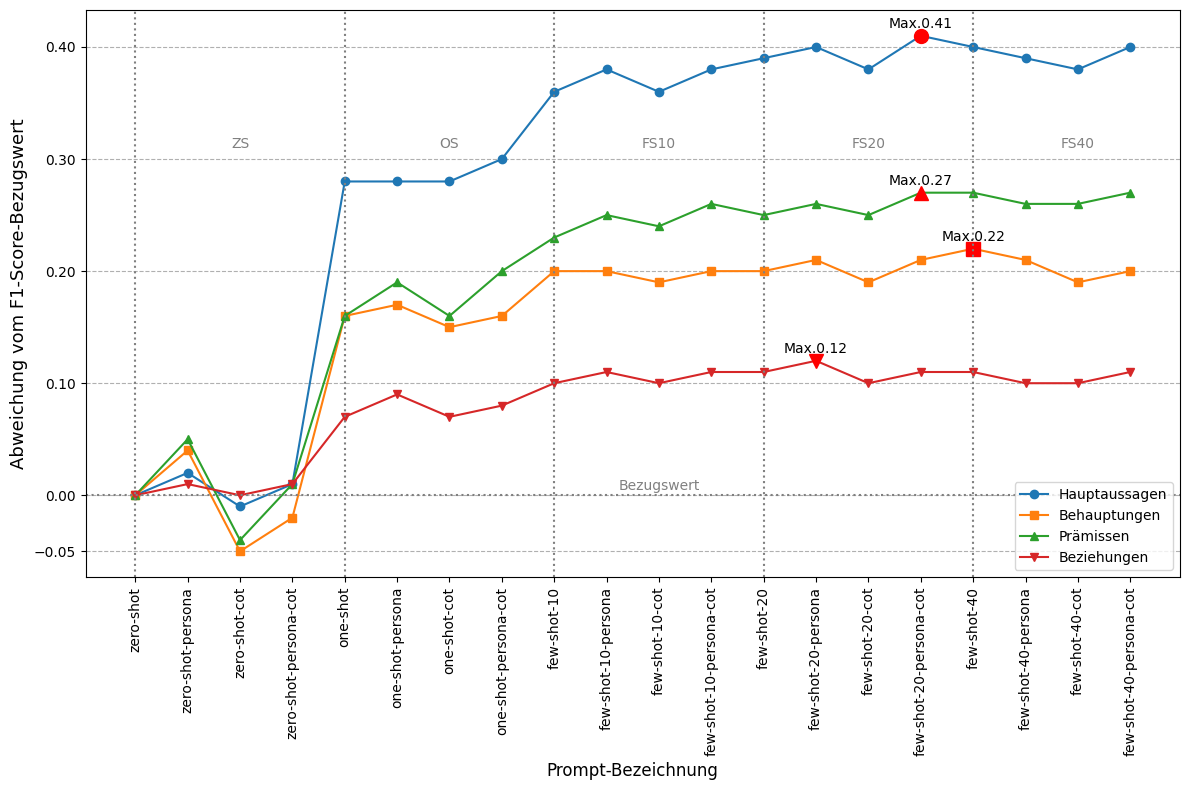

In [52]:
# Plot the baseline differences for each prompt
fig, ax = plt.subplots(figsize=(12, 8)) # figheight=10, figwidth=15 figsize=(15, 12)

linecolor = 'grey'
annotation_color = 'grey'
grouped_eval_metric_df.sort_values(by='tokens', ascending=True, inplace=True)
ax.plot(grouped_eval_metric_df['Prompt'], grouped_eval_metric_df['mc_diff_baseline'], label='Hauptaussagen', marker='o')
ax.plot(grouped_eval_metric_df['Prompt'], grouped_eval_metric_df['c_diff_baseline'], label='Behauptungen', marker='s')
ax.plot(grouped_eval_metric_df['Prompt'], grouped_eval_metric_df['p_diff_baseline'], label='Prämissen', marker='^')
ax.plot(grouped_eval_metric_df['Prompt'], grouped_eval_metric_df['r_diff_baseline'], label='Beziehungen', marker='v')

# Markiere die Maximalwerte für MC, C. P, R, wenn es mehrere x-Werte mit dem gleichen y-Wert gibt, soll der Wert mit der niedrigsten Tokenanzahl markiert werden
max_mc = grouped_eval_metric_df.loc[grouped_eval_metric_df['mc_diff_baseline'].idxmax()]
max_c = grouped_eval_metric_df.loc[grouped_eval_metric_df['c_diff_baseline'].idxmax()]
max_p = grouped_eval_metric_df.loc[grouped_eval_metric_df['p_diff_baseline'].idxmax()]
max_r = grouped_eval_metric_df.loc[grouped_eval_metric_df['r_diff_baseline'].idxmax()]

# Change the marker for the maximum values
ax.plot(max_mc['Prompt'], max_mc['mc_diff_baseline'], 'ro', markersize=10)
ax.plot(max_c['Prompt'], max_c['c_diff_baseline'], 'rs', markersize=10)
ax.plot(max_p['Prompt'], max_p['p_diff_baseline'], 'r^', markersize=10)
ax.plot(max_r['Prompt'], max_r['r_diff_baseline'], 'rv', markersize=10)

ax.annotate(f'Max.{max_mc["mc_diff_baseline"]:.2f}', xy=(max_mc['Prompt'], max_mc['mc_diff_baseline']), xytext=(max_mc['Prompt'], max_mc['mc_diff_baseline'] + 0.007), fontsize=10, ha='center', color='black')
ax.annotate(f'Max.{max_c["c_diff_baseline"]:.2f}', xy=(max_c['Prompt'], max_c['c_diff_baseline']), xytext=(max_c['Prompt'], max_c['c_diff_baseline'] + 0.007), fontsize=10, ha='center', color='black')
ax.annotate(f'Max.{max_p["p_diff_baseline"]:.2f}', xy=(max_p['Prompt'], max_p['p_diff_baseline']), xytext=(max_p['Prompt'], max_p['p_diff_baseline'] + 0.007), fontsize=10, ha='center', color='black')
ax.annotate(f'Max.{max_r["r_diff_baseline"]:.2f}', xy=(max_r['Prompt'], max_r['r_diff_baseline']), xytext=(max_r['Prompt'], max_r['r_diff_baseline'] + 0.007), fontsize=10, ha='center', color='black')

# Vertikale Linien für die verschiedenen Prompt-Gruppen
plt.axvline(x='zero-shot', color=linecolor, linestyle='dotted')
plt.axvline(x='one-shot', color=linecolor, linestyle='dotted')
plt.axvline(x='few-shot-10', color=linecolor, linestyle='dotted')
plt.axvline(x='few-shot-20', color=linecolor, linestyle='dotted')
plt.axvline(x='few-shot-40', color=linecolor, linestyle='dotted')
plt.axhline(y=0, color=linecolor, linestyle='dotted')

# Beschriftungen für die vertikalen Linien
plt.annotate('ZS', xy=('zero-shot', 0.31), xytext=('zero-shot-cot', 0.31), fontsize=10, ha='center', color=annotation_color)
plt.annotate('OS', xy=('one-shot', 0.31), xytext=('one-shot-cot', 0.31), fontsize=10, ha='center', color=annotation_color)
plt.annotate('FS10', xy=('few-shot-10', 0.31), xytext=('few-shot-10-cot', 0.31), fontsize=10, ha='center', color=annotation_color)
plt.annotate('FS20', xy=('few-shot-20', 0.31), xytext=('few-shot-20-cot', 0.31), fontsize=10, ha='center', color=annotation_color)
plt.annotate('FS40', xy=('few-shot-40', 0.31), xytext=('few-shot-40-cot', 0.31), fontsize=10, ha='center', color=annotation_color)
plt.annotate('Bezugswert', xy=('zero-shot', 0), xytext=('few-shot-10-cot', 0.005), fontsize=10, ha='center', color=annotation_color)

# Set titles and labels
# ax.set_title('Abweichung der F1-Scores vom Bezugswert', fontsize=15) # nicht benötigt, da Titel im Bericht bereits vorhanden
ax.set_xlabel('Prompt-Bezeichnung', fontsize=12)
ax.set_ylabel('Abweichung vom F1-Score-Bezugswert', fontsize=13)
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='both', which='major')
# Anpassung der Schritte auf der y-Achse
plt.yticks([-0.05, 0, 0.1, 0.2, 0.3, 0.4])
# the y axis should be log scaled
#ax.set_yscale('log')

# add a grid
plt.grid(axis='y', linestyle='--')

# Add legend
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

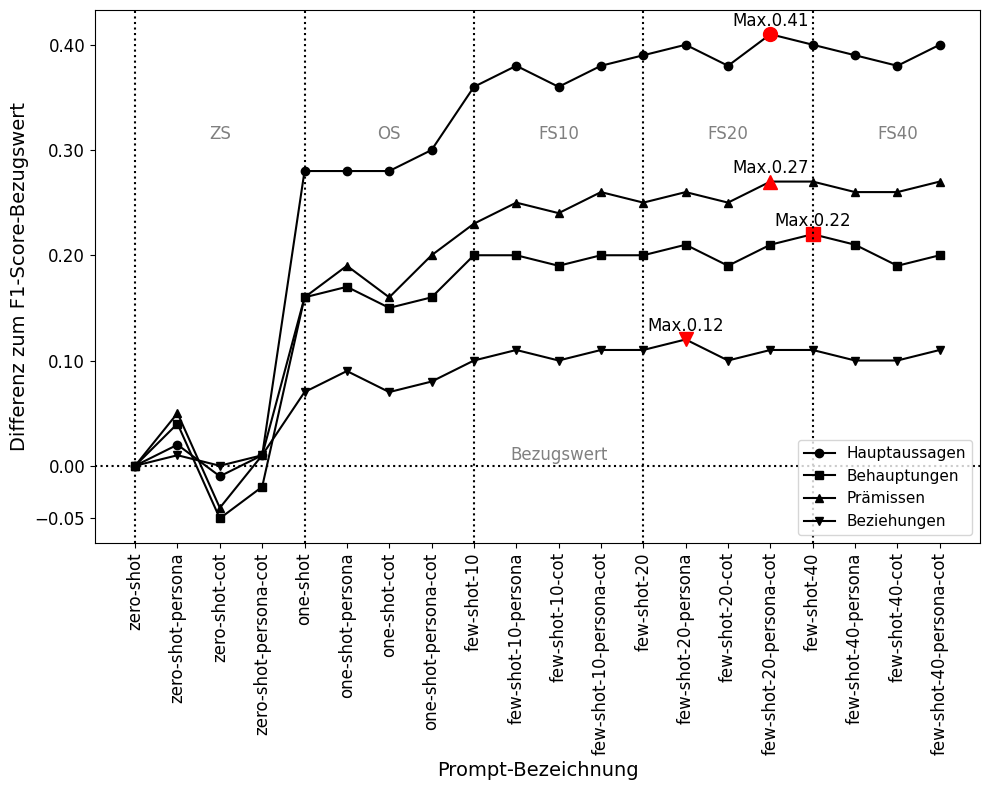

In [53]:
# Plot the baseline differences for each prompt
fig, ax = plt.subplots(figsize=(10, 8)) # bedeutung figsize(horizontale, vertikale)

linecolor = 'black'
annotation_color = 'grey'
highlight_color = 'red'
grouped_eval_metric_df.sort_values(by='tokens', ascending=True, inplace=True)
ax.plot(grouped_eval_metric_df['Prompt'], grouped_eval_metric_df['mc_diff_baseline'], label='Hauptaussagen', marker='o', color=linecolor)
ax.plot(grouped_eval_metric_df['Prompt'], grouped_eval_metric_df['c_diff_baseline'], label='Behauptungen', marker='s', color=linecolor)
ax.plot(grouped_eval_metric_df['Prompt'], grouped_eval_metric_df['p_diff_baseline'], label='Prämissen', marker='^', color=linecolor)
ax.plot(grouped_eval_metric_df['Prompt'], grouped_eval_metric_df['r_diff_baseline'], label='Beziehungen', marker='v', color=linecolor)

# Markiere die Maximalwerte für MC, C. P, R, wenn es mehrere x-Werte mit dem gleichen y-Wert gibt, soll der Wert mit der niedrigsten Tokenanzahl markiert werden
max_mc = grouped_eval_metric_df.loc[grouped_eval_metric_df['mc_diff_baseline'].idxmax()]
max_c = grouped_eval_metric_df.loc[grouped_eval_metric_df['c_diff_baseline'].idxmax()]
max_p = grouped_eval_metric_df.loc[grouped_eval_metric_df['p_diff_baseline'].idxmax()]
max_r = grouped_eval_metric_df.loc[grouped_eval_metric_df['r_diff_baseline'].idxmax()]

# Change the marker for the maximum values
ax.plot(max_mc['Prompt'], max_mc['mc_diff_baseline'], 'o', markersize=10, color=highlight_color)
ax.plot(max_c['Prompt'], max_c['c_diff_baseline'], 's', markersize=10, color=highlight_color)
ax.plot(max_p['Prompt'], max_p['p_diff_baseline'], '^', markersize=10, color=highlight_color)
ax.plot(max_r['Prompt'], max_r['r_diff_baseline'], 'v', markersize=10, color=highlight_color)

ax.annotate(f'Max.{max_mc["mc_diff_baseline"]:.2f}', xy=(max_mc['Prompt'], max_mc['mc_diff_baseline']), xytext=(max_mc['Prompt'], max_mc['mc_diff_baseline'] + 0.008), fontsize=12, ha='center', color=linecolor)
ax.annotate(f'Max.{max_c["c_diff_baseline"]:.2f}', xy=(max_c['Prompt'], max_c['c_diff_baseline']), xytext=(max_c['Prompt'], max_c['c_diff_baseline'] + 0.008), fontsize=12, ha='center', color=linecolor)
ax.annotate(f'Max.{max_p["p_diff_baseline"]:.2f}', xy=(max_p['Prompt'], max_p['p_diff_baseline']), xytext=(max_p['Prompt'], max_p['p_diff_baseline'] + 0.008), fontsize=12, ha='center', color=linecolor)
ax.annotate(f'Max.{max_r["r_diff_baseline"]:.2f}', xy=(max_r['Prompt'], max_r['r_diff_baseline']), xytext=(max_r['Prompt'], max_r['r_diff_baseline'] + 0.008), fontsize=12, ha='center', color=linecolor)

# Vertikale Linien für die verschiedenen Prompt-Gruppen
plt.axvline(x='zero-shot', color=linecolor, linestyle='dotted')
plt.axvline(x='one-shot', color=linecolor, linestyle='dotted')
plt.axvline(x='few-shot-10', color=linecolor, linestyle='dotted')
plt.axvline(x='few-shot-20', color=linecolor, linestyle='dotted')
plt.axvline(x='few-shot-40', color=linecolor, linestyle='dotted')
plt.axhline(y=0, color=linecolor, linestyle='dotted')

# Beschriftungen für die vertikalen Linien
plt.annotate('ZS', xy=('zero-shot', 0.31), xytext=('zero-shot-cot', 0.31), fontsize=12, ha='center', color=annotation_color)
plt.annotate('OS', xy=('one-shot', 0.31), xytext=('one-shot-cot', 0.31), fontsize=12, ha='center', color=annotation_color)
plt.annotate('FS10', xy=('few-shot-10', 0.31), xytext=('few-shot-10-cot', 0.31), fontsize=12, ha='center', color=annotation_color)
plt.annotate('FS20', xy=('few-shot-20', 0.31), xytext=('few-shot-20-cot', 0.31), fontsize=12, ha='center', color=annotation_color)
plt.annotate('FS40', xy=('few-shot-40', 0.31), xytext=('few-shot-40-cot', 0.31), fontsize=12, ha='center', color=annotation_color)
plt.annotate('Bezugswert', xy=('zero-shot', 0), xytext=('few-shot-10-cot', 0.005), fontsize=12, ha='center', color=annotation_color)

# Set titles and labels
# ax.set_title('Abweichung der F1-Scores vom Bezugswert', fontsize=15) # nicht benötigt, da Titel im Bericht bereits vorhanden
ax.set_xlabel('Prompt-Bezeichnung', fontsize=14)
ax.set_ylabel('Differenz zum F1-Score-Bezugswert', fontsize=14)
ax.tick_params(axis='x', rotation=90, labelsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
# Anpassung der Schritte auf der y-Achse
plt.yticks([-0.05, 0, 0.1, 0.2, 0.3, 0.4], fontsize=12)
# the y axis should be log scaled
#ax.set_yscale('log')

# add a grid
#plt.grid(axis='y', linestyle='--')

# Add legend
ax.legend(loc='lower right', fontsize=11)

plt.tight_layout()
plt.show()

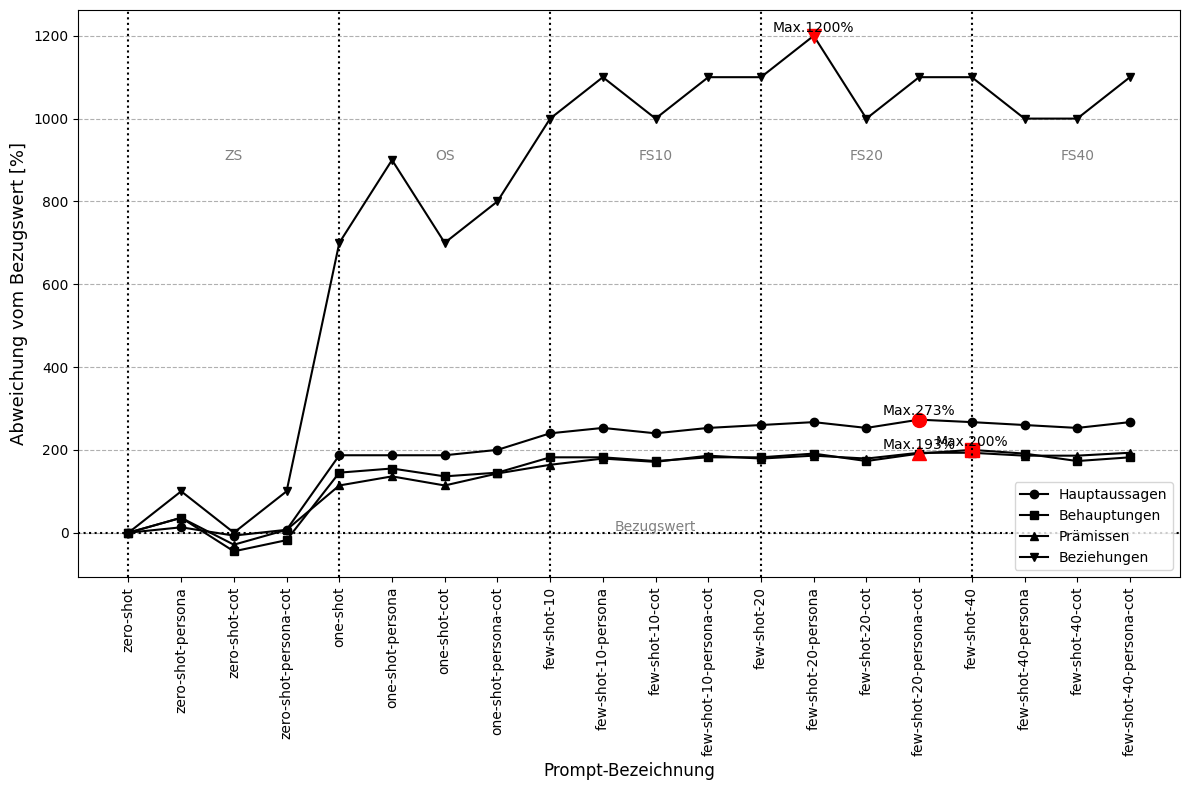

In [54]:
# Plot the baseline differences for each prompt
fig, ax = plt.subplots(figsize=(12, 8)) # figheight=10, figwidth=15 figsize=(15, 12)

linecolor = 'black'
annotation_color = 'grey'
highlight_color = 'red'
grouped_eval_metric_df.sort_values(by='tokens', ascending=True, inplace=True)
ax.plot(grouped_eval_metric_df['Prompt'], grouped_eval_metric_df['mc_diff_baseline%'], label='Hauptaussagen', marker='o', color=linecolor)
ax.plot(grouped_eval_metric_df['Prompt'], grouped_eval_metric_df['c_diff_baseline%'], label='Behauptungen', marker='s', color=linecolor)
ax.plot(grouped_eval_metric_df['Prompt'], grouped_eval_metric_df['p_diff_baseline%'], label='Prämissen', marker='^', color=linecolor)
ax.plot(grouped_eval_metric_df['Prompt'], grouped_eval_metric_df['r_diff_baseline%'], label='Beziehungen', marker='v', color=linecolor)

# Markiere die Maximalwerte für MC, C. P, R, wenn es mehrere x-Werte mit dem gleichen y-Wert gibt, soll der Wert mit der niedrigsten Tokenanzahl markiert werden
max_mc = grouped_eval_metric_df.loc[grouped_eval_metric_df['mc_diff_baseline%'].idxmax()]
max_c = grouped_eval_metric_df.loc[grouped_eval_metric_df['c_diff_baseline%'].idxmax()]
max_p = grouped_eval_metric_df.loc[grouped_eval_metric_df['p_diff_baseline%'].idxmax()]
max_r = grouped_eval_metric_df.loc[grouped_eval_metric_df['r_diff_baseline%'].idxmax()]

# Change the marker for the maximum values
ax.plot(max_mc['Prompt'], max_mc['mc_diff_baseline%'], 'o', markersize=10, color=highlight_color)
ax.plot(max_c['Prompt'], max_c['c_diff_baseline%'], 's', markersize=10, color=highlight_color)
ax.plot(max_p['Prompt'], max_p['p_diff_baseline%'], '^', markersize=10, color=highlight_color)
ax.plot(max_r['Prompt'], max_r['r_diff_baseline%'], 'v', markersize=10, color=highlight_color)

ax.annotate(f'Max.{int(max_mc["mc_diff_baseline%"])}%', xy=(max_mc['Prompt'], max_mc['mc_diff_baseline%']), xytext=(max_mc['Prompt'], max_mc['mc_diff_baseline%'] + 10), fontsize=10, ha='center', color=linecolor)
ax.annotate(f'Max.{int(max_c["c_diff_baseline%"])}%', xy=(max_c['Prompt'], max_c['c_diff_baseline%']), xytext=(max_c['Prompt'], max_c['c_diff_baseline%'] + 10), fontsize=10, ha='center', color=linecolor)
ax.annotate(f'Max.{int(max_p["p_diff_baseline%"])}%', xy=(max_p['Prompt'], max_p['p_diff_baseline%']), xytext=(max_p['Prompt'], max_p['p_diff_baseline%'] + 10), fontsize=10, ha='center', color=linecolor)
ax.annotate(f'Max.{int(max_r["r_diff_baseline%"])}%', xy=(max_r['Prompt'], max_r['r_diff_baseline%']), xytext=(max_r['Prompt'], max_r['r_diff_baseline%'] + 10), fontsize=10, ha='center', color=linecolor)

# Vertikale Linien für die verschiedenen Prompt-Gruppen
plt.axvline(x='zero-shot', color=linecolor, linestyle='dotted')
plt.axvline(x='one-shot', color=linecolor, linestyle='dotted')
plt.axvline(x='few-shot-10', color=linecolor, linestyle='dotted')
plt.axvline(x='few-shot-20', color=linecolor, linestyle='dotted')
plt.axvline(x='few-shot-40', color=linecolor, linestyle='dotted')
plt.axhline(y=0, color=linecolor, linestyle='dotted')

# Beschriftungen für die vertikalen Linien
plt.annotate('ZS', xy=('zero-shot', 900), xytext=('zero-shot-cot', 900), fontsize=10, ha='center', color=annotation_color)
plt.annotate('OS', xy=('one-shot', 900), xytext=('one-shot-cot', 900), fontsize=10, ha='center', color=annotation_color)
plt.annotate('FS10', xy=('few-shot-10', 900), xytext=('few-shot-10-cot', 900), fontsize=10, ha='center', color=annotation_color)
plt.annotate('FS20', xy=('few-shot-20', 900), xytext=('few-shot-20-cot', 900), fontsize=10, ha='center', color=annotation_color)
plt.annotate('FS40', xy=('few-shot-40', 900), xytext=('few-shot-40-cot', 900), fontsize=10, ha='center', color=annotation_color)
plt.annotate('Bezugswert', xy=('zero-shot', 0), xytext=('few-shot-10-cot', 5), fontsize=10, ha='center', color=annotation_color)

# Set titles and labels
# ax.set_title('Abweichung der F1-Scores vom Bezugswert', fontsize=15) # nicht benötigt, da Titel im Bericht bereits vorhanden
ax.set_xlabel('Prompt-Bezeichnung', fontsize=12)
ax.set_ylabel('Abweichung vom Bezugswert [%]', fontsize=13)
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='both', which='major')
# Anpassung der Schritte auf der y-Achse
#plt.yticks([-0.05, 0, 0.1, 0.2, 0.3, 0.4])
# the y axis should be log scaled
#ax.set_yscale('log')

# add a grid
plt.grid(axis='y', linestyle='--')

# Add legend
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

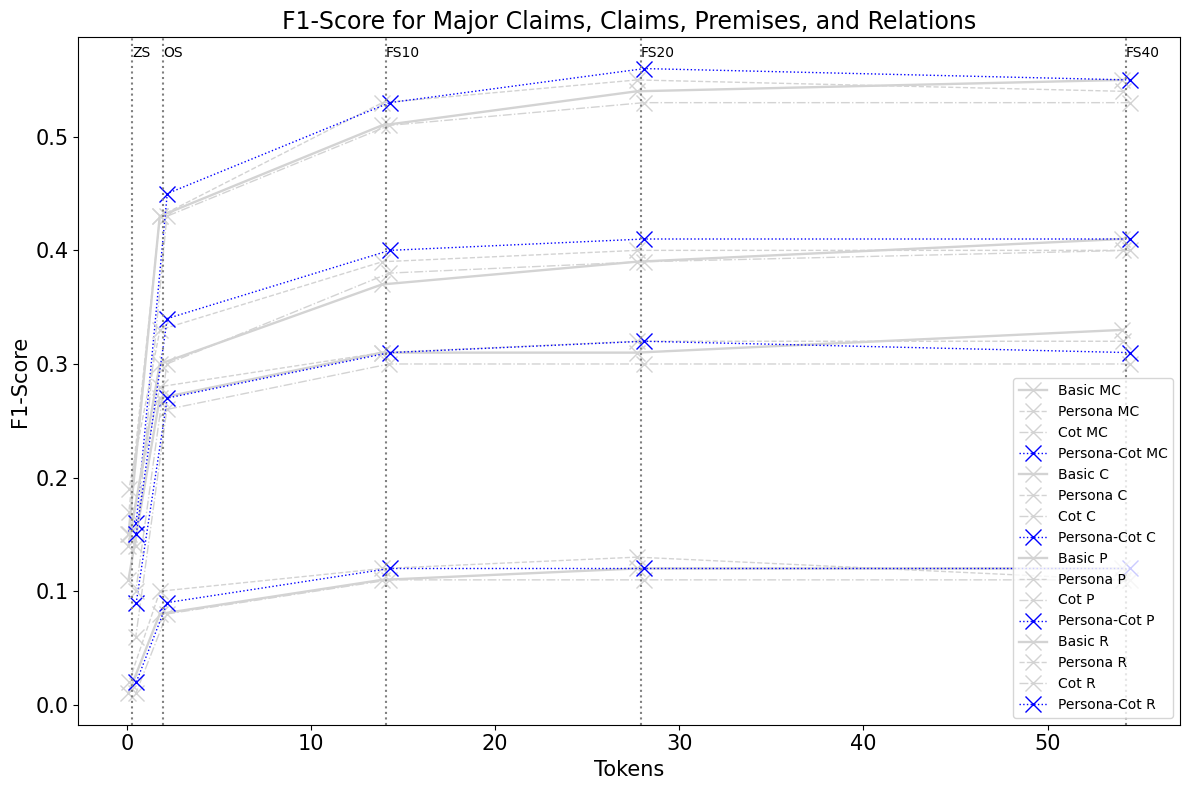

In [55]:
fig, ax = plt.subplots(figsize=(12, 8))

# Format x-axis ticks to show per 1000 tokens
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1000)}'))

# Übergreifende Einstellungen
vertical_linecolor = 'grey'
basic_linestyle = 'solid'
persona_linestyle = 'dashed'
cot_linestyle = 'dashdot'
persona_cot_linestyle = 'dotted'
linewidth_basic = 1.7
linewidth_rest = 1
label_fontsize = 15
title_fontsize = 17
annotation_fontsize = 10
legend_loc = 'lower right'
marker = "x"
markersize = 11

# Plot for Major Claims
ax.plot(eval_metric_basic_df['tokens'], eval_metric_basic_df['F1_Score_MC'], label='Basic MC', marker=marker, markersize=markersize, linestyle=basic_linestyle, linewidth=linewidth_basic, color='lightgrey')
ax.plot(eval_metric_persona_df['tokens'], eval_metric_persona_df['F1_Score_MC'], label='Persona MC', marker=marker, markersize=markersize, linestyle=persona_linestyle, linewidth=linewidth_rest, color='lightgrey')
ax.plot(eval_metric_cot_df['tokens'], eval_metric_cot_df['F1_Score_MC'], label='Cot MC', marker=marker, markersize=markersize, linestyle=cot_linestyle, linewidth=linewidth_rest, color='lightgrey')
ax.plot(eval_metric_persona_cot_df['tokens'], eval_metric_persona_cot_df['F1_Score_MC'], label='Persona-Cot MC', marker=marker, markersize=markersize, linestyle=persona_cot_linestyle, linewidth=linewidth_rest, color='blue')

# Plot for Claims
ax.plot(eval_metric_basic_df['tokens'], eval_metric_basic_df['F1_Score_C'], label='Basic C', marker=marker, markersize=markersize, linestyle=basic_linestyle, linewidth=linewidth_basic, color='lightgrey')
ax.plot(eval_metric_persona_df['tokens'], eval_metric_persona_df['F1_Score_C'], label='Persona C', marker=marker, markersize=markersize, linestyle=persona_linestyle, linewidth=linewidth_rest, color='lightgrey')
ax.plot(eval_metric_cot_df['tokens'], eval_metric_cot_df['F1_Score_C'], label='Cot C', marker=marker, markersize=markersize, linestyle=cot_linestyle, linewidth=linewidth_rest, color='lightgrey')
ax.plot(eval_metric_persona_cot_df['tokens'], eval_metric_persona_cot_df['F1_Score_C'], label='Persona-Cot C', marker=marker, markersize=markersize, linestyle=persona_cot_linestyle, linewidth=linewidth_rest, color='blue')

# Plot for Premises
ax.plot(eval_metric_basic_df['tokens'], eval_metric_basic_df['F1_Score_P'], label='Basic P', marker=marker, markersize=markersize, linestyle=basic_linestyle, linewidth=linewidth_basic, color='lightgrey')
ax.plot(eval_metric_persona_df['tokens'], eval_metric_persona_df['F1_Score_P'], label='Persona P', marker=marker, markersize=markersize, linestyle=persona_linestyle, linewidth=linewidth_rest, color='lightgrey')
ax.plot(eval_metric_cot_df['tokens'], eval_metric_cot_df['F1_Score_P'], label='Cot P', marker=marker, markersize=markersize, linestyle=cot_linestyle, linewidth=linewidth_rest, color='lightgrey')
ax.plot(eval_metric_persona_cot_df['tokens'], eval_metric_persona_cot_df['F1_Score_P'], label='Persona-Cot P', marker=marker, markersize=markersize, linestyle=persona_cot_linestyle, linewidth=linewidth_rest, color='blue')

# Plot for Relations
ax.plot(eval_metric_basic_df['tokens'], eval_metric_basic_df['F1_Score_R'], label='Basic R', marker=marker, markersize=markersize, linestyle=basic_linestyle, linewidth=linewidth_basic, color='lightgrey')
ax.plot(eval_metric_persona_df['tokens'], eval_metric_persona_df['F1_Score_R'], label='Persona R', marker=marker, markersize=markersize, linestyle=persona_linestyle, linewidth=linewidth_rest, color='lightgrey')
ax.plot(eval_metric_cot_df['tokens'], eval_metric_cot_df['F1_Score_R'], label='Cot R', marker=marker, markersize=markersize, linestyle=cot_linestyle, linewidth=linewidth_rest, color='lightgrey')
ax.plot(eval_metric_persona_cot_df['tokens'], eval_metric_persona_cot_df['F1_Score_R'], label='Persona-Cot R', marker=marker, markersize=markersize, linestyle=persona_cot_linestyle, linewidth=linewidth_rest, color='blue')

# Set labels and title
ax.set_xlabel('Tokens', fontsize=label_fontsize)
ax.set_ylabel('F1-Score', fontsize=label_fontsize)
ax.set_title('F1-Score for Major Claims, Claims, Premises, and Relations', fontsize=title_fontsize)
ax.tick_params(axis='both', which='major', labelsize=label_fontsize)
ax.legend(loc=legend_loc)

# Vertikale Linien
ax.axvline(x=zs_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Zero-shot Mean Tokens')
ax.axvline(x=os_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='One-shot Mean Tokens')
ax.axvline(x=fs10_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-10 Mean Tokens')
ax.axvline(x=fs20_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-20 Mean Tokens')
ax.axvline(x=fs40_mean_tokens, color=vertical_linecolor, linestyle='dotted', label='Few-shot-40 Mean Tokens')

# Annotations
ax.annotate('ZS', xy=(zs_mean_tokens, 0.57), xytext=(zs_mean_tokens, 0.57), fontsize=annotation_fontsize)
ax.annotate('OS', xy=(os_mean_tokens, 0.57), xytext=(os_mean_tokens, 0.57), fontsize=annotation_fontsize)
ax.annotate('FS10', xy=(fs10_mean_tokens, 0.57), xytext=(fs10_mean_tokens, 0.57), xycoords='data', fontsize=annotation_fontsize)
ax.annotate('FS20', xy=(fs20_mean_tokens, 0.57), xytext=(fs20_mean_tokens, 0.57), xycoords='data', fontsize=annotation_fontsize)
ax.annotate('FS40', xy=(fs40_mean_tokens, 0.57), xytext=(fs40_mean_tokens, 0.57), xycoords='data', fontsize=annotation_fontsize)

plt.tight_layout()
plt.show()


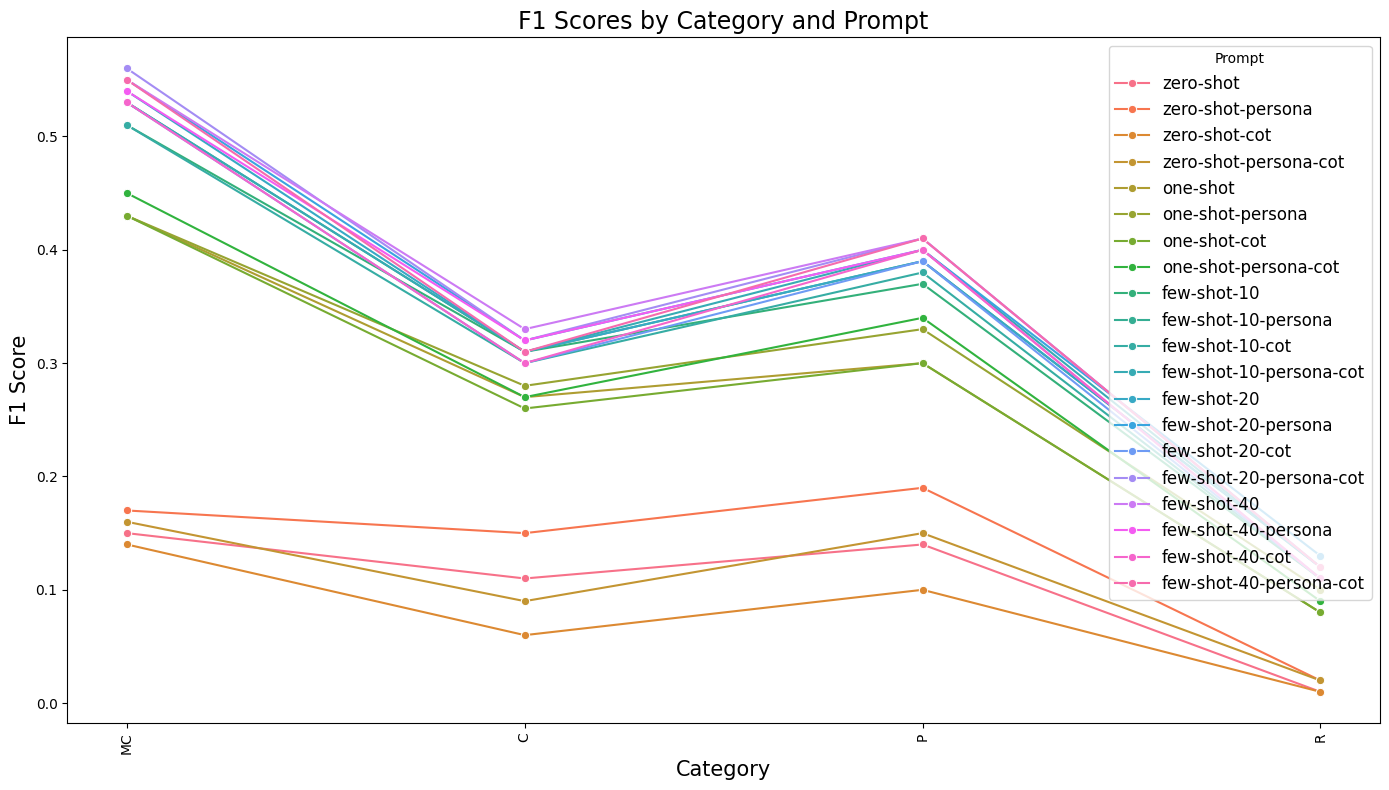

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Category': ['MC'] * len(grouped_eval_metric_df) + ['C'] * len(grouped_eval_metric_df) + ['P'] * len(grouped_eval_metric_df) + ['R'] * len(grouped_eval_metric_df),
    'F1_Score': list(grouped_eval_metric_df['F1_Score_MC']) + list(grouped_eval_metric_df['F1_Score_C']) + list(grouped_eval_metric_df['F1_Score_P']) + list(grouped_eval_metric_df['F1_Score_R']),
    'Prompt': list(grouped_eval_metric_df['Prompt']) * 4
})

# Create the line plot
plt.figure(figsize=(14, 8))
sns.lineplot(x='Category', y='F1_Score', hue='Prompt', data=plot_data, marker='o')

# Customize the plot
plt.xlabel('Category', fontsize=15)
plt.ylabel('F1 Score', fontsize=15)
plt.title('F1 Scores by Category and Prompt', fontsize=17)
plt.xticks(rotation=90)
plt.legend(title='Prompt', fontsize=12, loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()


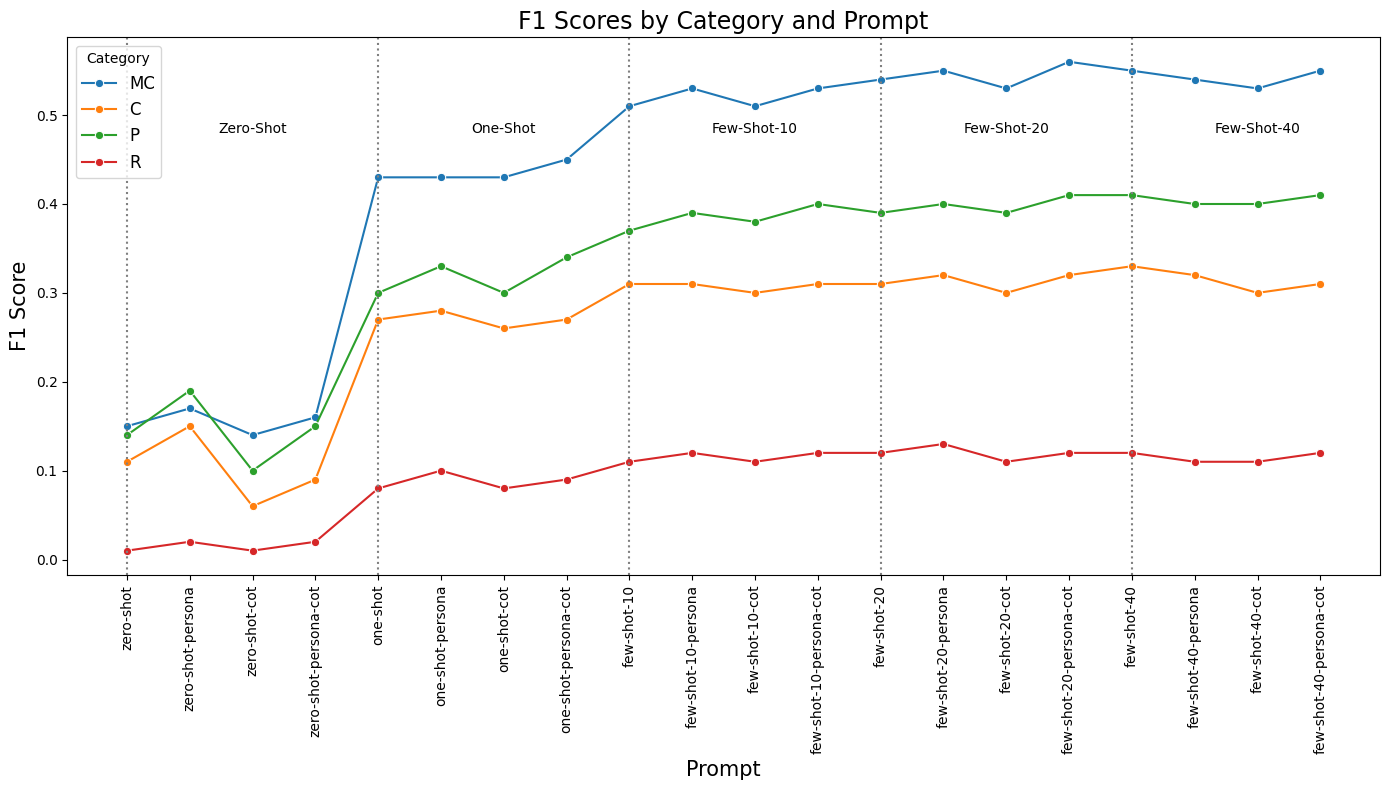

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the categories and their corresponding colors
categories = ['MC', 'C', 'P', 'R']

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Category': ['MC'] * len(grouped_eval_metric_df) + ['C'] * len(grouped_eval_metric_df) + ['P'] * len(grouped_eval_metric_df) + ['R'] * len(grouped_eval_metric_df),
    'F1_Score': list(grouped_eval_metric_df['F1_Score_MC']) + list(grouped_eval_metric_df['F1_Score_C']) + list(grouped_eval_metric_df['F1_Score_P']) + list(grouped_eval_metric_df['F1_Score_R']),
    'Prompt': list(grouped_eval_metric_df['Prompt']) * 4
})

# Create the line plot
plt.figure(figsize=(14, 8))
sns.lineplot(x='Prompt', y='F1_Score', hue='Category', data=plot_data, marker='o')

# # Vertikale Linien für die verschiedenen Prompt-Gruppen
plt.axvline(x='zero-shot', color='grey', linestyle='dotted')
plt.axvline(x='one-shot', color='grey', linestyle='dotted')
plt.axvline(x='few-shot-10', color='grey', linestyle='dotted')
plt.axvline(x='few-shot-20', color='grey', linestyle='dotted')
plt.axvline(x='few-shot-40', color='grey', linestyle='dotted')
# Beschriftungen für die vertikalen Linien
plt.annotate('Zero-Shot', xy=('zero-shot', 0.48), xytext=('zero-shot-cot', 0.48), fontsize=10, ha='center')
plt.annotate('One-Shot', xy=('one-shot', 0.48), xytext=('one-shot-cot', 0.48), fontsize=10, ha='center')
plt.annotate('Few-Shot-10', xy=('few-shot-10', 0.48), xytext=('few-shot-10-cot', 0.48), fontsize=10, ha='center')
plt.annotate('Few-Shot-20', xy=('few-shot-20', 0.48), xytext=('few-shot-20-cot', 0.48), fontsize=10, ha='center')
plt.annotate('Few-Shot-40', xy=('few-shot-40', 0.48), xytext=('few-shot-40-cot', 0.48), fontsize=10, ha='center')

# Customize the plot
plt.xlabel('Prompt', fontsize=15)
plt.ylabel('F1 Score', fontsize=15)
plt.title('F1 Scores by Category and Prompt', fontsize=17)
plt.xticks(rotation=90)
plt.legend(title='Category', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


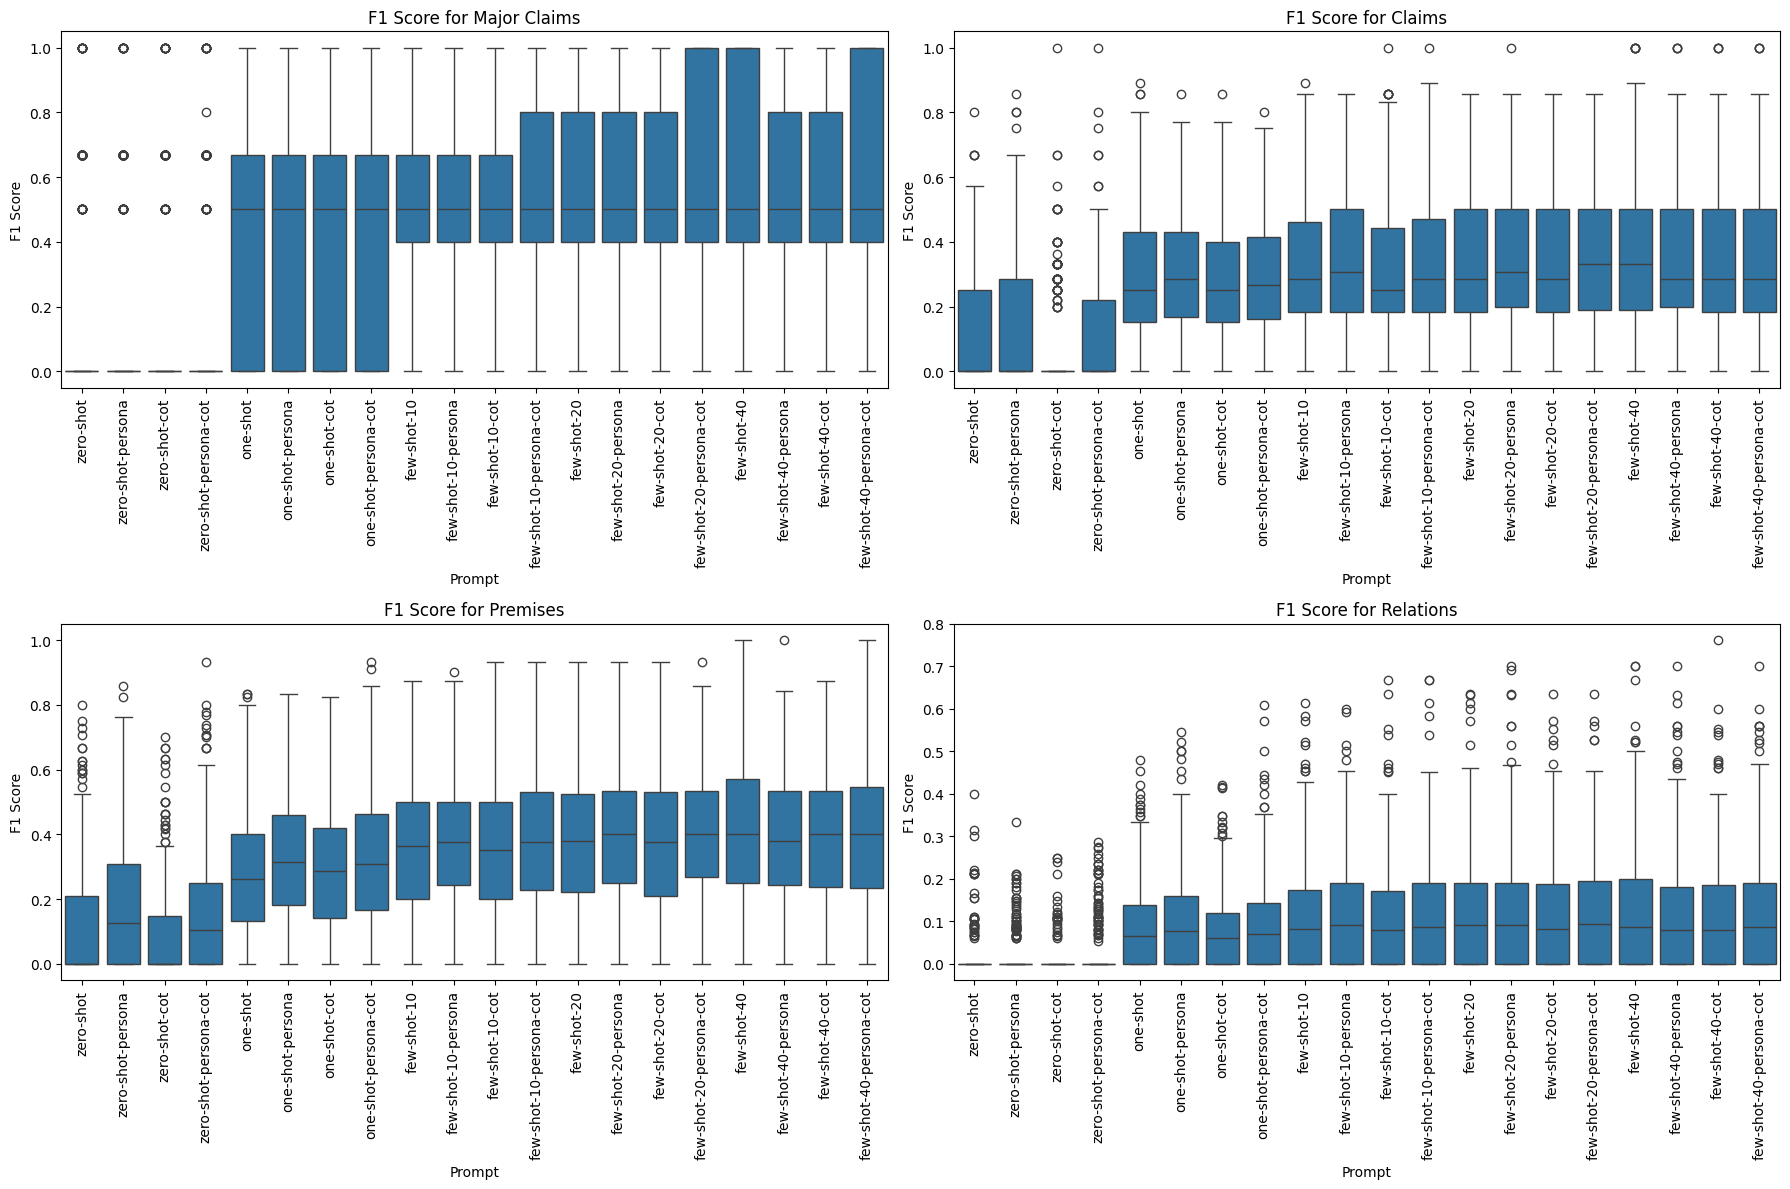

In [58]:
# Create 4 subplots as boxplots for MC, C, P, and R using eval_metric_df as data
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Boxplot for Major Claims (MC)
sns.boxplot(data=eval_metric_df, x='Prompt', y='F1_Score_MC', ax=axes[0, 0])
axes[0, 0].set_title('F1 Score for Major Claims')
axes[0, 0].set_xlabel('Prompt')
axes[0, 0].set_ylabel('F1 Score')
axes[0, 0].tick_params(axis='x', rotation=90)

# Boxplot for Claims (C)
sns.boxplot(data=eval_metric_df, x='Prompt', y='F1_Score_C', ax=axes[0, 1])
axes[0, 1].set_title('F1 Score for Claims')
axes[0, 1].set_xlabel('Prompt')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].tick_params(axis='x', rotation=90)

# Boxplot for Premises (P)
sns.boxplot(data=eval_metric_df, x='Prompt', y='F1_Score_P', ax=axes[1, 0])
axes[1, 0].set_title('F1 Score for Premises')
axes[1, 0].set_xlabel('Prompt')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].tick_params(axis='x', rotation=90)

# Boxplot for Relations (R)
sns.boxplot(data=eval_metric_df, x='Prompt', y='F1_Score_R', ax=axes[1, 1])
axes[1, 1].set_title('F1 Score for Relations')
axes[1, 1].set_xlabel('Prompt')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

## Kennzahl F1-Score pro Token bestimmen

In [59]:
# Create a new DataFrame with the token count and F1-Score for each prompt
f1_per_token_df = grouped_eval_metric_df[['Prompt', 'tokens', 'F1_Score_MC', 'F1_Score_C', 'F1_Score_P', 'F1_Score_R']].copy()
f1_per_token_df

Prompt  tokens  F1_Score_MC  F1_Score_C  F1_Score_P  \
16                zero-shot      82         0.15        0.11        0.14   
18        zero-shot-persona     105         0.17        0.15        0.19   
17            zero-shot-cot     480         0.14        0.06        0.10   
19    zero-shot-persona-cot     503         0.16        0.09        0.15   
12                 one-shot    1780         0.43        0.27        0.30   
14         one-shot-persona    1790         0.43        0.28        0.33   
13             one-shot-cot    2166         0.43        0.26        0.30   
15     one-shot-persona-cot    2189         0.45        0.27        0.34   
0               few-shot-10   13848         0.51        0.31        0.37   
2       few-shot-10-persona   13871         0.53        0.31        0.39   
1           few-shot-10-cot   14247         0.51        0.30        0.38   
3   few-shot-10-persona-cot   14270         0.53        0.31        0.40   
4               few-shot-20   27681         0.54        0.31        0.39   
6       few-shot-20-persona   27704         0.55        0.32        0.40   
5           few-shot-20-cot   28080         0.53        0.30        0.39   
7   few-shot-20-persona-cot   28103         0.56        0.32        0.41   
8               few-shot-40   54048         0.55        0.33        0.41   
10      few-shot-40-persona   54071         0.54        0.32        0.40   
9           few-shot-40-cot   54447         0.53        0.30        0.40   
11  few-shot-40-persona-cot   54470         0.55        0.31        0.41   

    F1_Score_R  
16        0.01  
18        0.02  
17        0.01  
19        0.02  
12        0.08  
14        0.10  
13        0.08  
15        0.09  
0         0.11  
2         0.12  
1         0.11  
3         0.12  
4         0.12  
6         0.13  
5         0.11  
7         0.12  
8         0.12  
10        0.11  
9         0.11  
11        0.12

In [60]:
# F1-Score pro 1000 Token für die Prompts berechnen
f1_per_token_df['F1_Score_MC_per_token'] = round(f1_per_token_df['F1_Score_MC'] / (f1_per_token_df['tokens'] / 1000), 2)
f1_per_token_df['F1_Score_C_per_token'] = round(f1_per_token_df['F1_Score_C'] / (f1_per_token_df['tokens'] / 1000), 2)
f1_per_token_df['F1_Score_P_per_token'] = round(f1_per_token_df['F1_Score_P'] / (f1_per_token_df['tokens'] / 1000), 2)
f1_per_token_df['F1_Score_R_per_token'] = round(f1_per_token_df['F1_Score_R'] / (f1_per_token_df['tokens'] / 1000), 2)

f1_per_token_df[['Prompt', 'tokens', 'F1_Score_MC_per_token', 'F1_Score_C_per_token', 'F1_Score_P_per_token', 'F1_Score_R_per_token']]

Prompt  tokens  F1_Score_MC_per_token  \
16                zero-shot      82                   1.83   
18        zero-shot-persona     105                   1.62   
17            zero-shot-cot     480                   0.29   
19    zero-shot-persona-cot     503                   0.32   
12                 one-shot    1780                   0.24   
14         one-shot-persona    1790                   0.24   
13             one-shot-cot    2166                   0.20   
15     one-shot-persona-cot    2189                   0.21   
0               few-shot-10   13848                   0.04   
2       few-shot-10-persona   13871                   0.04   
1           few-shot-10-cot   14247                   0.04   
3   few-shot-10-persona-cot   14270                   0.04   
4               few-shot-20   27681                   0.02   
6       few-shot-20-persona   27704                   0.02   
5           few-shot-20-cot   28080                   0.02   
7   few-shot-20-persona-cot   28103                   0.02   
8               few-shot-40   54048                   0.01   
10      few-shot-40-persona   54071                   0.01   
9           few-shot-40-cot   54447                   0.01   
11  few-shot-40-persona-cot   54470                   0.01   

    F1_Score_C_per_token  F1_Score_P_per_token  F1_Score_R_per_token  
16                  1.34                  1.71                  0.12  
18                  1.43                  1.81                  0.19  
17                  0.12                  0.21                  0.02  
19                  0.18                  0.30                  0.04  
12                  0.15                  0.17                  0.04  
14                  0.16                  0.18                  0.06  
13                  0.12                  0.14                  0.04  
15                  0.12                  0.16                  0.04  
0                   0.02                  0.03                  0.01  
2                   0.02                  0.03                  0.01  
1                   0.02                  0.03                  0.01  
3                   0.02                  0.03                  0.01  
4                   0.01                  0.01                  0.00  
6                   0.01                  0.01                  0.00  
5                   0.01                  0.01                  0.00  
7                   0.01                  0.01                  0.00  
8                   0.01                  0.01                  0.00  
10                  0.01                  0.01                  0.00  
9                   0.01                  0.01                  0.00  
11                  0.01                  0.01                  0.00

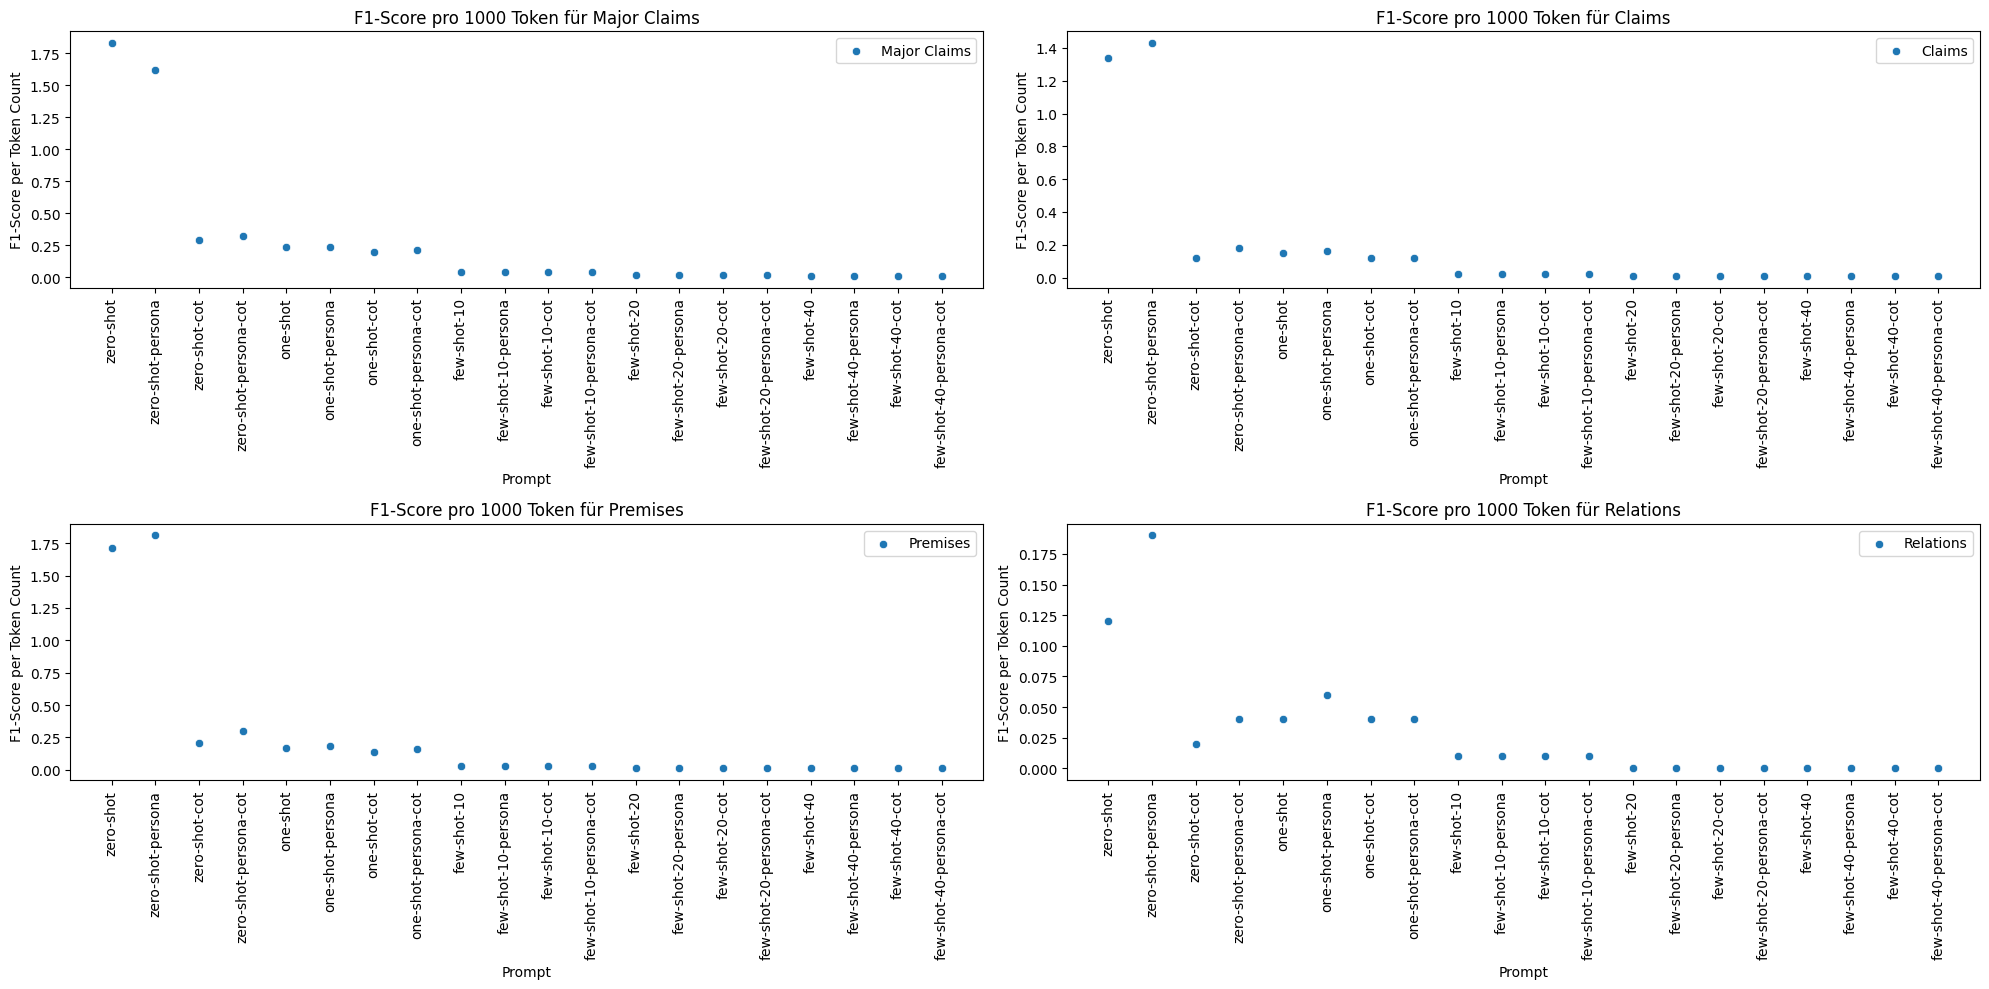

In [61]:
# Create a figure and axis
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# Plot for Major Claims
sns.scatterplot(x='Prompt', y='F1_Score_MC_per_token', data=f1_per_token_df, ax=axs[0, 0], label='Major Claims')
axs[0, 0].set_title('F1-Score pro 1000 Token für Major Claims')
axs[0, 0].set_xlabel('Prompt')
axs[0, 0].set_ylabel('F1-Score per Token Count')
axs[0, 0].tick_params(axis='x', rotation=90)

# Plot for Claims
sns.scatterplot(x='Prompt', y='F1_Score_C_per_token', data=f1_per_token_df, ax=axs[0, 1], label='Claims')
axs[0, 1].set_title('F1-Score pro 1000 Token für Claims')
axs[0, 1].set_xlabel('Prompt')
axs[0, 1].set_ylabel('F1-Score per Token Count')
axs[0, 1].tick_params(axis='x', rotation=90)

# Plot for Premises
sns.scatterplot(x='Prompt', y='F1_Score_P_per_token', data=f1_per_token_df, ax=axs[1, 0], label='Premises')
axs[1, 0].set_title('F1-Score pro 1000 Token für Premises')
axs[1, 0].set_xlabel('Prompt')
axs[1, 0].set_ylabel('F1-Score per Token Count')
axs[1, 0].tick_params(axis='x', rotation=90)

# Plot for Relations
sns.scatterplot(x='Prompt', y='F1_Score_R_per_token', data=f1_per_token_df, ax=axs[1, 1], label='Relations')
axs[1, 1].set_title('F1-Score pro 1000 Token für Relations')
axs[1, 1].set_xlabel('Prompt')
axs[1, 1].set_ylabel('F1-Score per Token Count')
axs[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

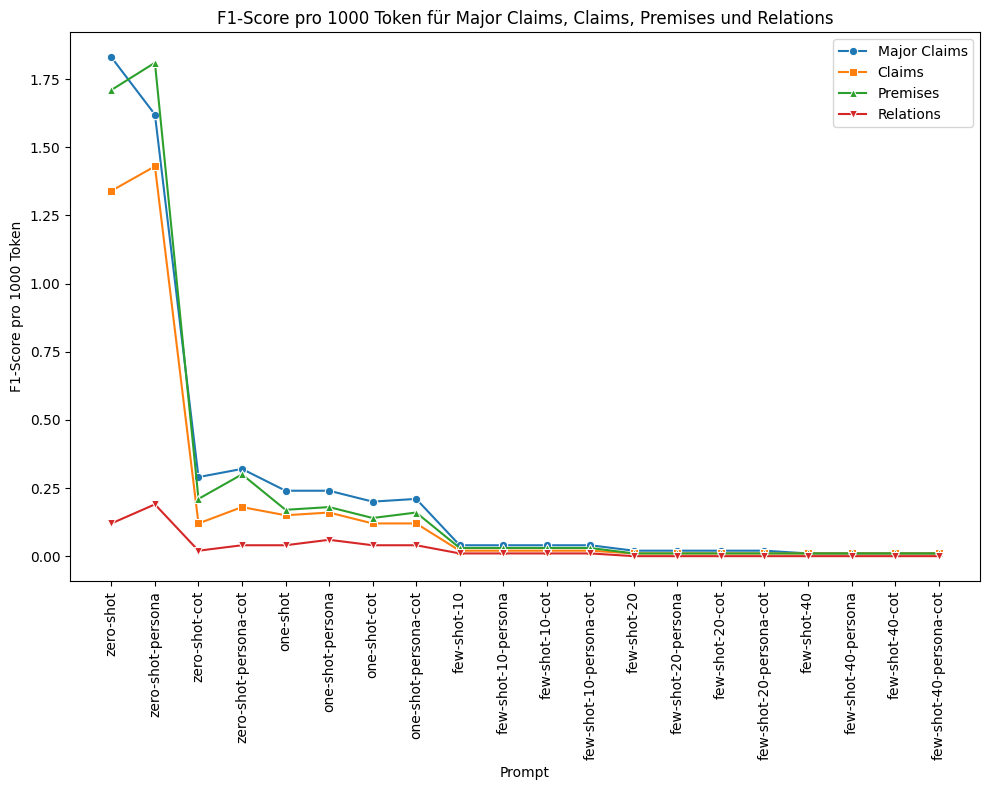

In [62]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot for Major Claims
sns.lineplot(x='Prompt', y='F1_Score_MC_per_token', data=f1_per_token_df, ax=ax, label='Major Claims', marker='o')

# Plot for Claims
sns.lineplot(x='Prompt', y='F1_Score_C_per_token', data=f1_per_token_df, ax=ax, label='Claims', marker='s')

# Plot for Premises
sns.lineplot(x='Prompt', y='F1_Score_P_per_token', data=f1_per_token_df, ax=ax, label='Premises', marker='^')

# Plot for Relations
sns.lineplot(x='Prompt', y='F1_Score_R_per_token', data=f1_per_token_df, ax=ax, label='Relations', marker='v')

# Set titles and labels
ax.set_title('F1-Score pro 1000 Token für Major Claims, Claims, Premises und Relations')
ax.set_xlabel('Prompt')
ax.set_ylabel('F1-Score pro 1000 Token')
ax.tick_params(axis='x', rotation=90)

# Add legend
ax.legend()

plt.tight_layout()
plt.show()


# Error Analysis

In [63]:
merged_eval_df.columns

Index(['txt_file', 'relations_truth', 'majorclaims_truth', 'claims_truth',
       'premises_truth', 'model', 'system_fingerprint', 'input_tokens',
       'output_tokens', 'total_tokens', 'prompt_token_details',
       'completion_token_details', 'relations_llm', 'majorclaims_llm',
       'claims_llm', 'premises_llm', 'prompt', 'MajorClaims_TP',
       'MajorClaims_FN', 'MajorClaims_FP', 'MajorClaims_TN',
       'MajorClaims_Similarity', 'Claims_TP', 'Claims_FN', 'Claims_FP',
       'Claims_TN', 'Claims_Similarity', 'Premises_TP', 'Premises_FN',
       'Premises_FP', 'Premises_TN', 'Premises_Similarity', 'Relations_TP',
       'Relations_FN', 'Relations_FP', 'Relations_TN', 'Relations_Similarity'],
      dtype='object')

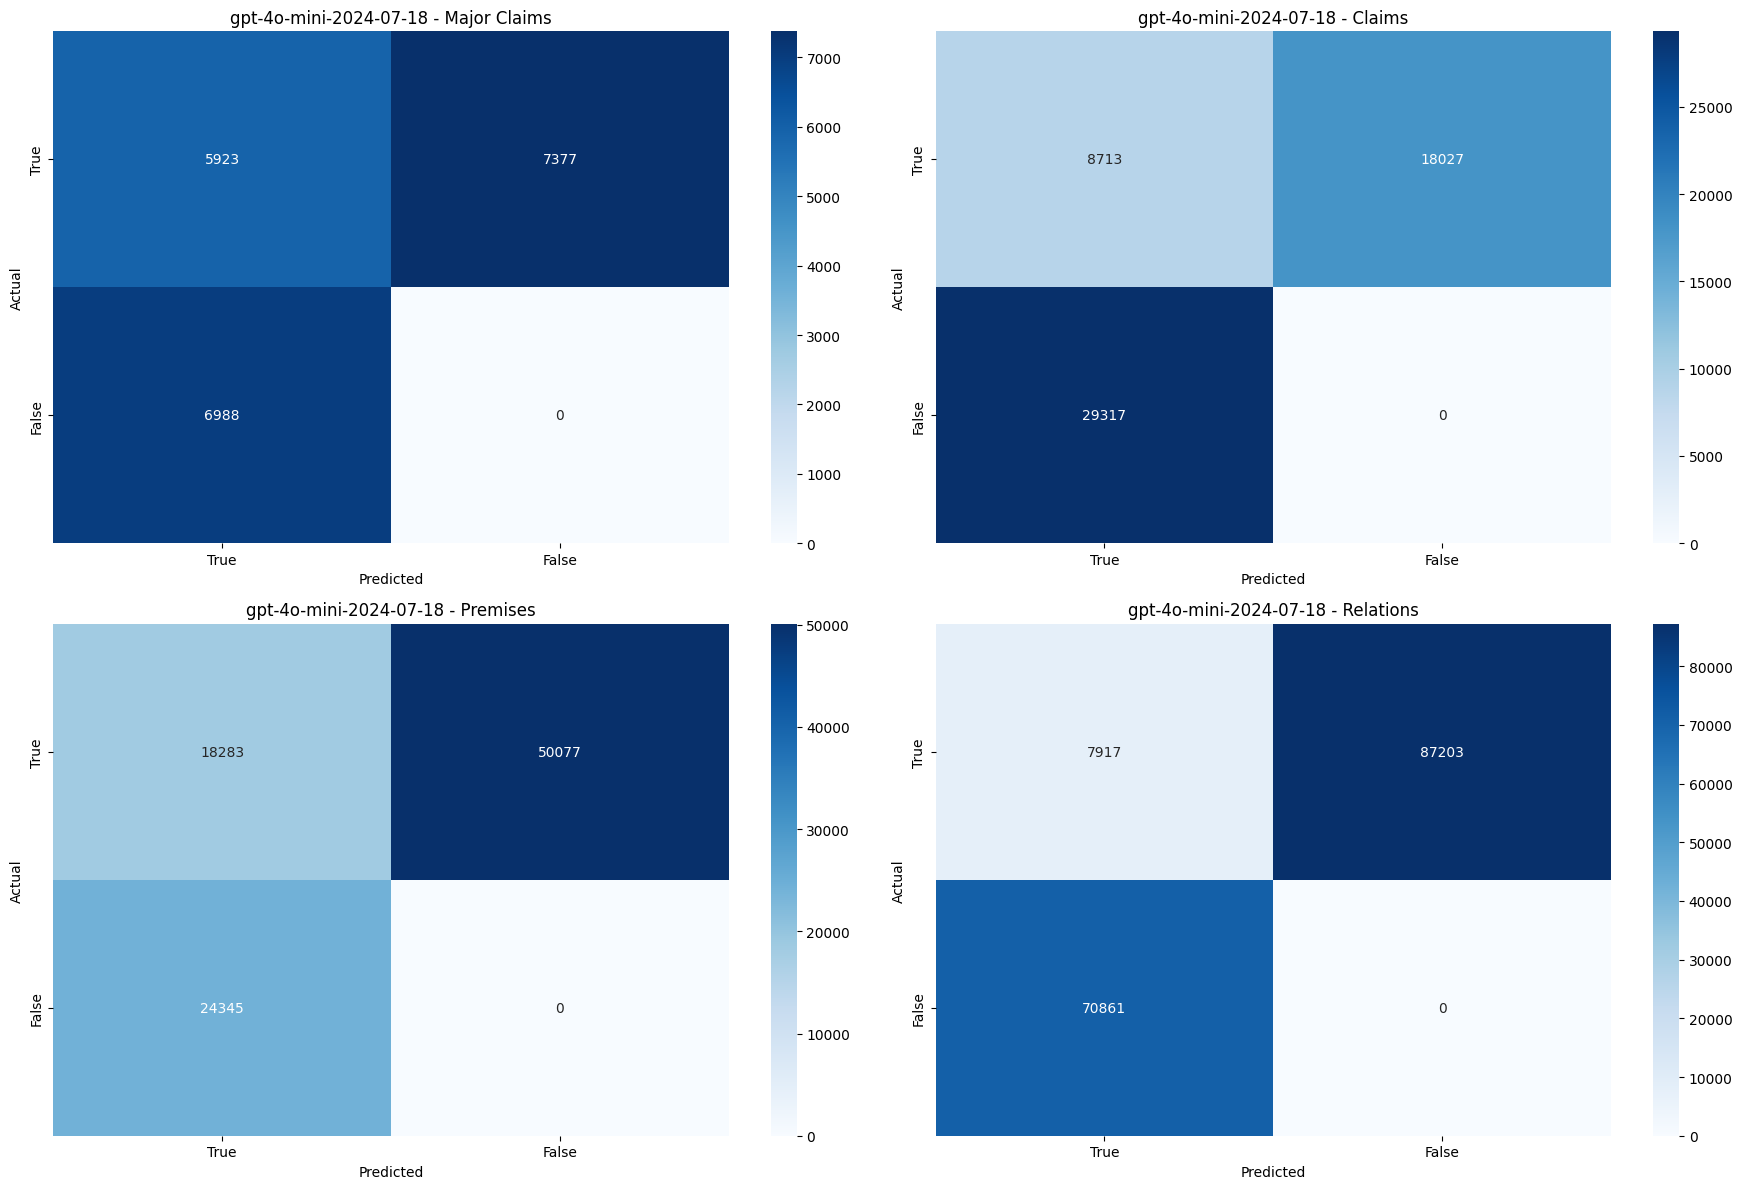

In [64]:
# Konfusionsmatrix über alle Prompts hinweg
cols = ['MajorClaims_TP','MajorClaims_FN', 'MajorClaims_FP', 'MajorClaims_TN', 'Claims_TP', 'Claims_FN', 'Claims_FP', 'Claims_TN', 'Premises_TP', 'Premises_FN', 'Premises_FP', 'Premises_TN', 'Relations_TP', 'Relations_FN', 'Relations_FP', 'Relations_TN']
df = merged_eval_df.groupby('model')[cols].sum()
plot_confusion_matrices(df)

In [65]:
def filter_and_sample(df, component, threshold=0.75, sample_size=5, random_state=42):
    """
    Filters the dataframe based on the similarity threshold for the specified component and samples the filtered rows.

    Args:
        df (pd.DataFrame): The dataframe to filter and sample.
        component (str): The component to filter on ('MajorClaims', 'Claims', 'Premises', 'Relations').
        threshold (float): The similarity threshold to filter on.
        sample_size (int): The number of samples to return.
        random_state (int): The random state for sampling.

    Returns:
        Prints the sampled rows for the specified component. Values for 'Truth', 'LLM', and 'Similarity' are printed.
    """
    similarity_col = f'{component}_Similarity'
    truth_col = f'{component.lower()}_truth'
    llm_col = f'{component.lower()}_llm'

    # Filter rows where the minimum similarity score is less than the threshold
    row_seperator = df[df[similarity_col].apply(lambda x: min(x) < threshold)]
    col_seperator = [truth_col, llm_col, similarity_col]
    filtered_df = df.loc[row_seperator.index, col_seperator]
    print(f"Anzahl an Zeilen: {filtered_df.shape[0]}\n")

    sample = filtered_df.sample(sample_size, random_state=random_state)
    sample_truth = sample[truth_col].values
    sample_llm = sample[llm_col].values
    sample_similarity = sample[similarity_col].values

    for i in range(len(sample_truth)):
        print(f"Truth: {sample_truth[i]}")
        print(f"LLM: {sample_llm[i]}")
        print(f"Similarity: {sample_similarity[i]}")
        print("\n")

    return sample

# Example usage for Major Claims
mc_sample = filter_and_sample(merged_eval_df, 'MajorClaims')

Anzahl an Zeilen: 5299

Truth: ['I personally prefer studying in a group due to these noticeable features, getting help from other students, improving my attitude for learning, managing my time in an effective way', 'I strongly prefer studying in a group of my friends because of some important opportunities gaining with this activity']
LLM: ['I personally prefer studying in a group', 'group-studying causes some kind of internal obligation to manage the time']
Similarity: [0.0432, 0.1159]


Truth: ['financial aid is not the only way to assist poor countries', 'it is disagreed that this can be the best and only way to assist developing countries']
LLM: ['financial aid is not the only way to assist poor countries', 'developing education and improving national technology and science level are the path they have to undergo if they really want to alter current situation']
Similarity: [1.0, 0.0112]


Truth: ['I find myself aligned with opponents of the usages of nuclear power', 'nuclear power

In [66]:
#Claims
c_sample = filter_and_sample(merged_eval_df, 'Claims')

Anzahl an Zeilen: 6779

Truth: ["art could play an active role in improving the quality of people's lives", 'those are the most essential ways enable to make people a decent life', 'Art is not the key determination of quality of life, but education is', "art, to some extent, serve a valuable function about enriching one's daily lives"]
LLM: ['Art is not the key determination of quality of life.', 'Art serves a valuable function in enriching daily lives.', 'The pursuit of art seems unimportant compared to basic housing supply issues.']
Similarity: [0.652, 0.0157, 0.0865, 0.0366]


Truth: ['I hold this belief because of two main reasons, academic and social reasons', 'Growing up in the countryside is not such a good experience', 'if a child grows up in a big city they will be all day at home at the computer or at the video-game', 'In a big city you have more qualified teachers and a better access to technology']
LLM: ['Some people thinks that if a child grows up in a big city they will b

In [67]:
# Premises
p_sample = filter_and_sample(merged_eval_df, 'Premises')

Anzahl an Zeilen: 7163

Truth: ['education is better in big cities in comparison with countrysides', "in my country the best schools, universities and institutes are located in cities, and todays education is one of the most important parts of our children's life", 'it is acknowledged that a large number of creational facilities are built in cities', 'playgrounds, parks, science museums, cinemas etc', 'in countrysides we hardly ever see creational facilities', 'Children who live in countrysides most of the time pass their free time in farms', 'in big cities children access to media easily', 'Via internet they can have connection with the other children all around the world']
LLM: ["todays education is one of the most important parts of our children's life", 'playgrounds, parks, science museums, cinemas are available in cities', 'children who live in countrysides most of the time pass their free time in farms', 'via internet they can have connection with the other children all around th

In [68]:
test = merged_eval_df[['Relations_Similarity', 'relations_truth', 'relations_llm', 'Relations_TP']].sample(5, random_state=42)
test

Relations_Similarity  \
1554  [(1.0, 0.0446), (0.0561, 0.0269), (1.0, 0.0157...   
2876  [(0.0393, 0), (0.023, 0), (0.9036, 0), (0.1352...   
1755  [(0.5738, 0.0578), (0.4126, 1.0), (0.6479, 0.4...   
2505  [(0.9254, 0.293), (0.9306, 0), (0.8932, 0), (0...   
1335  [(0.3724, 0), (0.9193, 1.0), (0.3238, 1.0), (0...   

                                        relations_truth  \
1554  [(Studying at home by using technology is conv...   
2876  [(Modern TV has smart system that let you be c...   
1755  [(One of the strong arguments in favour of tig...   
2505  [(the person with better education has a wider...   
1335  [(the television can have violent programs, ag...   

                                          relations_llm  Relations_TP  
1554  [(Studying at home by using technology is conv...             2  
2876  [(TV programs are among the popular topics in ...             1  
1755  [(the government should exercise less restrict...             0  
2505  [(child who is brought up in less well-off fam...             1  
1335  [(television has useful and educational progra...             4

In [69]:
for index, row in test.iterrows():
    print(f"Row {index}:")
    print(f"TP: {row['Relations_TP']}")
    print(f"Similarity: {row['Relations_Similarity']}")
    print(f"Truth: {row['relations_truth']}")
    print(f"LLM: {row['relations_llm']}")
    #for sim, truth, llm in zip(row['Relations_Similarity'], row['relations_truth'], row['relations_llm']):
        #print(f"Similarity: {sim}")
        #print(f"Truth: {truth}")
        #print(f"LLM: {llm}") 
        #print("\n")
    print("\n")

Row 1554:
TP: 2
Similarity: [(1.0, 0.0446), (0.0561, 0.0269), (1.0, 0.0157), (1.0, 0), (0.6761, 0.0269), (0.9193, 0), (0.9254, 1.0), (0.9193, 0), (0.0157, 0.0446), (1.0, 0), (1.0, 0), (1.0, 0), (0.8465, 0.0138), (0.0561, 0.0269), (0.5353, 0.0116), (1.0, 0.0116), (0.0253, 0.0138), (1.0, 0), (0.9306, 0), (1.0, 0.0157), (1.0, 1.0), (0.5536, 0)]
Truth: [('Studying at home by using technology is convenient', 'against', 'MC'), ('The biggest advantage is that your classroom and instructor are available 24 hours a day', 'supports', 'Studying at home by using technology is convenient'), ('you could make your own schedule for completing the requirements of the course', 'supports', 'Studying at home by using technology is convenient'), ('You can study any time you want', 'supports', 'Studying at home by using technology is convenient'), ("if you aren't extremely dedicated or have good time management skills, it may be very difficult to complete a course at home", 'attacks', 'Studying at home by u

In [70]:
test['relations_truth'].values[1]

[('Modern TV has smart system that let you be connected with people',
  'for',
  'MC'),
 ('watching TV take a lot of your day', 'against', 'MC'),
 ('it makes people meet and start a conversation about what they watch at other times like weather forecast and sport programs',
  'attacks',
  'watching TV take a lot of your day'),
 ('people like having meals while they are watching TV', 'for', 'MC'),
 ('Families usually tend to watch television either with each other or friends',
  'for',
  'MC'),
 ('my friends and I used to sit together and enjoy watching movies using VHS player at nights',
  'supports',
  'Families usually tend to watch television either with each other or friends'),
 ('It was fun and a little bit similar to the cinema',
  'supports',
  'Families usually tend to watch television either with each other or friends'),
 ('we can communicate with each other through TV', 'for', 'MC'),
 ('TV can be connected to multimedia devices that have smart operating system like Google TV,

In [71]:
test['relations_llm'].values[1]

[('TV programs are among the popular topics in every day talk as well as a great time for gathering',
  'supports',
  'I believe it has done the opposite'),
 ('watching TV takes a lot of your day, nevertheless it makes people meet and start a conversation about what they watch',
  'supports',
  'I believe it has done the opposite'),
 ('families usually tend to watch television either with each other or friends',
  'supports',
  'I believe it has done the opposite'),
 ('TV can be one of communication ways',
  'supports',
  'TV helps you to get connected with people'),
 ('people like having meals while they are watching TV',
  'supports',
  'families usually tend to watch television either with each other or friends'),
 ('my friends and I used to sit together and enjoy watching movies using VHS player at nights',
  'supports',
  'families usually tend to watch television either with each other or friends'),
 ('TV can be connected to multimedia devices that have smart operating system lik